https://www.kaggle.com/datasets/lakshmikalyan/lead-scoring-x-online-education?resource=download&select=Leads+X+Education.csv


# Lead Scoring Case Study - Problem Statement

## Contexto
X Education es una empresa educativa que vende cursos en línea para profesionales de la industria. En cualquier día, muchos profesionales interesados en los cursos llegan al sitio web, ya sea explorando los cursos, llenando un formulario de contacto o viendo algunos videos.

La compañía promociona sus cursos en varias plataformas, como sitios web y motores de búsqueda como Google. Una vez que estos profesionales ingresan al sitio web, pueden explorar o llenar un formulario con sus datos (correo electrónico o número de teléfono), momento en el cual se clasifican como un **lead**. Además, X Education también obtiene leads a través de referencias pasadas.

Una vez capturados estos leads, el equipo de ventas comienza a interactuar con ellos mediante llamadas, correos electrónicos, etc. Sin embargo, solo un pequeño porcentaje de estos leads se convierte en clientes. La tasa típica de conversión de leads en X Education es de aproximadamente **30%**.

---

## Problema
Aunque X Education obtiene muchos leads, su **tasa de conversión de leads** es baja. Por ejemplo, de 100 leads obtenidos en un día, solo 30 suelen convertirse. Para mejorar la eficiencia del proceso, la compañía desea **identificar a los leads con mayor probabilidad de conversión**, conocidos como **"Hot Leads"**. Esto permitirá que el equipo de ventas enfoque sus esfuerzos en los leads más prometedores, incrementando así la tasa de conversión.

El proceso de conversión de leads puede representarse como un **embudo** (funnel):

<p align="center">
  <img src="../images/embudo.jpg" alt="Lead Conversion Process" width="25%">
</p>


El objetivo de este caso de estudio es desarrollar un sistema de **Lead Scoring**, que clasifique a los leads con base en su probabilidad de conversión. Este sistema permitirá priorizar a los "Hot Leads" para optimizar los recursos y el tiempo del equipo de ventas.


# Importar Bibliotecas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression

In [2]:
from sklearn.metrics import confusion_matrix

def matriz_de_confusion(independiente, dependiente='Converted'):

    # Calculamos la matriz de confusión
    mdc = confusion_matrix(df[independiente], df[dependiente]) 
    
    # Configuración del mapa de calor
    plt.figure(figsize=(2, 2), dpi=300)
    sns.heatmap(mdc, annot=True, fmt='d', xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'], cmap='coolwarm', cbar=False)
    plt.title(f"Matriz de Confusión: {independiente} vs {dependiente}", fontsize=3)
    plt.xlabel(dependiente, fontsize=5)
    plt.ylabel(independiente, fontsize=5)
    plt.tight_layout()
    plt.show()

In [3]:
import pandas as pd

def calcular_estadisticas_conversion(df, columna):
    """
    Calcula estadísticas descriptivas para una columna separada por 'Converted' 
    y muestra los resultados en consola.

    Parámetros:
    df (DataFrame): DataFrame con los datos.
    columna (str): Nombre de la columna a analizar.

    Retorna:
    dict: Un diccionario con las estadísticas de la columna para Converted = 0 y Converted = 1.
    """

    if columna not in df.columns:
        print(f"⚠ La columna '{columna}' no está en el DataFrame.")
        return None

    # Filtrar valores por 'Converted'
    converted_0 = df[df['Converted'] == 0][columna]
    converted_1 = df[df['Converted'] == 1][columna]

    # Calcular estadísticas descriptivas
    stats_0 = converted_0.describe()
    stats_1 = converted_1.describe()

    # Mostrar estadísticas en consola
    print(f"📊 Estadísticas para '{columna}' - Converted = 0 (No Convertidos)")
    print(stats_0, "\n")

    print(f"📊 Estadísticas para '{columna}' - Converted = 1 (Convertidos)")
    print(stats_1, "\n")

    # Retornar los resultados como diccionario para usarlos en el Markdown después
    return {
        "Converted = 0": stats_0,
        "Converted = 1": stats_1
    }


# Importar datos

In [4]:
df = pd.read_csv('../data/XOE.csv')

## Diccionario

| Variable (Inglés)                          | Variable (Español)                        | Descripción                                                                                                                                     |
|--------------------------------------------|-------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------|
| Prospect ID                                | ID del Prospecto                          | Un ID único con el cual se identifica al cliente.                                                                                              |
| Lead Number                                | Número de Lead                            | Un número de lead asignado a cada lead obtenido.                                                                                               |
| Lead Origin                                | Origen del Lead                           | El identificador de origen con el cual el cliente fue identificado como lead. Incluye API, Envío de Página de Aterrizaje, etc.                 |
| Lead Source                                | Fuente del Lead                           | La fuente del lead. Incluye Google, Búsqueda Orgánica, Chat de Olark, etc.                                                                     |
| Do Not Email                               | No Enviar Email                           | Un indicador variable seleccionado por el cliente donde seleccionan si desean o no ser contactados por email sobre el curso.                   |
| Do Not Call                                | No Llamar                                 | Un indicador variable seleccionado por el cliente donde seleccionan si desean o no ser contactados por teléfono sobre el curso.                |
| Converted                                  | Convertido                                | La variable objetivo. Indica si un lead ha sido convertido con éxito o no.                                                                     |
| TotalVisits                                | Total de Visitas                          | El número total de visitas realizadas por el cliente al sitio web.                                                                             |
| Total Time Spent on Website                | Tiempo Total en el Sitio Web              | El tiempo total que el cliente pasó en el sitio web.                                                                                           |
| Page Views Per Visit                       | Páginas Vistas por Visita                 | Número promedio de páginas en el sitio web vistas durante las visitas.                                                                         |
| Last Activity                              | Última Actividad                          | La última actividad realizada por el cliente. Incluye Email Abierto, Conversación de Chat de Olark, etc.                                       |
| Country                                    | País                                      | El país del cliente.                                                                                                                           |
| Specialization                             | Especialización                           | El dominio de la industria en la que el cliente trabajaba antes. Incluye el nivel 'Seleccionar Especialización' si no se seleccionó ninguna.   |
| How did you hear about X Education         | Cómo se enteró sobre X Education          | La fuente de la cual el cliente se enteró sobre X Education.                                                                                   |
| What is your current occupation            | Ocupación Actual                          | Indica si el cliente es un estudiante, desempleado o empleado.                                                                                 |
| What matters most to you in choosing this course | Qué es lo más importante para usted al elegir este curso | Una opción seleccionada por el cliente indicando cuál es su principal motivo detrás de hacer este curso.                                       |
| Search                                     | Búsqueda                                  | Indica si el cliente ha visto el anuncio en alguno de los ítems listados.                                                                      |
| Magazine                                   | Revista                                   | Indica si el cliente ha visto el anuncio en una revista.                                                                                       |
| Newspaper Article                          | Artículo de Periódico                     | Indica si el cliente ha leído un artículo de periódico sobre los cursos.                                                                       |
| X Education Forums                         | Foros de X Education                      | Indica si el cliente ha participado en foros relacionados con X Education.                                                                     |
| Newspaper                                  | Periódico                                 | Indica si el cliente ha visto anuncios en el periódico.                                                                                        |
| Digital Advertisement                      | Publicidad Digital                        | Indica si el cliente ha sido expuesto a anuncios digitales.                                                                                    |
| Through Recommendations                    | A través de Recomendaciones               | Indica si el cliente llegó a través de recomendaciones.                                                                                        |
| Receive More Updates About Our Courses     | Recibir Más Actualizaciones Sobre Nuestros Cursos | Indica si el cliente desea recibir más actualizaciones sobre los cursos.                                                                       |
| Tags                                       | Etiquetas                                 | Etiquetas asignadas a los clientes que indican el estado actual del lead.                                                                      |
| Lead Quality                               | Calidad del Lead                          | Indica la calidad del lead basada en los datos y la intuición del empleado asignado al lead.                                                   |
| Update me on Supply Chain Content          | Actualizarme sobre Contenido de Cadena de Suministro | Indica si el cliente desea actualizaciones sobre contenido de cadena de suministro.                                                            |
| Get updates on DM Content                  | Recibir actualizaciones sobre Contenido DM | Indica si el cliente desea recibir actualizaciones sobre contenido de marketing digital.                                                       |
| Lead Profile                               | Perfil del Lead                           | Un nivel de lead asignado a cada cliente basado en su perfil.                                                                                  |
| City                                       | Ciudad                                    | La ciudad del cliente.                                                                                                                         |
| Asymmetrique Activity Index                | Índice de Actividad Asymmetrique          | Un índice y puntuación asignados a cada cliente basados en su actividad y perfil.                                                              |
| Asymmetrique Profile Index                 | Índice de Perfil Asymmetrique             | Un índice asignado a cada cliente basado en su perfil Asymmetrique.                                                                            |
| Asymmetrique Activity Score                | Puntuación de Actividad Asymmetrique      | Una puntuación asignada basada en la actividad del cliente.                                                                                    |
| Asymmetrique Profile Score                 | Puntuación de Perfil Asymmetrique          | Una puntuación asignada basada en el profile del cliente                       |

In [5]:
df.head()

,Prospect ID,Lead Number,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
0,7927b2df-8bba-4d29-b9a2-b6e0beafe620,660737,API,Olark Chat,No,No,0,0.0,0,0.0,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
1,2a272436-5132-4136-86fa-dcc88c88f482,660728,API,Organic Search,No,No,0,5.0,674,2.5,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
2,8cc8c611-a219-4f35-ad23-fdfd2656bd8a,660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
3,0cc2df48-7cf4-4e39-9de9-19797f9b38cc,660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
4,3256f628-e534-4826-9d63-4a8b88782852,660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


### Tenemos dos variables que podrían funcionar como 'ID': Prospect ID y Lead Number. Borremos la más compleja Prospect ID

In [6]:
df.drop(columns= 'Prospect ID', axis = 1, inplace = True)

In [7]:
df.set_index('Lead Number', inplace = True)

In [8]:
df.head()

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,...,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Index,Asymmetrique Profile Index,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
Lead Number,,,,,,,,,,,,,,,,,,,,,
660737,API,Olark Chat,No,No,0,0.0,0,0.0,Page Visited on Website,NaN,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Modified
660728,API,Organic Search,No,No,0,5.0,674,2.5,Email Opened,India,...,No,Select,Select,02.Medium,02.Medium,15.0,15.0,No,No,Email Opened
660727,Landing Page Submission,Direct Traffic,No,No,1,2.0,1532,2.0,Email Opened,India,...,No,Potential Lead,Mumbai,02.Medium,01.High,14.0,20.0,No,Yes,Email Opened
660719,Landing Page Submission,Direct Traffic,No,No,0,1.0,305,1.0,Unreachable,India,...,No,Select,Mumbai,02.Medium,01.High,13.0,17.0,No,No,Modified
660681,Landing Page Submission,Google,No,No,1,2.0,1428,1.0,Converted to Lead,India,...,No,Select,Mumbai,02.Medium,01.High,15.0,18.0,No,No,Modified


### Examinemos los datos para ver su tipo y si hay faltantes
### Notamos que hay 9240 registros, pero de las 35 variables, 17 tienen variables null

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9240 entries, 660737 to 579533
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9204 non-null   object 
 2   Do Not Email                                   9240 non-null   object 
 3   Do Not Call                                    9240 non-null   object 
 4   Converted                                      9240 non-null   int64  
 5   TotalVisits                                    9103 non-null   float64
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9103 non-null   float64
 8   Last Activity                                  9137 non-null   object 
 9   Country                                        677

### Como parte de nuestra preparación de los datos, iremos revisando una a una las variables para corregir su tipo de datos y hacer las respectivas imputaciones de datos faltantes

### Lead Source
### Hagamos un gráfico de barras para contar las fuentes del tráfico

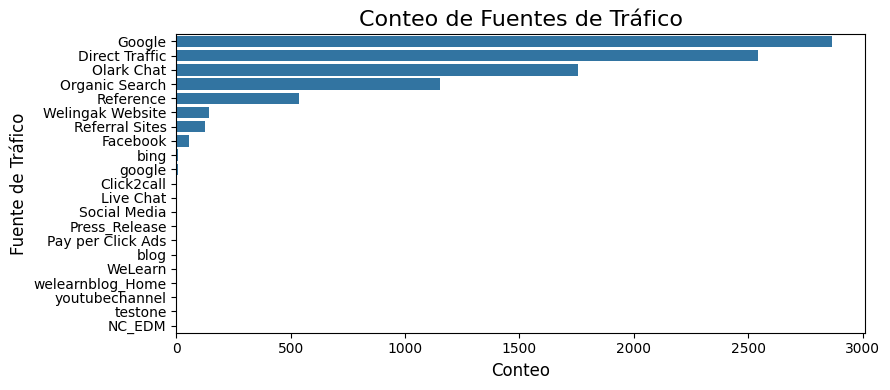

In [10]:
plt.figure(figsize=(9, 4))

sns.countplot(
    y='Lead Source',                                       # barra horizontal en vez de x='Lead Source', vertical 
    data=df,
    order=df['Lead Source'].value_counts().index  
)

# Personalizar etiquetas y título
plt.title('Conteo de Fuentes de Tráfico', fontsize=16)
plt.xlabel('Conteo', fontsize=12)
plt.ylabel('Fuente de Tráfico', fontsize=12)

# Ajustar diseño
plt.tight_layout()


plt.show()

## Análisis Exploratorio de Datos: Manejo de Valores Faltantes en "Lead Source"

En el análisis exploratorio de datos, es fundamental identificar y manejar los valores faltantes de manera adecuada para evitar sesgos o errores en los resultados del modelo.

Una posible estrategia para manejar los valores faltantes en la columna **"Lead Source"** sería reemplazarlos con la fuente de tráfico más común (es decir, la **moda**). Esto tiene sentido cuando existe una clara predominancia de una fuente de tráfico específica, ya que se podría asumir razonablemente que la mayoría de los leads provienen de esa fuente.

Sin embargo, en este caso, el análisis muestra una distribución más diversa entre las distintas fuentes de tráfico, sin una predominancia absoluta. Por ello, en lugar de usar la moda, optaremos por asignar el valor **"Desconocido"** a los valores faltantes. Esto permite preservar la diversidad de los datos originales y evita introducir supuestos innecesarios.

Esta decisión se basa en la idea de que es más apropiado etiquetar los datos faltantes como "Desconocido" cuando no hay suficiente evidencia para asumir una fuente predominante.


In [11]:
df['Lead Source'] =df['Lead Source'].fillna('Desconocido')

## Corrección de Tipo de Datos: Do Not Email, Do Not Call, Converted

| **Variable**   | **Descripción**                                                                                   |
|-----------------|---------------------------------------------------------------------------------------------------|
| **Do Not Email** | Una variable indicadora seleccionada por el cliente donde eligen si desean o no recibir correos electrónicos sobre el curso. |
| **Do Not Call**  | Una variable indicadora seleccionada por el cliente donde eligen si desean o no ser llamados sobre el curso.                  |
| **Converted**    | La variable objetivo. Indica si un lead ha sido convertido exitosamente o no.                                                 |








#### Convirtamos las variables a booleanos. Como haremos lo mismo con las tres, hagamos un lazo for (Las dos primeras son object la tercera int)

In [12]:
print(df['Do Not Email'].unique())


['No' 'Yes']


In [13]:
for v in ['Do Not Email', 'Do Not Call']:
    df[v] = df[v].map({'Yes': 1, 'No': 0})
    df[v] = df[v].astype(bool)
   

Manejo de Valores Nulos: **TotalVisits y Page Views Per Visit**

**TotalVisits**: El número total de visitas realizadas por el cliente en el sitio web.

**Page Views Per Visit**: El número total de páginas vistas por el cliente durante sus visitas en el sitio web.

Evaluamos la distribución de cada una de estas características para determinar el mejor método de imputación.

### Examinemos la distribución de Total Visits

In [14]:
df['TotalVisits'].describe()

count    9103.000000
mean        3.445238
std         4.854853
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64

### Hagamos un histograma de la distribución

<Axes: xlabel='TotalVisits', ylabel='Count'>

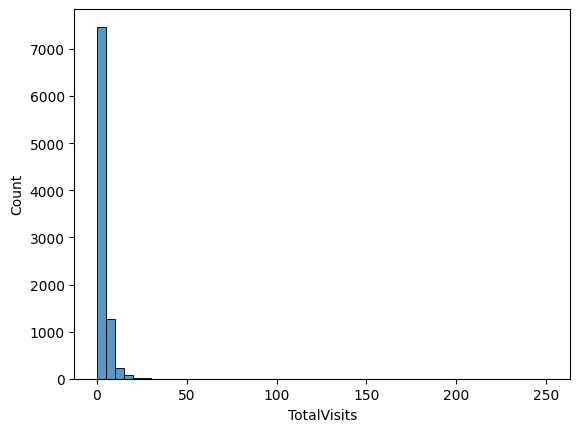

In [15]:
sns.histplot(x='TotalVisits', data=df, bins=50)

### Examinemos la distribución de 'Page Views Per Visit'

In [16]:
df['Page Views Per Visit'].describe()

count    9103.000000
mean        2.362820
std         2.161418
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64

### Hagamos un histograma de la distribución

<Axes: xlabel='Page Views Per Visit', ylabel='Count'>

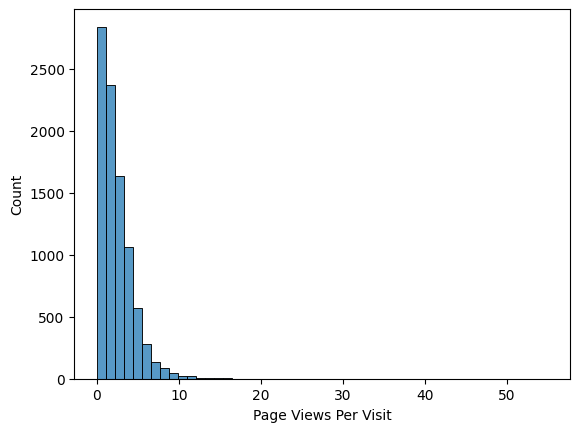

In [17]:
sns.histplot(x='Page Views Per Visit', data=df, bins=50)

## Teoría: Imputación de Valores Faltantes

La imputación de valores faltantes depende de la distribución de los datos y la medida de tendencia central más adecuada. La siguiente tabla resume las recomendaciones:

| **Distribución de los Datos**     | **Medida de Tendencia Central Recomendada** | **Razón**                                                                                                  |
|-----------------------------------|--------------------------------------------|------------------------------------------------------------------------------------------------------------|
| **Sesgada**                       | Mediana                                    | La mediana es menos sensible a valores atípicos o extremos, proporcionando una mejor estimación central.   |
| **Normal (Simétrica)**            | Media                                      | En distribuciones normales, la media representa adecuadamente el centro, ya que coincide con la mediana.   |

### Ejemplos:
- **Distribuciones sesgadas:** Datos de ingresos, precios de vivienda, etc.
- **Distribuciones normales:** Alturas, pesos en una población homogénea, etc.

Usar la medida adecuada ayuda a preservar las propiedades originales de los datos, evitando introducir sesgos adicionales en el análisis.


### Imputamos la mediana para los valores faltantes de TotalVisits

In [18]:
df['TotalVisits'] = df['TotalVisits'].fillna(df['TotalVisits'].median())

### Imputamos la mediana para los valores faltantes de 'Page Views Per Visit'

In [19]:
df['Page Views Per Visit'] = df['Page Views Per Visit'].fillna(df['Page Views Per Visit'].median())

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9240 entries, 660737 to 579533
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9240 non-null   object 
 2   Do Not Email                                   9240 non-null   bool   
 3   Do Not Call                                    9240 non-null   bool   
 4   Converted                                      9240 non-null   int64  
 5   TotalVisits                                    9240 non-null   float64
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9240 non-null   float64
 8   Last Activity                                  9137 non-null   object 
 9   Country                                        677

**Manejo de Valores Nulos: Última Actividad**

**Last Activity**: Última actividad realizada por el cliente. Incluye apertura de email, conversación en Olark Chat, etc.
Evaluar la distribución de la característica para determinar el mejor método de imputación de valores nulos.

### Gráfico de Distribución de Last Activity

<Axes: xlabel='count', ylabel='Last Activity'>

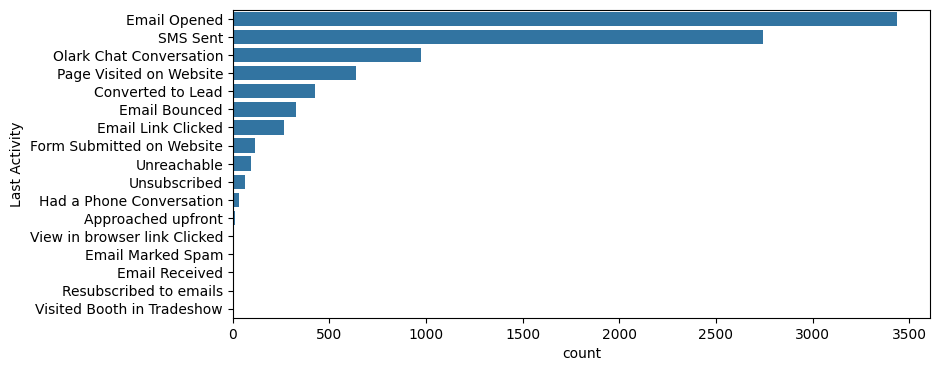

In [21]:
plt.figure(figsize=(9, 4))
sns.countplot(y='Last Activity', data = df, order = df['Last Activity'].value_counts().index)

## 📊 Explicación del Código en Matplotlib

A continuación, se presenta una tabla que describe el propósito de cada línea en el código para anotar valores en un gráfico de barras de `seaborn`.

| **Código** | **Explicación** |
|------------|----------------|
| `for p in ax.patches:` | Itera sobre todas las barras del gráfico. Cada `p` representa una barra. |
| `ax.patches` | Es una lista de todas las barras del gráfico generadas por `sns.countplot()`. |
| `ax.annotate(f'{int(p.get_width())}', ...)` | Anota el valor en cada barra. |
| `p.get_width()` | Obtiene la longitud de la barra (el conteo de la categoría en el eje X). |
| `p.get_y() + p.get_height()/2` | Posiciona el texto en el centro vertical de la barra. |
| `ha='left'` | Alinea el texto a la izquierda del punto `(p.get_width(), ...)`. |
| `va='center'` | Centra el texto verticalmente en la barra. |
| `fontsize=10` | Establece el tamaño de la fuente en 10. |
| `color='black'` | Define el color del texto como negro. |

✅ **Objetivo:** Mostrar etiquetas con los valores en cada barra para mejorar la interpretación del gráfico.

## 📊 Propiedades de las Barras en `ax.barh()`

Cuando usamos `ax.barh()`, Matplotlib crea un objeto de tipo `Rectangle` para cada barra.  
Estos objetos contienen información sobre su posición y tamaño en el gráfico:

| Propiedad        | Descripción |
|-----------------|-------------|
| `p.get_x()`     | Coordenada **X** donde empieza la barra (generalmente `0.0` en un gráfico de barras horizontales). |
| `p.get_y()`     | Coordenada **Y** donde empieza la barra (determina la posición vertical de la barra). |
| `p.get_width()` | Valor de la barra, es decir, su **longitud en X** (el valor que estamos graficando). |
| `p.get_height()`| Altura de la barra (determina su grosor en el gráfico). |





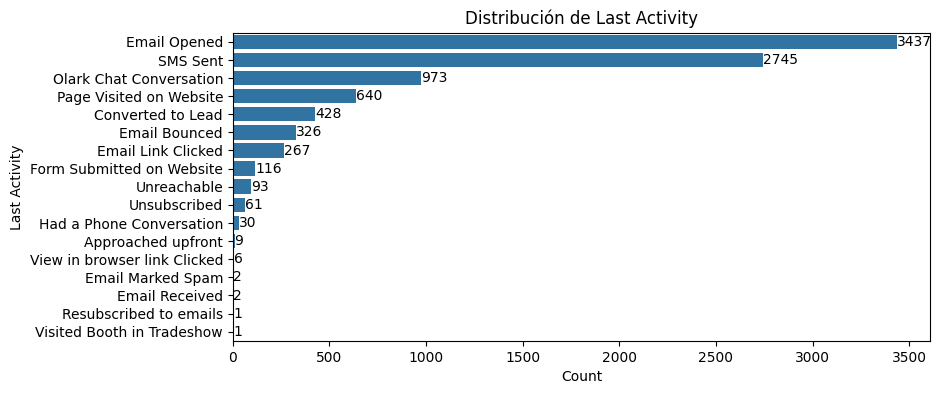

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 4))
order = df['Last Activity'].value_counts().index
ax = sns.countplot(y='Last Activity', data=df, order=order)

# Agregar los valores en cada barra
for p in ax.patches:                                                 
    ax.annotate(f'{int(p.get_width())}',                             
                (p.get_width(), p.get_y() + p.get_height()/2), 
                ha='left', va='center', fontsize=10, color='black')

plt.xlabel("Count")
plt.ylabel("Last Activity")
plt.title("Distribución de Last Activity")
plt.show()


## Análisis de la Distribución de la 'Última Actividad'

El gráfico de distribución de la columna 'Última Actividad' de los clientes muestra patrones variados en el comportamiento y las preferencias de interacción con la empresa. Ninguna de las actividades sobresale con un dominio absoluto (es decir, con un porcentaje superior al 80-95%). Esto indica que no existe una tendencia única que defina cómo los clientes interactúan predominantemente con los diferentes canales de comunicación disponibles.

Dado este contexto, es razonable asignar el valor **"Desconocido" a los registros faltantes en la columna 'Última Actividad'**. Esta decisión preserva la integridad de los datos y evita introducir un sesgo hacia una actividad específica que podría no ser representativa de la mayoría.

Además, este enfoque permite mantener un análisis honesto de las limitaciones de los datos. Reconocer la ausencia de información en lugar de asumir una actividad predominante abre oportunidades para mejorar futuras estrategias de recopilación de datos y responder preguntas clave sobre cómo interactúan los clientes.


In [117]:
df['Last Activity'] = df['Last Activity'].fillna('Desconocido')

## 📌 ¿Debe "Through Recommendations" aparecer en `Last Activity`?

No, **"Through Recommendations"** no debería aparecer en `Last Activity`, y aquí está la razón:

### 📊 Diferencias entre `Last Activity` y `Through Recommendations`

| **Concepto** | **Explicación** |
|-------------|----------------|
| **`Last Activity` (Última Actividad)** | Indica la última acción específica que realizó el cliente en el proceso, como `"Email Opened"`, `"SMS Sent"`, `"Olark Chat Conversation"`, etc. |
| **`Through Recommendations` (A través de Recomendaciones)** | No es una actividad realizada por el usuario, sino una **fuente de adquisición** del lead, es decir, cómo llegó el cliente inicialmente. |

### 🔍 **¿Dónde debería estar "Through Recommendations"?**

| **Columna** | **Contenido** |
|------------|--------------|
| **`Lead Source`** | "Through Recommendations" puede aparecer aquí, ya que indica cómo el cliente conoció la empresa. |
| **`How did you hear about X Education`** | También es una posible columna donde podría encontrarse, ya que indica la fuente de referencia. |
| **`Last Activity`** | ❌ **No debería estar aquí** porque solo incluye acciones como `"Page Visited on Website"`, `"Email Opened"`, etc. |

### 🚀 **Conclusión**
Si `"Through Recommendations"` **no aparece en la distribución de `Last Activity`**, **es correcto** porque **no representa una actividad del cliente**, sino **un origen de adquisición**.


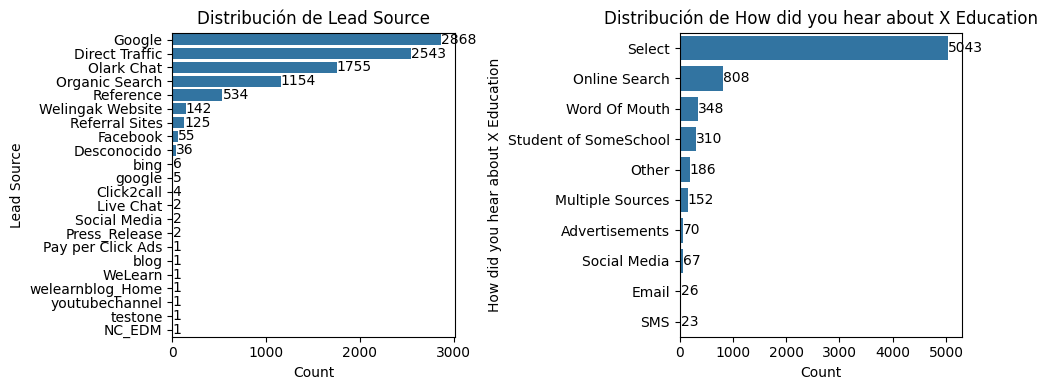

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración del tamaño de la figura
plt.figure(figsize=(10, 4))

# Graficar Lead Source
plt.subplot(1, 2, 1)  # Primera gráfica
order_ls = df['Lead Source'].value_counts().index
ax1 = sns.countplot(y='Lead Source', data=df, order=order_ls)

# Agregar valores en cada barra
for p in ax1.patches:
    ax1.annotate(f'{int(p.get_width())}', 
                 (p.get_width(), p.get_y() + p.get_height()/2), 
                 ha='left', va='center', fontsize=10, color='black')

plt.xlabel("Count")
plt.ylabel("Lead Source")
plt.title("Distribución de Lead Source")

# Graficar How did you hear about X Education
plt.subplot(1, 2, 2)  # Segunda gráfica
order_hdyh = df['How did you hear about X Education'].value_counts().index
ax2 = sns.countplot(y='How did you hear about X Education', data=df, order=order_hdyh)

# Agregar valores en cada barra
for p in ax2.patches:
    ax2.annotate(f'{int(p.get_width())}', 
                 (p.get_width(), p.get_y() + p.get_height()/2), 
                 ha='left', va='center', fontsize=10, color='black')

plt.xlabel("Count")
plt.ylabel("How did you hear about X Education")
plt.title("Distribución de How did you hear about X Education")

# Ajustar diseño
plt.tight_layout()
plt.show()


In [24]:
# Revisar valores únicos en Lead Source
print(df['Lead Source'].unique())

# Revisar valores únicos en How did you hear about X Education
print(df['How did you hear about X Education'].unique())

# Contar la cantidad de veces que aparece "Through Recommendations"
print(df['Lead Source'].value_counts())
print(df['How did you hear about X Education'].value_counts())


['Olark Chat' 'Organic Search' 'Direct Traffic' 'Google' 'Referral Sites'
 'Welingak Website' 'Reference' 'google' 'Facebook' 'Desconocido' 'blog'
 'Pay per Click Ads' 'bing' 'Social Media' 'WeLearn' 'Click2call'
 'Live Chat' 'welearnblog_Home' 'youtubechannel' 'testone' 'Press_Release'
 'NC_EDM']
['Select' 'Word Of Mouth' 'Other' nan 'Online Search' 'Multiple Sources'
 'Advertisements' 'Student of SomeSchool' 'Email' 'Social Media' 'SMS']
Lead Source
Google               2868
Direct Traffic       2543
Olark Chat           1755
Organic Search       1154
Reference             534
Welingak Website      142
Referral Sites        125
Facebook               55
Desconocido            36
bing                    6
google                  5
Click2call              4
Live Chat               2
Social Media            2
Press_Release           2
Pay per Click Ads       1
blog                    1
WeLearn                 1
welearnblog_Home        1
youtubechannel          1
testone                 

In [26]:
# Ver los valores únicos en la columna "Through Recommendations"
print(df['Through Recommendations'].unique())


['No' 'Yes']


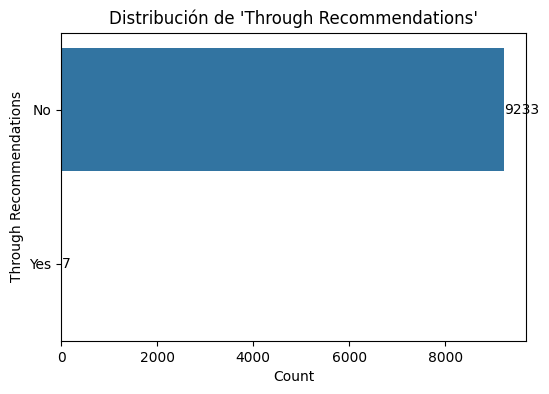

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
ax = sns.countplot(y='Through Recommendations', data=df, order=df['Through Recommendations'].value_counts().index)

# Agregar valores en cada barra
for p in ax.patches:
    ax.annotate(f'{int(p.get_width())}', 
                (p.get_width(), p.get_y() + p.get_height()/2), 
                ha='left', va='center', fontsize=10, color='black')

plt.xlabel("Count")
plt.ylabel("Through Recommendations")
plt.title("Distribución de 'Through Recommendations'")
plt.show()


In [28]:
# Ver cuántos leads convertidos llegaron por recomendaciones
df.groupby('Through Recommendations')['Converted'].value_counts()


Through Recommendations  Converted
No                       0            5677
                         1            3556
Yes                      1               5
                         0               2
Name: count, dtype: int64

## 📊 Análisis de Conversión por Recomendaciones

### 🔹 **Observaciones Claves**
- Solo **7 clientes** llegaron por recomendaciones (`Yes`), una muestra muy pequeña.
- **71.4%** de los clientes referidos se convirtieron (`5 de 7`), una tasa alta.
- La **tasa de conversión sin recomendación** es **38.5%** (`3556 de 9233`).
- **Los referidos tienen mayor probabilidad de conversión**, pero la muestra es reducida.

### 🔍 **¿Qué significa esto?**
| **Conclusión** | **Explicación** |
|--------------|----------------|
| 📢 **El boca a boca funciona** | Los clientes referidos tienen una conversión significativamente mayor. |
| 📈 **Debería explorarse más** | Aumentar la captación por recomendaciones podría mejorar la conversión total. |
| ⚠️ **No es concluyente** | Con solo **7 datos en "Yes"**, la muestra es muy pequeña para sacar conclusiones definitivas. |




### Analicemos Country: el país del lead

### Gráfico de Distribución de Leads por País

<Axes: xlabel='count', ylabel='Country'>

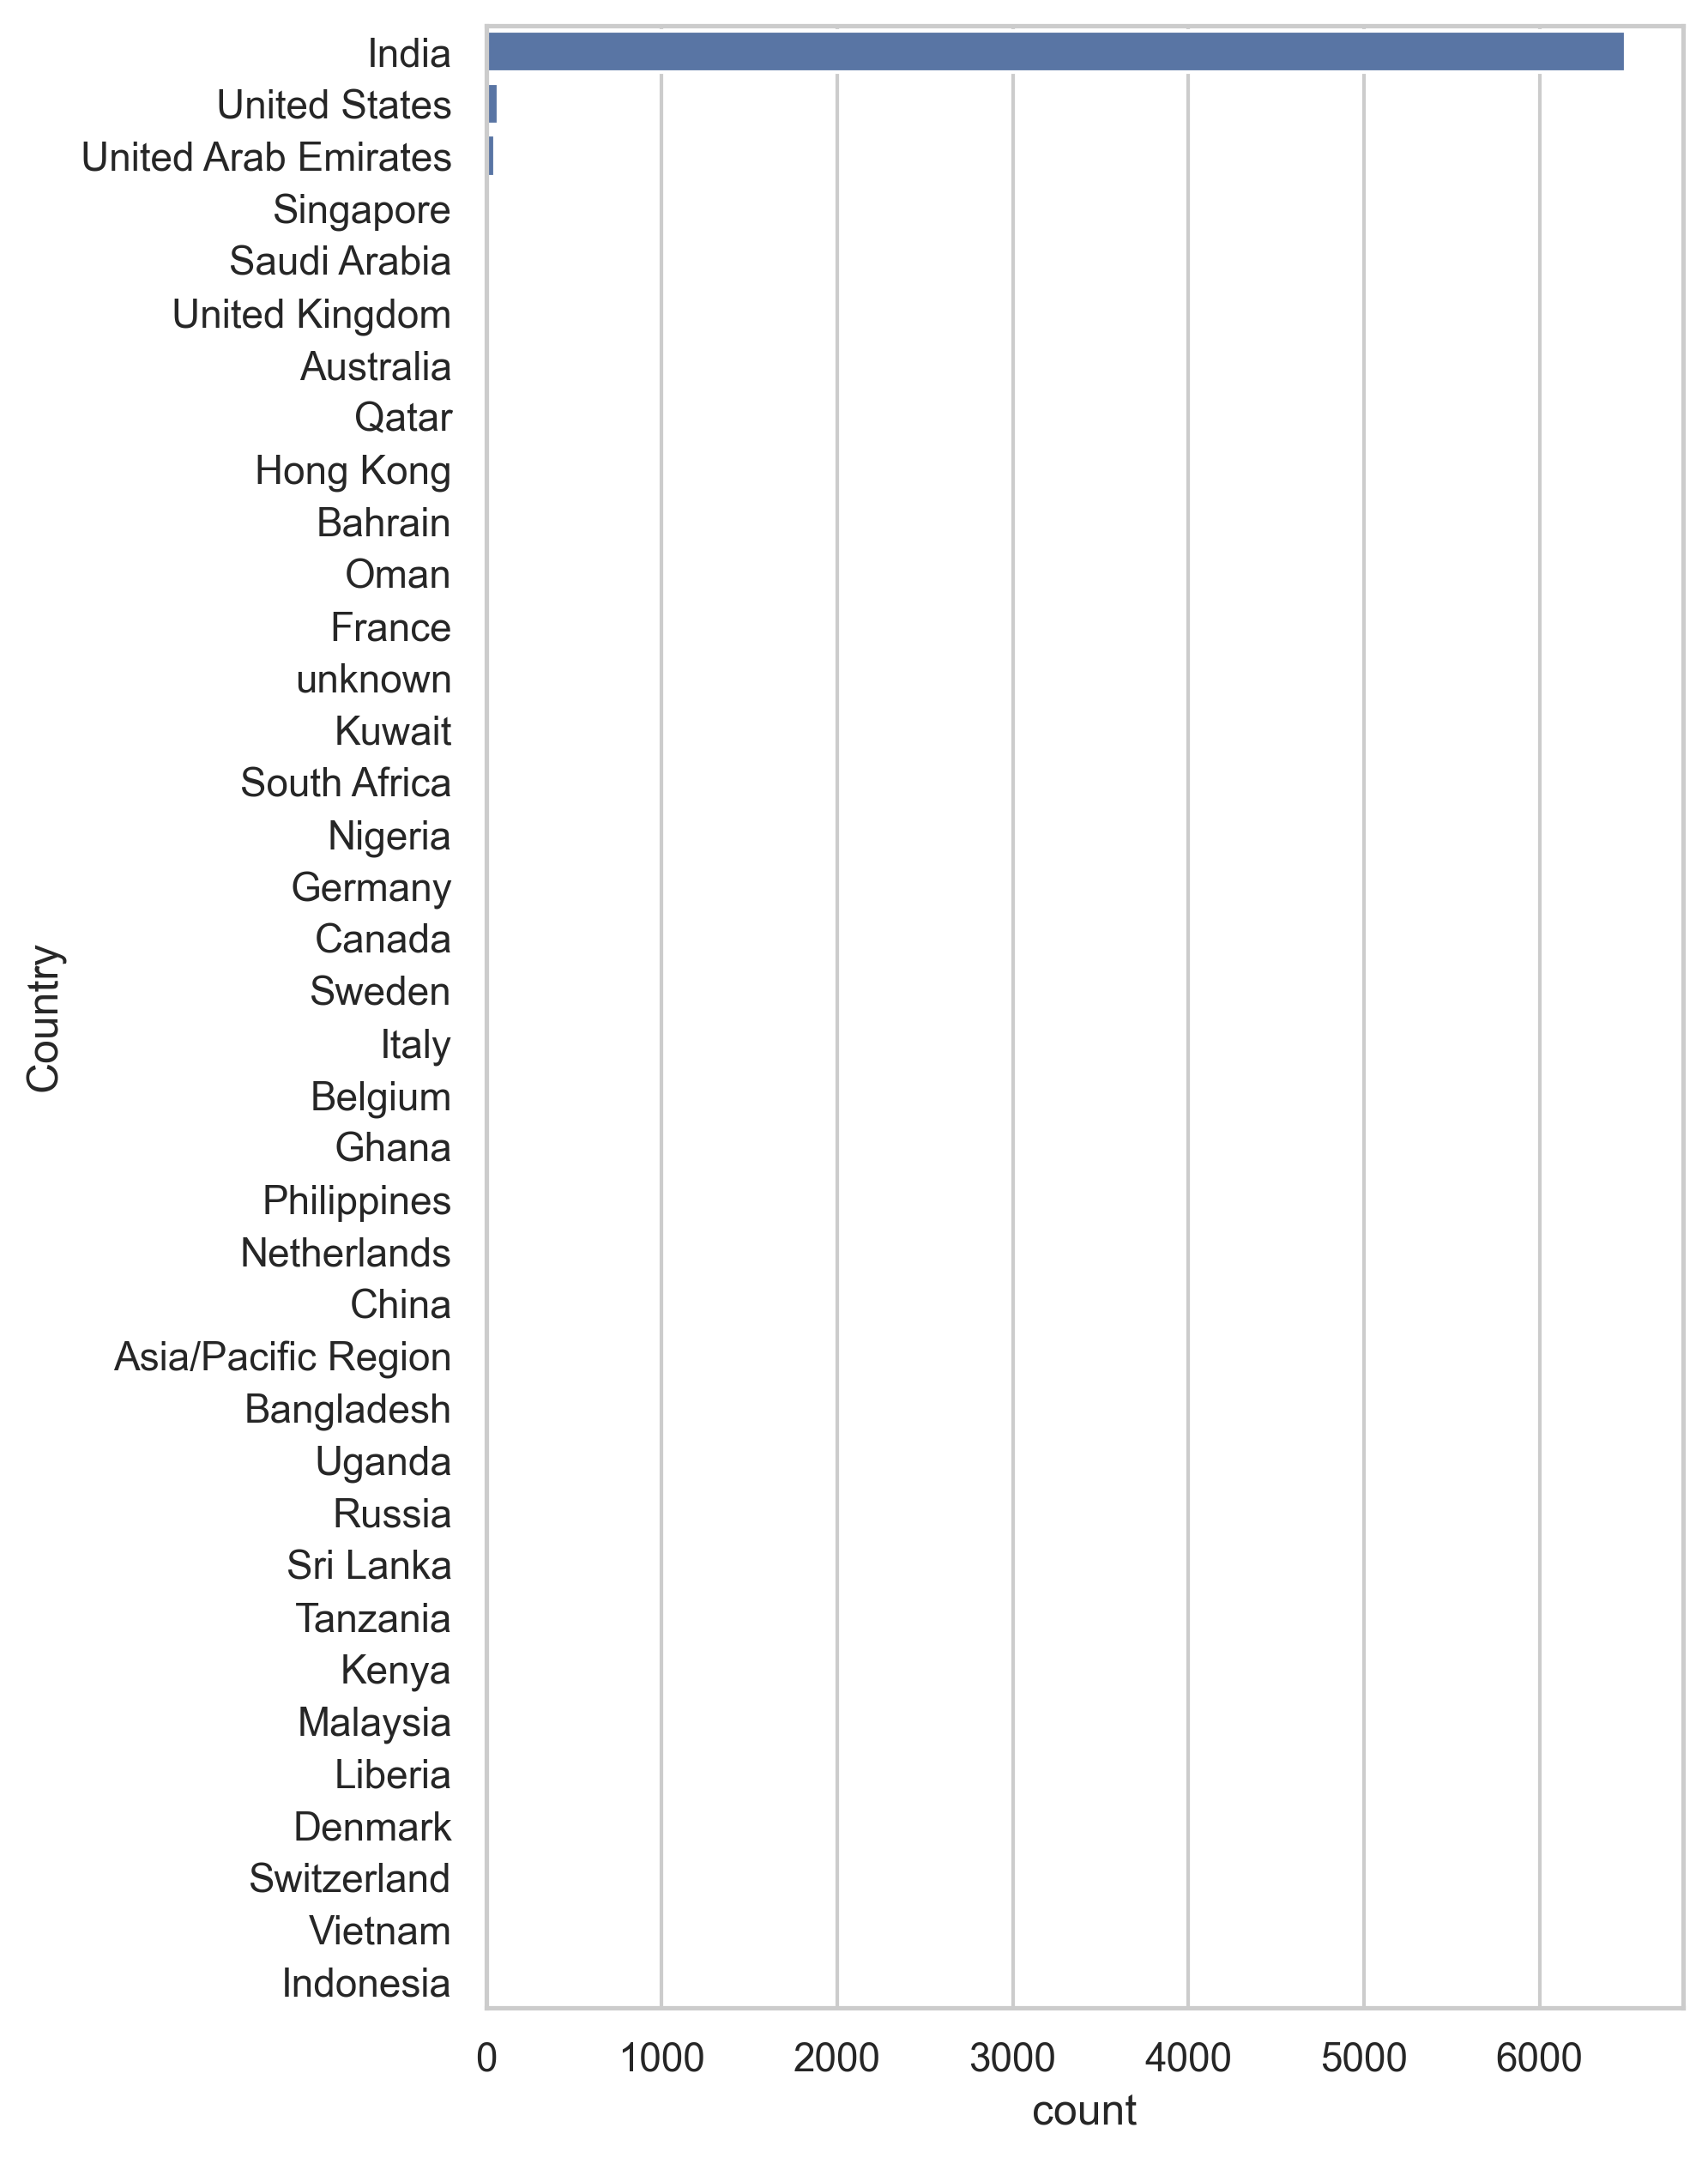

In [118]:
plt.figure(figsize = (6, 10), dpi = 300)
sns.countplot(y='Country', data = df, order = df['Country'].value_counts().index)

## Manejo de Datos Faltantes

En este caso particular, el número de datos faltantes supera una cuarta parte del total. Además, más de dos terceras partes de los registros pertenecen a la India. 

Dado este contexto, asignar simplemente el valor **'Desconocido'** a los datos faltantes no sería ideal, especialmente cuando existe una alta probabilidad de que estos registros correspondan a la India. Afortunadamente, contamos con otra variable, **'City'**, que puede ser utilizada para deducir con mayor precisión el país de los registros faltantes.

Este enfoque nos permite reducir la incertidumbre en los datos, mejorar la calidad del análisis y evitar la pérdida de información valiosa derivada de una asignación genérica. La combinación de múltiples variables para inferir datos faltantes es una estrategia más robusta y confiable en la gestión de datos incompletos.


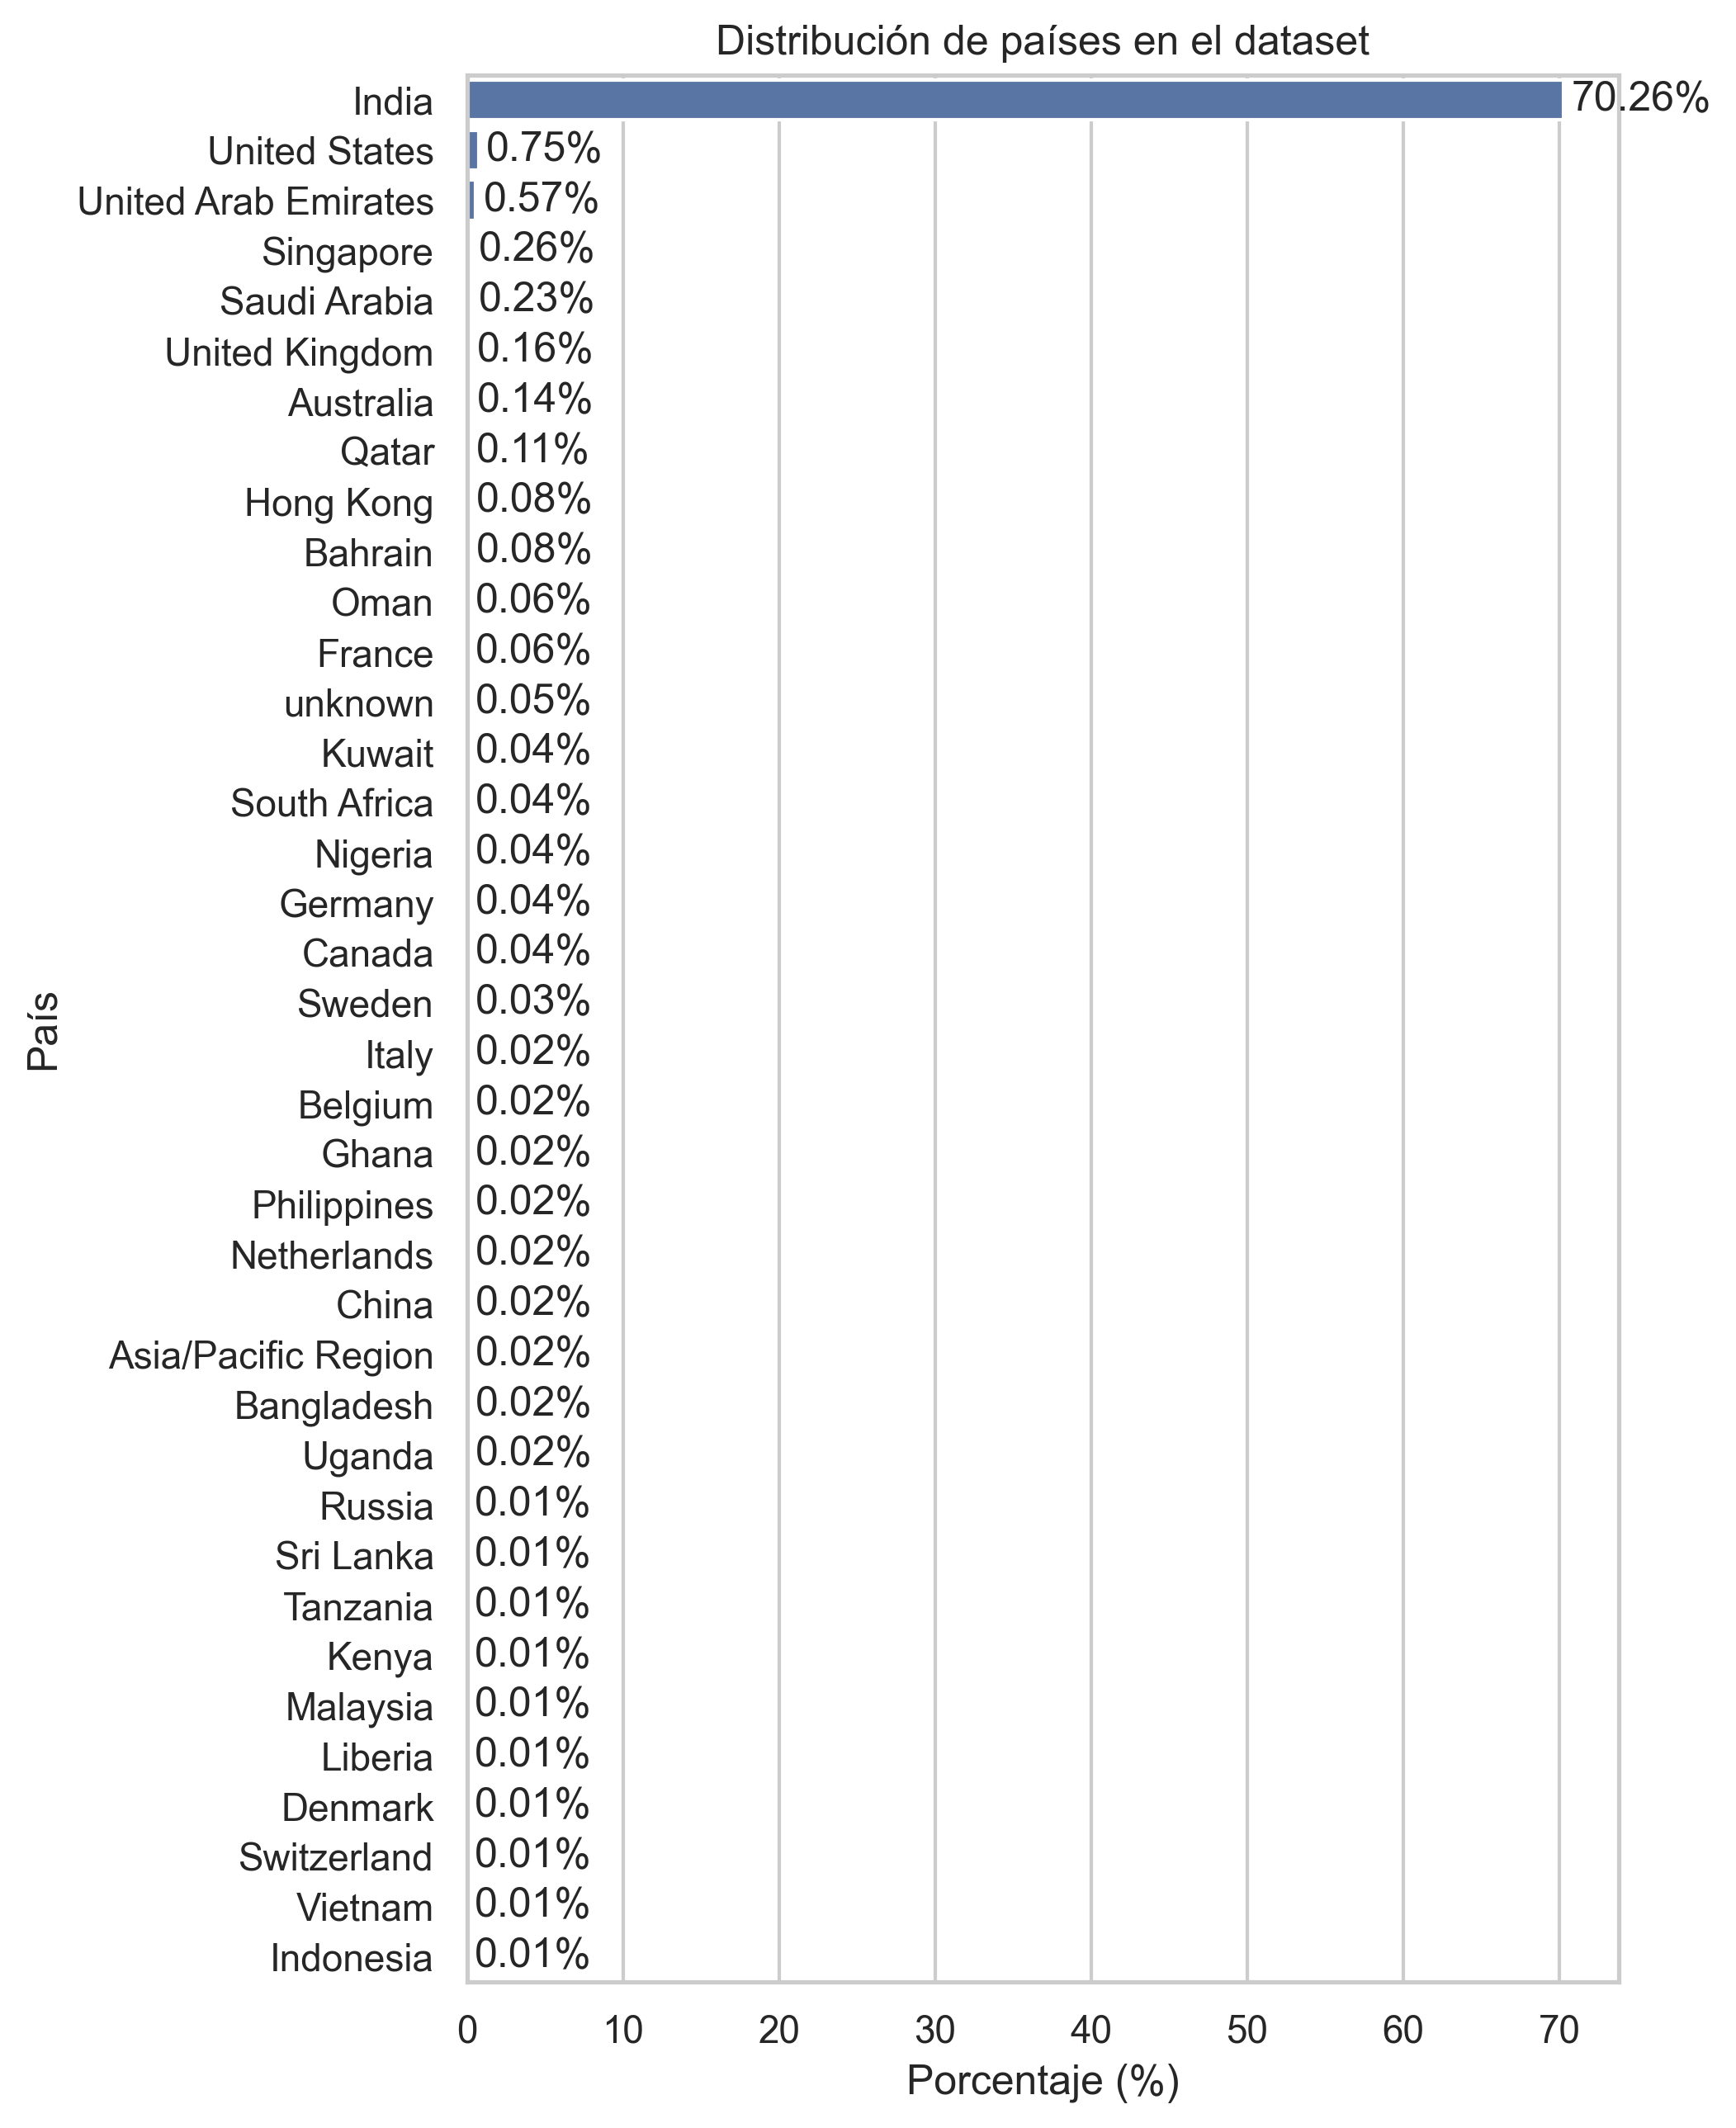

In [119]:

# Calcular porcentajes
total = len(df)  # Total de registros
country_counts = df['Country'].value_counts()
country_percentages = (country_counts / total) * 100

# Crear gráfico
plt.figure(figsize=(6, 10), dpi=300)
sns.barplot(
    y=country_counts.index,
    x=country_percentages,
    order=country_counts.index
)

# Etiquetas
plt.xlabel('Porcentaje (%)')
plt.ylabel('País')
plt.title('Distribución de países en el dataset')

# Agregar porcentajes sobre las barras
for index, value in enumerate(country_percentages):
    plt.text(value + 0.5, index, f'{value:.2f}%', va='center')

plt.show()


### Grafiquemos la distribución de 'City' cuando 'Country' es un dato faltante

<Axes: xlabel='count', ylabel='City'>

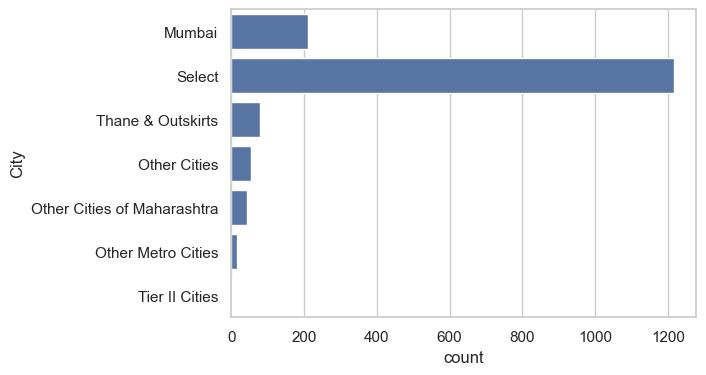

In [120]:
plt.figure(figsize=(6, 4))
sns.countplot(y='City', data = df[df['Country'].isna()], order = df['City'].value_counts().index)

## Análisis de las Ciudades Asociadas a la India

A continuación, se presenta una descripción de las ciudades y categorías que aparecen en el dataset y que están asociadas a la India. Estas categorías reflejan diferentes niveles de urbanización y distribución geográfica dentro del país.

| **Ciudad/Categoría**             | **Descripción**                                                                                                  |
|-----------------------------------|------------------------------------------------------------------------------------------------------------------|
| **Mumbai**                       | Es una ciudad muy conocida y una de las principales metrópolis de la India.                                      |
| **Thane & Outskirts**            | Thane es una ciudad ubicada cerca de Mumbai, dentro del estado de Maharashtra, India.                           |
| **Other Cities of Maharashtra**  | Incluye otras ciudades importantes del estado de Maharashtra, India.                                            |
| **Other Metro Cities**           | Esta categoría podría agrupar ciudades metropolitanas relevantes, pero no está claro si son exclusivamente de la India. |
| **Tier II Cities**               | Representa ciudades más pequeñas en términos de población y desarrollo. No se puede asumir que todas están ubicadas en la India. |
| **Select**                       | Esta categoría probablemente representa un valor predeterminado o vacío, utilizado cuando no se especificó una ciudad. |

### Nota sobre las Categorías

1. **"Select"**: Esta categoría parece ser un valor predeterminado registrado cuando no se seleccionó o especificó una ciudad durante la captura de datos. Esto indica que la información asociada a estos registros es incompleta y puede requerir análisis adicional antes de imputar el país correspondiente.
2. **"Other Metro Cities" y "Tier II Cities"**: Aunque podrían estar asociadas a la India, no existe suficiente evidencia para confirmarlo. Estas categorías requieren validación adicional antes de asumir una relación directa con un país específico.

### Observaciones

1. **Distribución geográfica**: Las ciudades confirmadas, como **Mumbai**, **Thane & Outskirts**, y **Other Cities of Maharashtra**, están claramente ubicadas en la India.
2. **Clasificación por desarrollo**: Las categorías como "Other Metro Cities" y "Tier II Cities" parecen estar basadas en niveles de urbanización y tamaño poblacional, pero su ubicación específica no está clara.
3. **Relación con valores faltantes**: Si las ciudades mencionadas aparecen en registros donde el valor de `Country` es nulo, debe realizarse una validación cuidadosa antes de imputar **India** como país para las categorías inciertas.

### Propuesta de acción

Dado que **Mumbai**, **Thane & Outskirts**, y **Other Cities of Maharashtra** tienen una conexión clara con la India, se pueden imputar como **"India"** en registros con valores faltantes en `Country`. Para las demás categorías, como **"Other Metro Cities"** y **"Tier II Cities"**, es mejor dejarlas sin imputar hasta tener evidencia adicional.

Se recomienda manejar **"Select"** como un valor que indica ausencia de información y no asumir ninguna imputación hasta realizar un análisis más profundo.


In [121]:
indian_cities = ['Mumbai', 'Thane & Outskirts', 'Other Cities of Maharashtra']

null_country_india = df[(df['Country'].isna()) & (df['City'].isin(indian_cities))]
print(null_country_india.shape[0])  # Número de registros


334


## Visualización de los Casos

La lógica de imputación de valores para la columna **`Country`** puede dividirse en tres bloques principales, dependiendo de las condiciones evaluadas:

### **Caso 1**
- **Condición**: Si `Country` es nulo (`NaN`) y la ciudad (`City`) está en la lista `indian_cities`.
- **Acción**: Asignar el valor `'India'`.
- **Ejemplo**:
  - Entrada: `Country = NaN`, `City = 'Mumbai'`
  - Resultado: `Country = 'India'`

### **Caso 2**
- **Condición**: Si `Country` es nulo (`NaN`) pero la ciudad (`City`) **no** está en la lista `indian_cities`.
- **Acción**: Asignar el valor `'Desconocido'`.
- **Ejemplo**:
  - Entrada: `Country = NaN`, `City = 'Unknown City'`
  - Resultado: `Country = 'Desconocido'`

### **Caso 3**
- **Condición**: Si `Country` ya tiene un valor (no es nulo).
- **Acción**: Conservar el valor actual en `Country`.
- **Ejemplo**:
  - Entrada: `Country = 'USA'`, `City = 'New York'`
  - Resultado: `Country = 'USA'`

### Resumen de la lógica
| **Condición**                                  | **Resultado**     |
|-----------------------------------------------|-------------------|
| `Country` es nulo y `City` está en `indian_cities` | `'India'`         |
| `Country` es nulo y `City` no está en `indian_cities` | `'Desconocido'`   |
| `Country` ya tiene un valor (no es nulo)      | Conservar valor   |


In [122]:
df['Country'] = df.apply(
    lambda row: 'India' if pd.isna(row['Country']) and row['City'] in indian_cities 
    else ('Desconocido' if pd.isna(row['Country']) else row['Country']), 
    axis=1                                                                   #todas la filas de la columna country
)


## Corrección de Tipo de Datos

Las siguientes características indican si un cliente ha interactuado con un anuncio a través de diferentes medios. Estas características se convertirán en valores booleanos para facilitar su manipulación, interpretación y uso en modelos de machine learning.

| **Característica**                                | **Descripción**                                                                                              |
|---------------------------------------------------|--------------------------------------------------------------------------------------------------------------|
| **Search**                                       | Indica si el cliente ha visto el anuncio durante una búsqueda en la web.                                    |
| **Magazine**                                     | Indica si el cliente ha visto el anuncio en una revista.                                                    |
| **Newspaper Article**                            | Indica si el cliente ha visto el anuncio en un artículo de periódico.                                       |
| **X Education Forums**                           | Indica si el cliente ha visto el anuncio en un foro de X Education.                                         |
| **Newspaper**                                    | Indica si el cliente ha visto el anuncio en un periódico.                                                   |
| **Digital Advertisement**                        | Indica si el cliente ha visto el anuncio en un anuncio digital.                                             |
| **Through Recommendations**                     | Indica si el cliente llegó a través de recomendaciones.                                                     |
| **Receive More Updates About Our Courses**       | Indica si el cliente eligió recibir más actualizaciones sobre los cursos.                                   |

### Observaciones

- Las variables son similares y no tienen valores faltantes.
- Les daremos un tratamiento similar, convirtiéndolas a valores booleanos.

### Objetivo
- Convertir estas características en valores booleanos para que sean más fáciles de manipular, interpretar y utilizar en un modelo.


In [123]:
# Lista de columnas a convertir
columns_to_convert = ['Search', 'Magazine', 'Newspaper Article', 'X Education Forums', 
                      'Newspaper', 'Digital Advertisement', 'Through Recommendations', 
                      'Receive More Updates About Our Courses']

# Convertir 'Yes' y 'No' a valores booleanos
for c in columns_to_convert:
    df[c] = df[c].map({'Yes': True, 'No': False})


In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9240 entries, 660737 to 579533
Data columns (total 35 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9240 non-null   object 
 2   Do Not Email                                   9240 non-null   bool   
 3   Do Not Call                                    9240 non-null   bool   
 4   Converted                                      9240 non-null   int64  
 5   TotalVisits                                    9240 non-null   float64
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9240 non-null   float64
 8   Last Activity                                  9240 non-null   object 
 9   Country                                        924

## Complejidades de las Variables de Formulario

En esta sección, abordaremos el análisis y preparación de las variables relacionadas con el formulario. Este proceso es fundamental para entender mejor cómo interactúan los clientes potenciales con nuestro sistema y para preparar los datos para el modelo de predicción. A continuación, se detallan los pasos que seguiremos:

### 1. Examinar Distribución de Variables
Analizaremos la distribución de las siguientes variables:
- **Specialization**
- **How did you hear about X Education**
- **What is your current occupation**
- **What matters most to you in choosing a course**

Este análisis nos permitirá comprender mejor cómo los clientes potenciales interactúan con el formulario y cuáles son sus preferencias.

---

### 2. Manejo de Valores Faltantes o "Select"
Los valores etiquetados como **"Select"** no aportan información relevante sobre la categoría del cliente, por lo que los trataremos como datos faltantes. Nuestro enfoque será:
- Reemplazar los valores **"Select"** y los valores nulos con la categoría **"Desconocido"**.
- Esto mantiene la integridad de los datos y evita sesgos en los análisis posteriores.

---

### 3. Conversión de Variables de Texto en Booleanas
Para simplificar el análisis, convertiremos las siguientes variables en valores booleanos (`True`/`False`):
- **Update me on Supply Chain Content**
- **Get updates on DM Content**

---

### 4. Eliminación de Variables Redundantes
Algunas variables serán eliminadas por las siguientes razones:
- **Tags**: Está directamente relacionada con el estado de conversión del cliente, lo que podría introducir sesgos en nuestro modelo.
- **Lead Quality**: Será reemplazada por un sistema más robusto de puntuación, el **Lead Score**.

---

### 5. Importancia del Proceso
Este proceso meticuloso de limpieza y preparación de datos es crucial para:
- Capturar el comportamiento y las tendencias reales de los clientes potenciales.
- Asegurar que el modelo de predicción sea preciso y confiable.

Al preparar cuidadosamente estas variables, aseguramos que nuestro análisis y modelo reflejen fielmente los patrones y preferencias de nuestros clientes.





## Explicación de `flat` en Matplotlib

Cuando usamos `plt.subplots` con más de una fila y columna, el objeto `ejes` que contiene los subgráficos se organiza como una **matriz bidimensional**. Esto puede dificultar la iteración directa sobre los subgráficos. La propiedad **`flat`** convierte esta matriz en un iterador unidimensional, facilitando el acceso a cada subgráfico.

| **Sin `flat` (matriz bidimensional)**                | **Con `flat` (iterador unidimensional)**       |
|------------------------------------------------------|-----------------------------------------------|
| **Estructura:**                                      | **Estructura:**                               |
| `[<AxesSubplot:>, <AxesSubplot:>]`                   | `<AxesSubplot:>`                              |
| `[<AxesSubplot:>, <AxesSubplot:>]`                   | `<AxesSubplot:>`                              |
|                                                     | `<AxesSubplot:>`                              |
|                                                     | `<AxesSubplot:>`                              |
| **Cómo iterar:**                                     | **Cómo iterar:**                              |
| Recorres filas de subgráficos:                      | Recorres cada subgráfico directamente:        |
| ```python                                           | ```python                                     |
| for fila in ejes:                                   | for ax in ejes.flat:                          |
|     for ax in fila:                                 |     # Usas cada subgráfico individualmente    |
|         # Usas cada subgráfico individualmente      | ```                                           |
| ```                                                 |                                               |

### **Ventajas de `flat`**
1. Permite acceder a todos los subgráficos como un iterador lineal, sin importar cómo están organizados.
2. Es ideal para casos donde necesitas aplicar operaciones de manera uniforme a todos los subgráficos.

### **Nota**
`flat` es una propiedad de los ejes y no requiere importar módulos adicionales, lo que lo hace práctico para iterar sobre los subgráficos.



### Examinenos la distribución de las variables de formulario. Vamos a hacer una lista de las 4 variables, y luego haremos un lazo for para graficarlas como subplots.

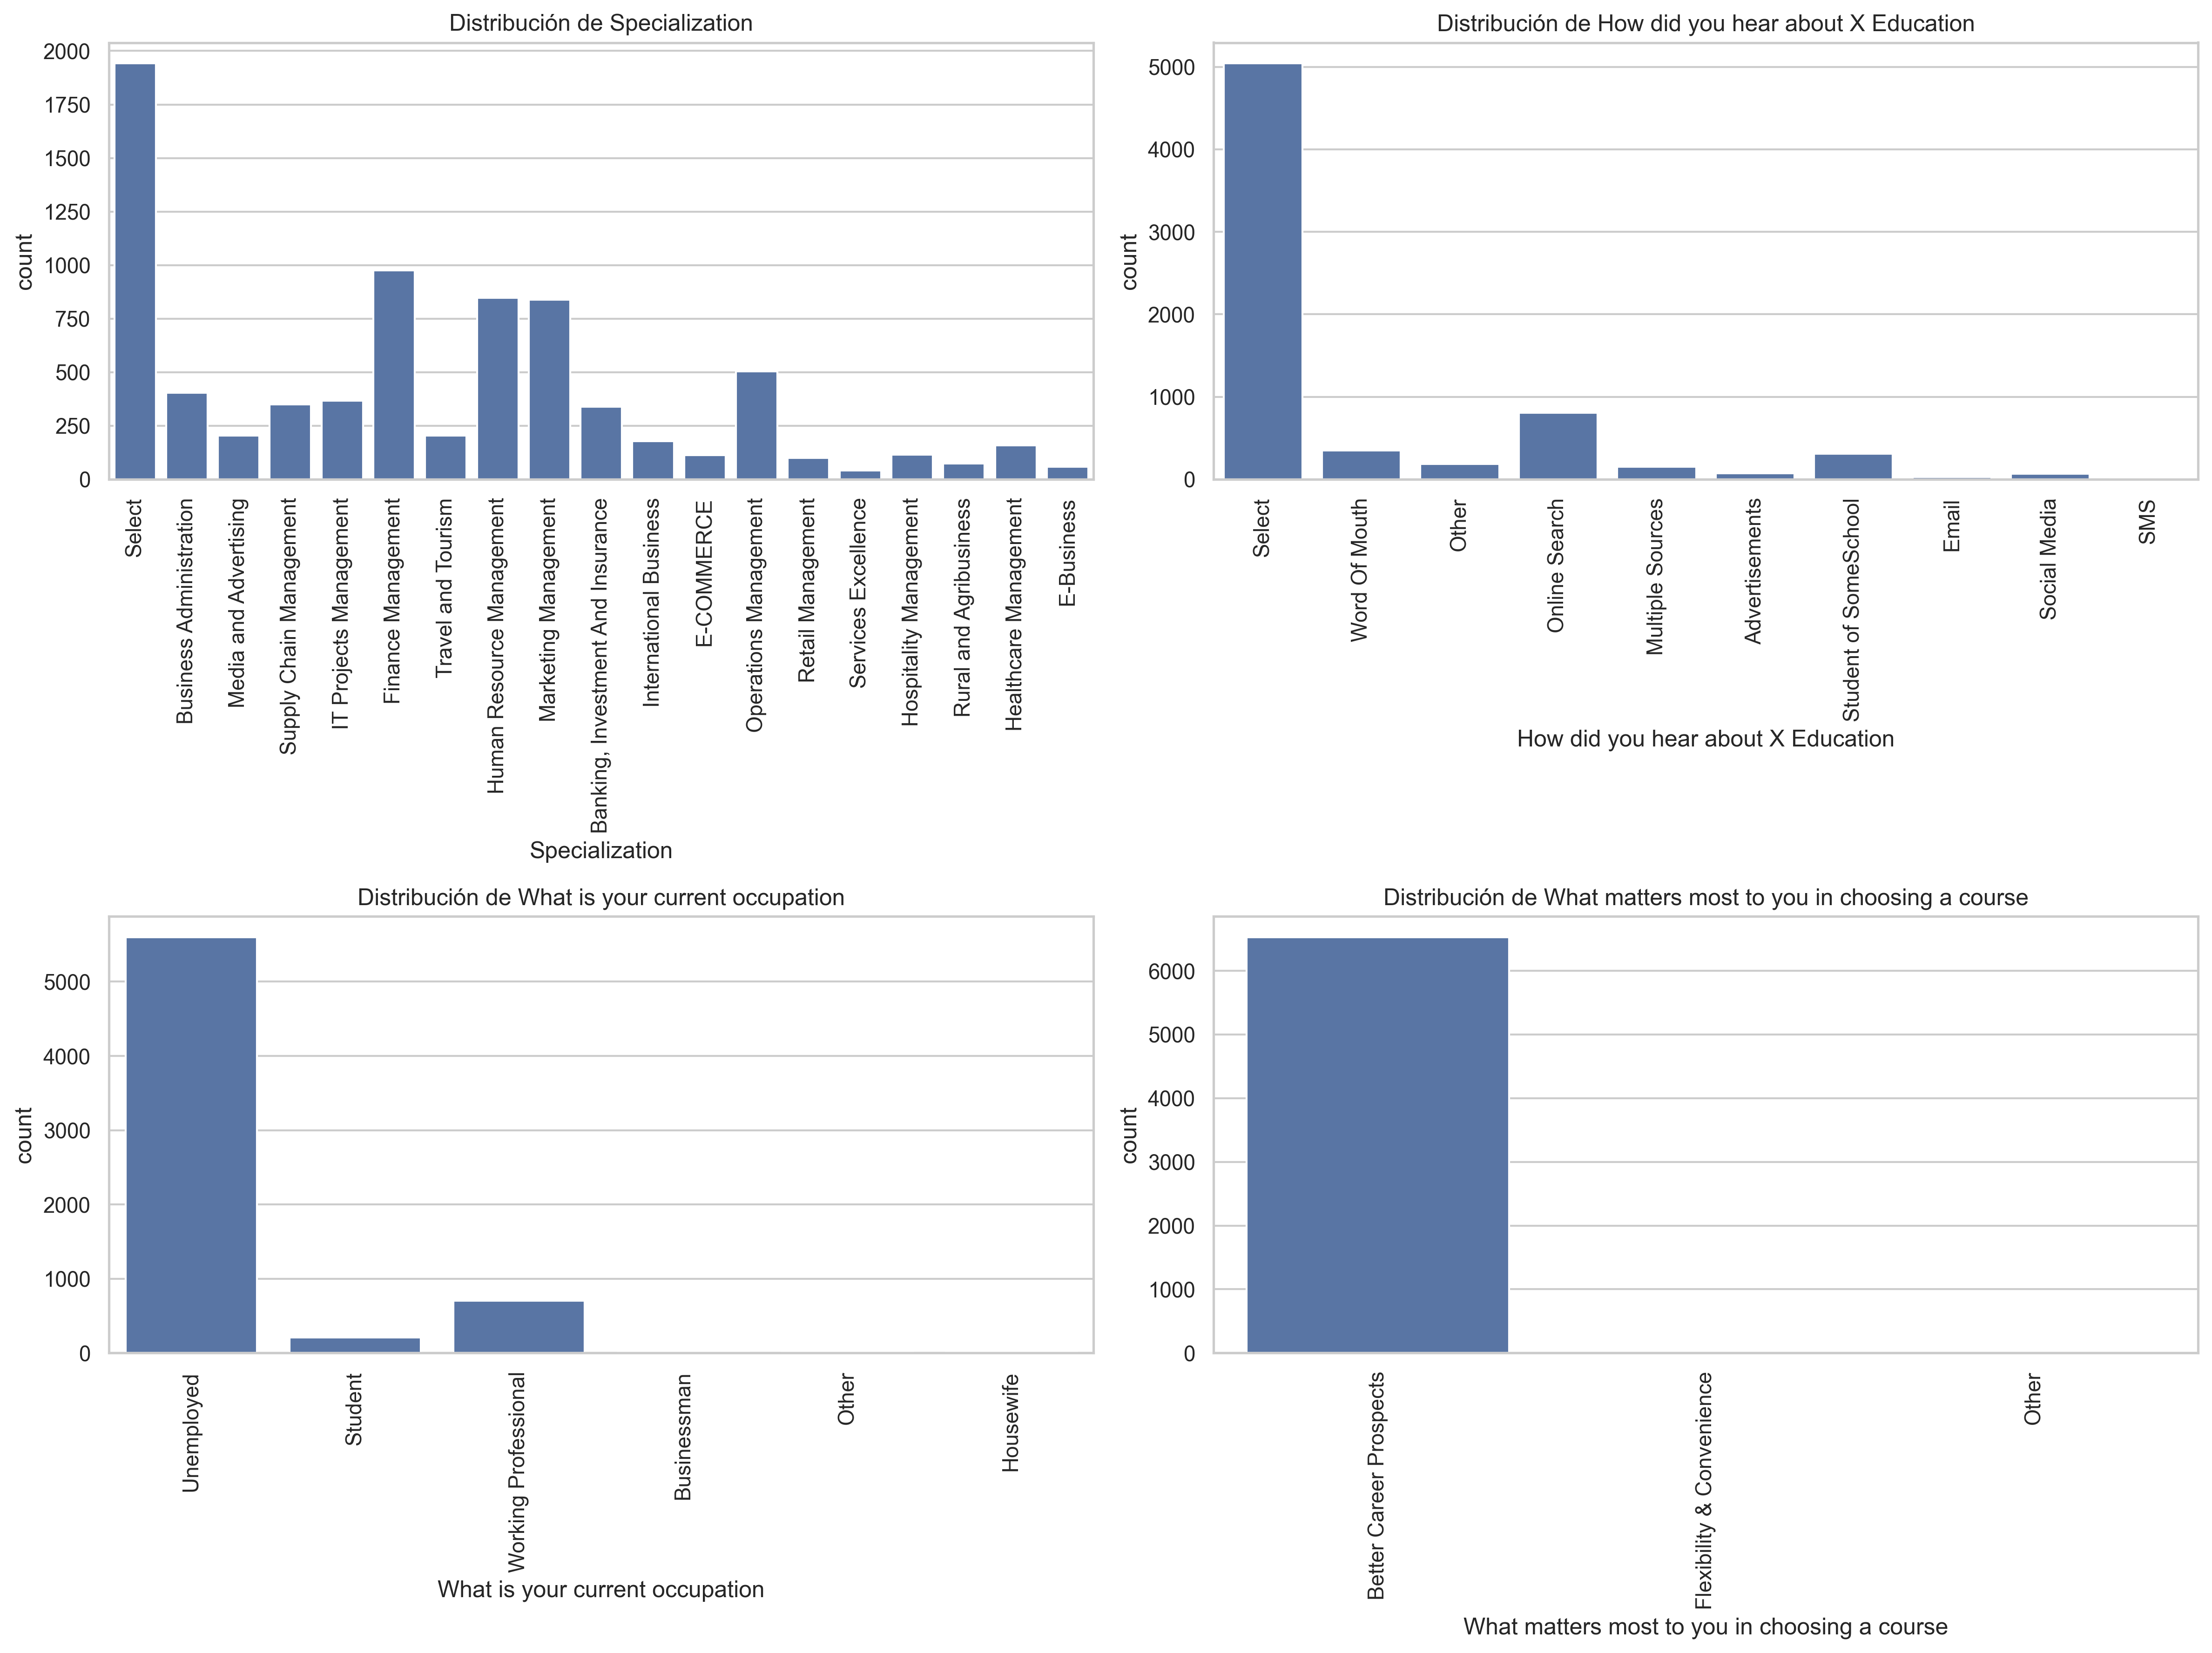

In [125]:
# Configurar una cuadrícula de 2 filas y 2 columnas
fig, ejes = plt.subplots(nrows=2, ncols=2, figsize=(16, 12), dpi=300)

# Lista de variables
variables = ['Specialization', 'How did you hear about X Education', 
             'What is your current occupation', 'What matters most to you in choosing a course']

# Recorrer cada variable y graficarla
for i, ax in enumerate(ejes.flat):                         # Flatten para iterar sobre todos los ejes
    sns.countplot(x=variables[i], data=df, ax=ax)
    ax.tick_params(axis='x', rotation=90)                  # Rotar etiquetas del eje x de forma segura
    ax.set_title(f"Distribución de {variables[i]}")        # Títulos individuales

plt.tight_layout()  # Ajustar los espacios entre los gráficos
plt.show()


## Análisis de la Distribución de Variables Categóricas

En los gráficos generados, observamos la distribución de valores para varias variables categóricas en el conjunto de datos. Estas distribuciones son útiles para identificar patrones y problemas relacionados con valores faltantes o categorías predominantes. Un análisis detallado se presenta a continuación:

### 1. Etiqueta "Select"
En varias variables categóricas, un gran número de observaciones tienen la etiqueta **"Select"**. Esta etiqueta a menudo se utiliza en formularios de entrada de datos para indicar que el usuario no seleccionó ninguna de las opciones disponibles. En el contexto del análisis de datos, los valores **"Select"** son equivalentes a valores nulos o faltantes, ya que no proporcionan información relevante sobre la categoría real.

---

### 2. Análisis de la Variable 'What matters most to you in choosing a course'
En el gráfico de esta variable (ubicado a la derecha), observamos que la categoría **"Better Career Prospects"** domina claramente sobre las demás, como **"Flexibility & Convenience"** y **"Others"**. Esto indica que la mayoría de los encuestados priorizan las perspectivas de carrera al elegir un curso.

#### Posible imputación basada en la moda:
- En este caso, imputar valores faltantes con la categoría **"Better Career Prospects"** sería razonable, ya que refleja la preferencia predominante de los encuestados.
- Sin embargo, para mantener la coherencia y evitar sesgos potenciales, hemos decidido asignar el valor **"Desconocido"** a los datos faltantes, incluyendo la etiqueta "Select".

Aunque **"What matters most to you in choosing a course"** es un claro ejemplo donde la imputación con la moda sería justificada, preferimos optar por un enfoque conservador y consistente para preservar la integridad del análisis.

---

### 3. Proceso de Imputación
- Todas las observaciones con valores **"Select"** o nulos en las variables categóricas serán reemplazadas por el valor **"Desconocido"**.
- Este enfoque asegura que los datos permanezcan consistentes y completos para el modelo de predicción.






### Código para la Imputación

In [126]:
# Variables categóricas a imputar

# Reemplazar "Select" y valores nulos con "Desconocido"
for col in variables:
    df[col] = df[col].replace('Select', 'Desconocido').fillna('Desconocido')

## Corrección de Tipo de Datos: Actualizaciones de Contenido

Las siguientes características indican si el cliente desea recibir actualizaciones sobre contenido específico. Estas características se convertirán en valores booleanos para facilitar su manipulación, interpretación y uso en modelos de machine learning:

| **Característica**                    | **Descripción**                                                                                     |
|---------------------------------------|-----------------------------------------------------------------------------------------------------|
| **Update me on Supply Chain Content** | Indica si el cliente desea recibir actualizaciones sobre el contenido de la cadena de suministro.   |
| **Get updates on DM Content**         | Indica si el cliente desea recibir actualizaciones sobre el contenido de DM.                       |

### **Objetivo**
Convertir estas características en valores booleanos (`True`/`False`) para simplificar su uso en el análisis y el modelo de predicción.


In [127]:
# Lista de variables a convertir
boolean_vars = ['Update me on Supply Chain Content', 'Get updates on DM Content']


# Convertir 'Yes' en True y 'No' en False usando apply
for col in boolean_vars:
    df[col] = df[col].apply(lambda x: True if x == 'Yes' else False)


## Eliminación de Variable: **Tags**

### **Descripción**
- **Tags**: Son etiquetas asignadas a los clientes que indican el estado actual del cliente potencial a medida que avanza a través del embudo de marketing.

Dado que **Tags** está determinado por el progreso de un cliente potencial dentro del embudo de marketing, es probable que sea **endógeno** al estado de conversión del cliente. Por lo tanto, esta característica no debería incluirse en el modelo de predicción.

---

### **¿Qué significa "endógeno"?**
El término **"endógeno"** se refiere a factores o variables que se originan dentro de un sistema determinado, a diferencia de las variables **"exógenas"**, que provienen de fuera del sistema.

En el contexto de un modelo estadístico o de machine learning:
- Una **variable endógena** es aquella cuyo valor está influenciado por otras variables dentro del modelo.
- Esto la hace problemática si queremos que el modelo sea independiente y generalizable, ya que estas variables pueden estar directamente relacionadas con lo que estamos intentando predecir.

---

### **Relación de Tags con la conversión**
En el caso de **Tags**:
1. **Dependencia interna**: 
   - Esta variable se asigna a medida que el cliente avanza a través del embudo de marketing.
   - Está estrechamente relacionada con la probabilidad de conversión del cliente potencial (la variable objetivo que queremos predecir).

2. **Problema de predicción**:
   - Si incluimos **Tags** como una variable en el modelo, estaríamos indirectamente usando información que está vinculada a la conversión, lo que sesgaría los resultados y haría que el modelo fuera menos robusto.
   - Esto significa que **Tags** es tanto una **consecuencia** como una **parte del proceso de conversión**, lo que la convierte en una variable endógena.

3. **Decisión**:
   - Por estas razones, eliminaremos **Tags** del conjunto de datos antes de construir el modelo.

---

### **Ejemplo Teórico**

Si queremos predecir la conversión de un cliente potencial en un modelo de machine learning:

- Una **variable exógena** sería algo independiente, como:
  - La **edad del cliente**: No cambia en función de si el cliente compra o no.
  - El **nivel educativo**: También es independiente del proceso de conversión.

- Una **variable endógena**, como **Tags**, está influenciada por interacciones previas del cliente en el embudo de marketing y está directamente relacionada con la probabilidad de conversión.

#### **Otro ejemplo: El carrito de compras**
Supongamos que queremos predecir si un cliente comprará un producto:
- La **edad del cliente** sería una variable exógena, porque no depende de si el cliente realiza la compra.
- El **número de productos en el carrito** sería una variable endógena:
  - Si el cliente tiene varios productos en el carrito, esto ya refleja que está más cerca de comprar.
  - El número de productos en el carrito no es independiente; está relacionado con la conversión misma.

En el caso de **Tags**, al igual que el carrito, refleja el progreso del cliente dentro del proceso de conversión. Esto lo hace una variable endógena, ya que contiene información que está directamente relacionada con la variable objetivo (conversión), lo que podría sesgar el modelo.




## Conclusión

Eliminar variables endógenas, como **Tags**, es un paso crucial para asegurar la independencia y la validez del modelo de predicción. Este enfoque garantiza que el modelo no esté influenciado por información que ya está determinada por la variable objetivo, evitando sesgos y asegurando resultados más confiables y generalizables.



In [128]:
# Eliminamos la columna 'Tags' del DataFrame
df = df.drop(columns=['Tags'])

## Eliminación de Variable: **Lead Quality**

### **Descripción**
- **Lead Quality**: Esta variable indica la calidad del cliente potencial, evaluada subjetivamente por el empleado asignado al mismo.

### **Razón para eliminarla**
La variable **Lead Quality** no se incluirá en el modelo de predicción por las siguientes razones:
1. **Reemplazo con Lead Score**:
   - Estamos diseñando el **Lead Score** como una métrica más robusta y objetiva para medir la calidad del cliente potencial.
   - **Lead Quality** es redundante, ya que su propósito será cubierto por la nueva variable **Lead Score**.

2. **Subjetividad**:
   - **Lead Quality** es subjetiva, ya que depende de la intuición o evaluación personal del empleado.
   - Esto puede introducir sesgos en el modelo y afectar la generalización de los resultados.

3. **Endogeneidad**:
   - En muchos casos, **Lead Quality** puede estar relacionada con el estado de conversión del cliente, lo que la hace endógena al modelo.
   - Esto significa que su valor está influenciado por el proceso que queremos predecir, lo que puede sesgar los resultados.

### **Conclusión**
Eliminar **Lead Quality** nos permite trabajar con datos más objetivos y evitar redundancias en nuestro modelo. Esto asegura que las predicciones estén basadas en variables más confiables y generalizables.


In [129]:
# Eliminamos la columna 'Lead Quality' del DataFrame
df = df.drop(columns=['Lead Quality'])

In [130]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9240 entries, 660737 to 579533
Data columns (total 33 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Lead Origin                                    9240 non-null   object 
 1   Lead Source                                    9240 non-null   object 
 2   Do Not Email                                   9240 non-null   bool   
 3   Do Not Call                                    9240 non-null   bool   
 4   Converted                                      9240 non-null   int64  
 5   TotalVisits                                    9240 non-null   float64
 6   Total Time Spent on Website                    9240 non-null   int64  
 7   Page Views Per Visit                           9240 non-null   float64
 8   Last Activity                                  9240 non-null   object 
 9   Country                                        924

## Consolidación: Manejo de Datos y Optimización

A lo largo del cuaderno, hemos venido trabajando en el manejo y optimización del conjunto de datos para asegurar que nuestro modelo predictivo sea eficiente, confiable y generalizable. En esta sección, consolidaremos y complementaremos las acciones realizadas, destacando los siguientes puntos:

---

### **1. Manejo de Nulos**
Hemos tratado valores nulos en características significativas como:
- **Lead Profile**
- **City**

#### **Acciones Realizadas:**
- Valores como **"Select"**, utilizados como predeterminados, fueron tratados como equivalentes a datos faltantes.
- Reemplazamos tanto los valores "Select" como los nulos con **"Desconocido"** para preservar la integridad de los datos.

---

### **2. Corrección de Tipo de Datos**
Trabajamos con variables binarias para convertir sus valores (`'Yes'`/`'No'`) en booleanos (`True`/`False`), lo que facilita su uso en modelos y análisis.

#### **Ejemplos de Variables:**
- **I agree to pay the amount through cheque**
- **A free copy of Mastering The Interview**

#### **Ventajas:**
- Simplificación del análisis y el preprocesamiento.
- Mejora de la claridad y consistencia en los datos.

---

### **3. Conversión de Tipos de Datos**
Optimizamos el uso de memoria transformando variables de tipo **`object`** a **`category`**. Esta conversión:
- Reduce significativamente el uso de recursos, especialmente en grandes conjuntos de datos.
- Acelera los análisis categóricos.

---

### **4. Análisis de Índices y Puntuaciones Asimétricas**
Nuevamente, profundizamos en el análisis de variables específicas, como:
- **Asymmetrique Activity Index**
- **Asymmetrique Profile Index**
- **Asymmetrique Activity Score**
- **Asymmetrique Profile Score**

#### **Objetivo:**
- Determinar si existen redundancias significativas entre los índices y las puntuaciones.
- Si los índices están altamente correlacionados con las puntuaciones, consideraremos eliminarlos para reducir ruido y simplificar el modelo.

---

### **Conclusión**
Este proceso integrado asegura que:
1. Nuestro modelo esté construido sobre datos limpios, relevantes y optimizados.
2. Se eviten redundancias, valores irrelevantes o potencialmente sesgados.
3. Cada decisión tomada refuerce la calidad del análisis y la confiabilidad de las predicciones.

En una sola sección, consolidamos todo el preprocesamiento realizado, lo que permite un enfoque claro y unificado.



#### Manejo de Nulos: Lead Profile, Lead Profile: Un nivel de lead asignado a cada cliente basado en su perfil.

### # Gráfico de Distribución de Lead Profile

<Axes: xlabel='count', ylabel='Lead Profile'>

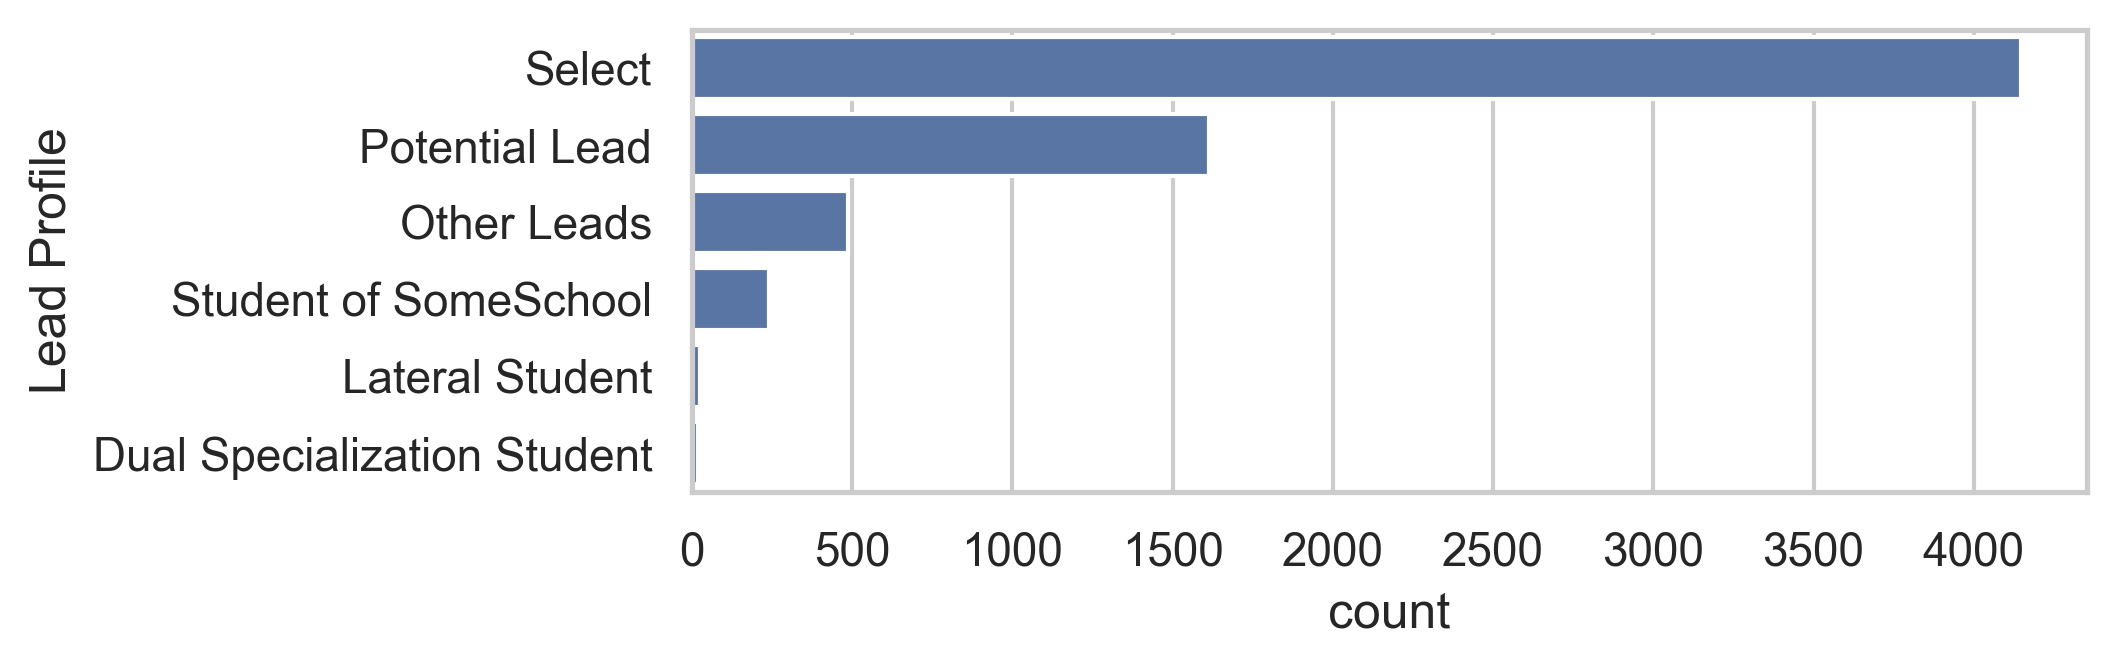

In [131]:
plt.figure(figsize = (6, 2), dpi = 300)
sns.countplot(y='Lead Profile', data = df, order = df['Lead Profile'].value_counts().index)

### Reemplacemos Select por Desconocido, rellenemos los valores faltantes con Desconocido

In [132]:
df['Lead Profile'] = df['Lead Profile'].replace('Select', 'Desconocido').fillna('Desconocido')

## Manejo de Nulos: **City**

### **Descripción de la Variable**
- **City**: Representa la ciudad del cliente potencial.

### **Importancia**
La variable **City** es una característica importante para comprender el contexto geográfico de los clientes potenciales. Sin embargo, puede contener valores nulos que deben ser tratados adecuadamente para no afectar el análisis ni el modelo predictivo.

---

### **Estrategia de Imputación**
1. **Evaluar la Distribución**:
   - Antes de imputar, analizaremos la distribución de valores en **City** para determinar si hay una categoría predominante o patrones específicos.
   
2. **Imputación**:
   - Los valores nulos (`NaN`) y aquellos etiquetados como **"Select"** (usados como predeterminados) serán tratados como datos faltantes.
   - Estos serán reemplazados por la categoría **"Desconocido"**, asegurando consistencia en el conjunto de datos.

---

### **Ventajas del Enfoque**
- Preserva la integridad de los datos.
- Evita sesgos al no asumir información no respaldada por el análisis.
- Proporciona una categoría estándar para valores faltantes, facilitando su manejo en el modelo.

---

### **Próximos Pasos**
Después de imputar los valores faltantes en **City**, confirmaremos los cambios y evaluaremos cómo esta variable afecta al análisis general del comportamiento del cliente.


<Axes: xlabel='count', ylabel='City'>

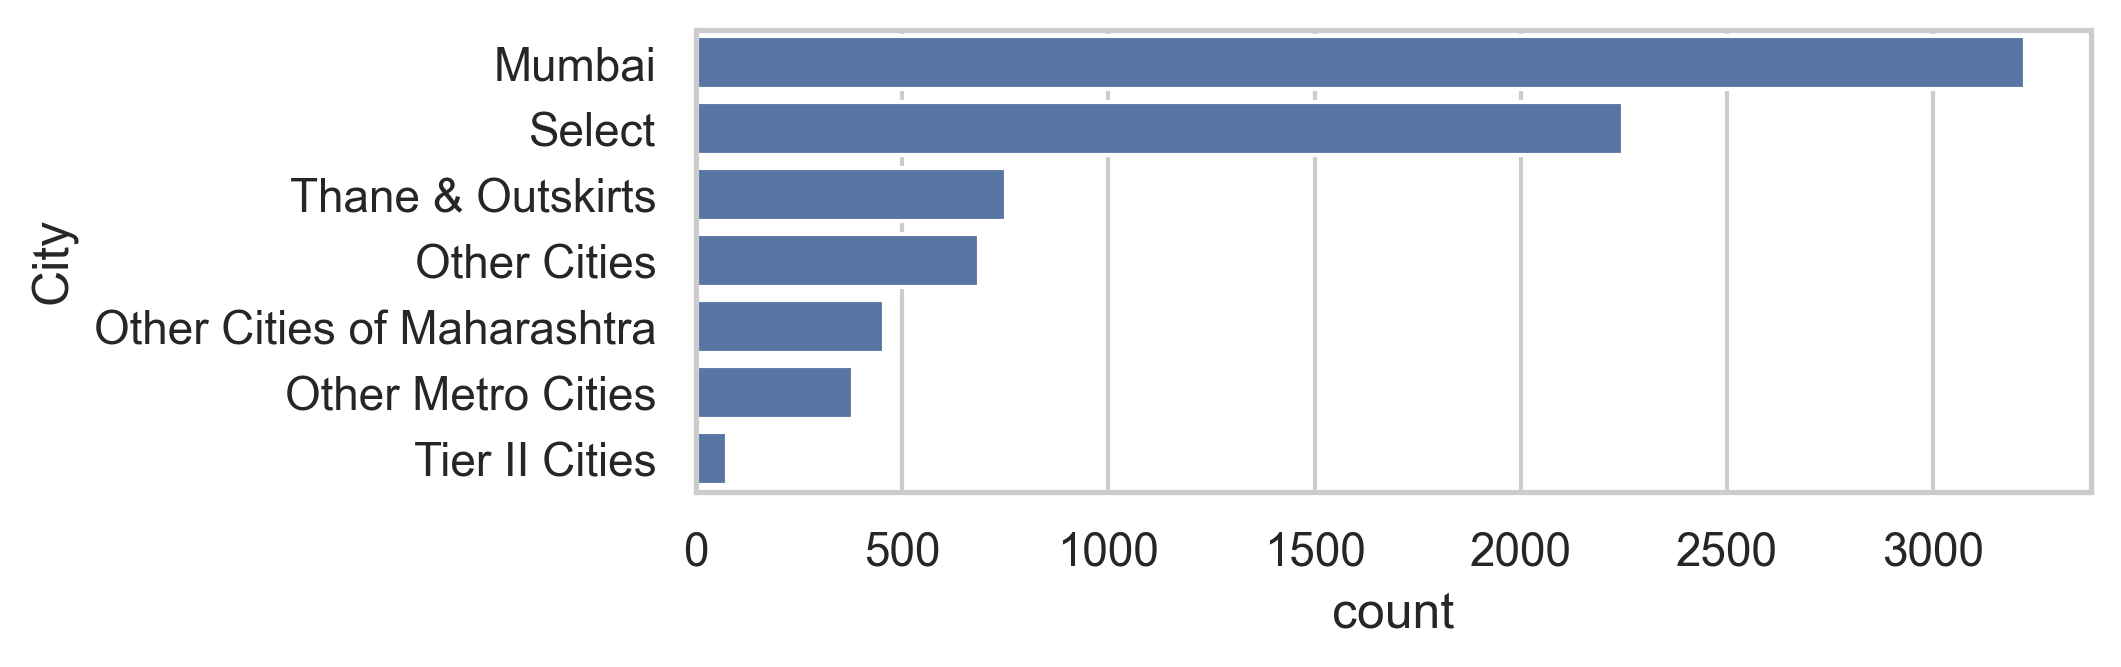

In [133]:
plt.figure(figsize = (6, 2), dpi = 300)
sns.countplot(y='City', data = df, order = df['City'].value_counts().index)

### Reemplacemos Select por Desconocido, rellenemos los valores faltantes con Desconocido

In [134]:
df['City'] = df['City'].replace('Select', 'Desconocido').fillna('Desconocido')
print("\nDistribución actualizada de City:")
print(df['City'].value_counts())


Distribución actualizada de City:
City
Desconocido                    3669
Mumbai                         3222
Thane & Outskirts               752
Other Cities                    686
Other Cities of Maharashtra     457
Other Metro Cities              380
Tier II Cities                   74
Name: count, dtype: int64


## Corrección de Tipo de Datos: Conversión a Valores Booleanos

### **Descripción de las Variables**
1. **I agree to pay the amount through cheque**:
   - Indica si el cliente ha acordado pagar el monto mediante cheque (`Yes`/`No`).

2. **A free copy of Mastering The Interview**:
   - Indica si el cliente desea recibir una copia gratuita del material **'Mastering the Interview'** (`Yes`/`No`).

---

### **Razón para la Conversión**
Estas características contienen respuestas binarias (`Yes` y `No`), las cuales pueden ser más fácilmente manipuladas, interpretadas y utilizadas en modelos predictivos al convertirlas en valores booleanos:
- **`True`** para representar `Yes`.
- **`False`** para representar `No`.

---

### **Beneficios de la Conversión**
1. Simplifica el preprocesamiento de datos.
2. Permite una manipulación más eficiente en análisis estadísticos y modelos de machine learning.
3. Mejora la claridad y consistencia de las características.

---

### **Estrategia**
Usaremos el método **`.replace()`** para transformar las respuestas binarias en valores booleanos y asegurar que el tipo de datos de las columnas sea `bool`.

---

### **Próximos Pasos**
Después de la conversión, confirmaremos los cambios revisando los valores únicos y los tipos de datos de estas columnas para garantizar la consistencia.


### Convirtamos las variables Yes/No a booleanos

In [135]:
# Convertir variables binarias a booleanos sin generar FutureWarning
binary_vars = ['I agree to pay the amount through cheque', 'A free copy of Mastering The Interview']

for c in binary_vars:
    df[c] = df[c].map({'Yes': True, 'No': False}).astype(bool)

### Corrección del tipo de datos: Object to Category

In [136]:
# Convertir directamente las columnas de tipo 'object' a 'category'
object_cols = df.select_dtypes(include='object').columns
df[object_cols] = df[object_cols].astype('category')


## Índices y Puntuaciones Asimétricas

### **Descripción de las Variables**
1. **Asymmetrique Activity Index**:
   - Índice asignado a cada cliente basado en su nivel de actividad: **alto**, **medio** y **bajo**.

2. **Asymmetrique Profile Index**:
   - Índice asignado a cada cliente basado en su perfil: **alto**, **medio** y **bajo**.

3. **Asymmetrique Activity Score**:
   - Puntuación numérica que refleja el nivel de actividad del cliente.

4. **Asymmetrique Profile Score**:
   - Puntuación numérica que refleja el perfil del cliente.

---

### **Importancia de estas Variables**
Estas características brindan información clave sobre la interacción y el perfil de los clientes, lo que puede ser crucial para identificar patrones y segmentar clientes en nuestro análisis.

---

### **Estrategia de Análisis**
1. **Distribución de Datos**:
   - Analizaremos la distribución de cada característica para identificar patrones o sesgos que puedan influir en el análisis.

2. **Manejo de Nulos**:
   - Evaluaremos los valores faltantes (`NaN`) para determinar el mejor método de imputación:
     - Para índices categóricos (**Activity Index** y **Profile Index**): Imputar con la moda.
     - Para puntuaciones numéricas (**Activity Score** y **Profile Score**): Imputar con la mediana, ya que puede ser más robusta frente a valores atípicos.

3. **Visualización**:
   - Crearemos gráficos de distribución para observar la naturaleza de cada variable y guiar nuestras decisiones.

---

### **Próximos Pasos**
1. Evaluar visualmente las distribuciones para cada índice y puntuación.
2. Aplicar imputaciones adecuadas basadas en los patrones observados.
3. Confirmar los cambios y verificar su impacto en el análisis.




### Estadísticas descriptivas de los scores

In [137]:
# Crear un DataFrame con estadísticas descriptivas de las puntuaciones
estadisticas_scores = pd.DataFrame({
    'Asymmetrique Activity Score': df['Asymmetrique Activity Score'].describe(),
    'Asymmetrique Profile Score': df['Asymmetrique Profile Score'].describe()
})

# Mostrar el DataFrame
estadisticas_scores


,Asymmetrique Activity Score,Asymmetrique Profile Score
count,5022.000000,5022.000000
mean,14.306252,16.344883
std,1.386694,1.811395
min,7.000000,11.000000
25%,14.000000,15.000000
50%,14.000000,16.000000
75%,15.000000,18.000000
max,18.000000,20.000000


#### Notemos que la mediana, está un poco a la izquiera (es decir es menor) que la media en ambos casos. Para confirmar, hágamos un histograma

#### Grafiquemos la distribución de los scores

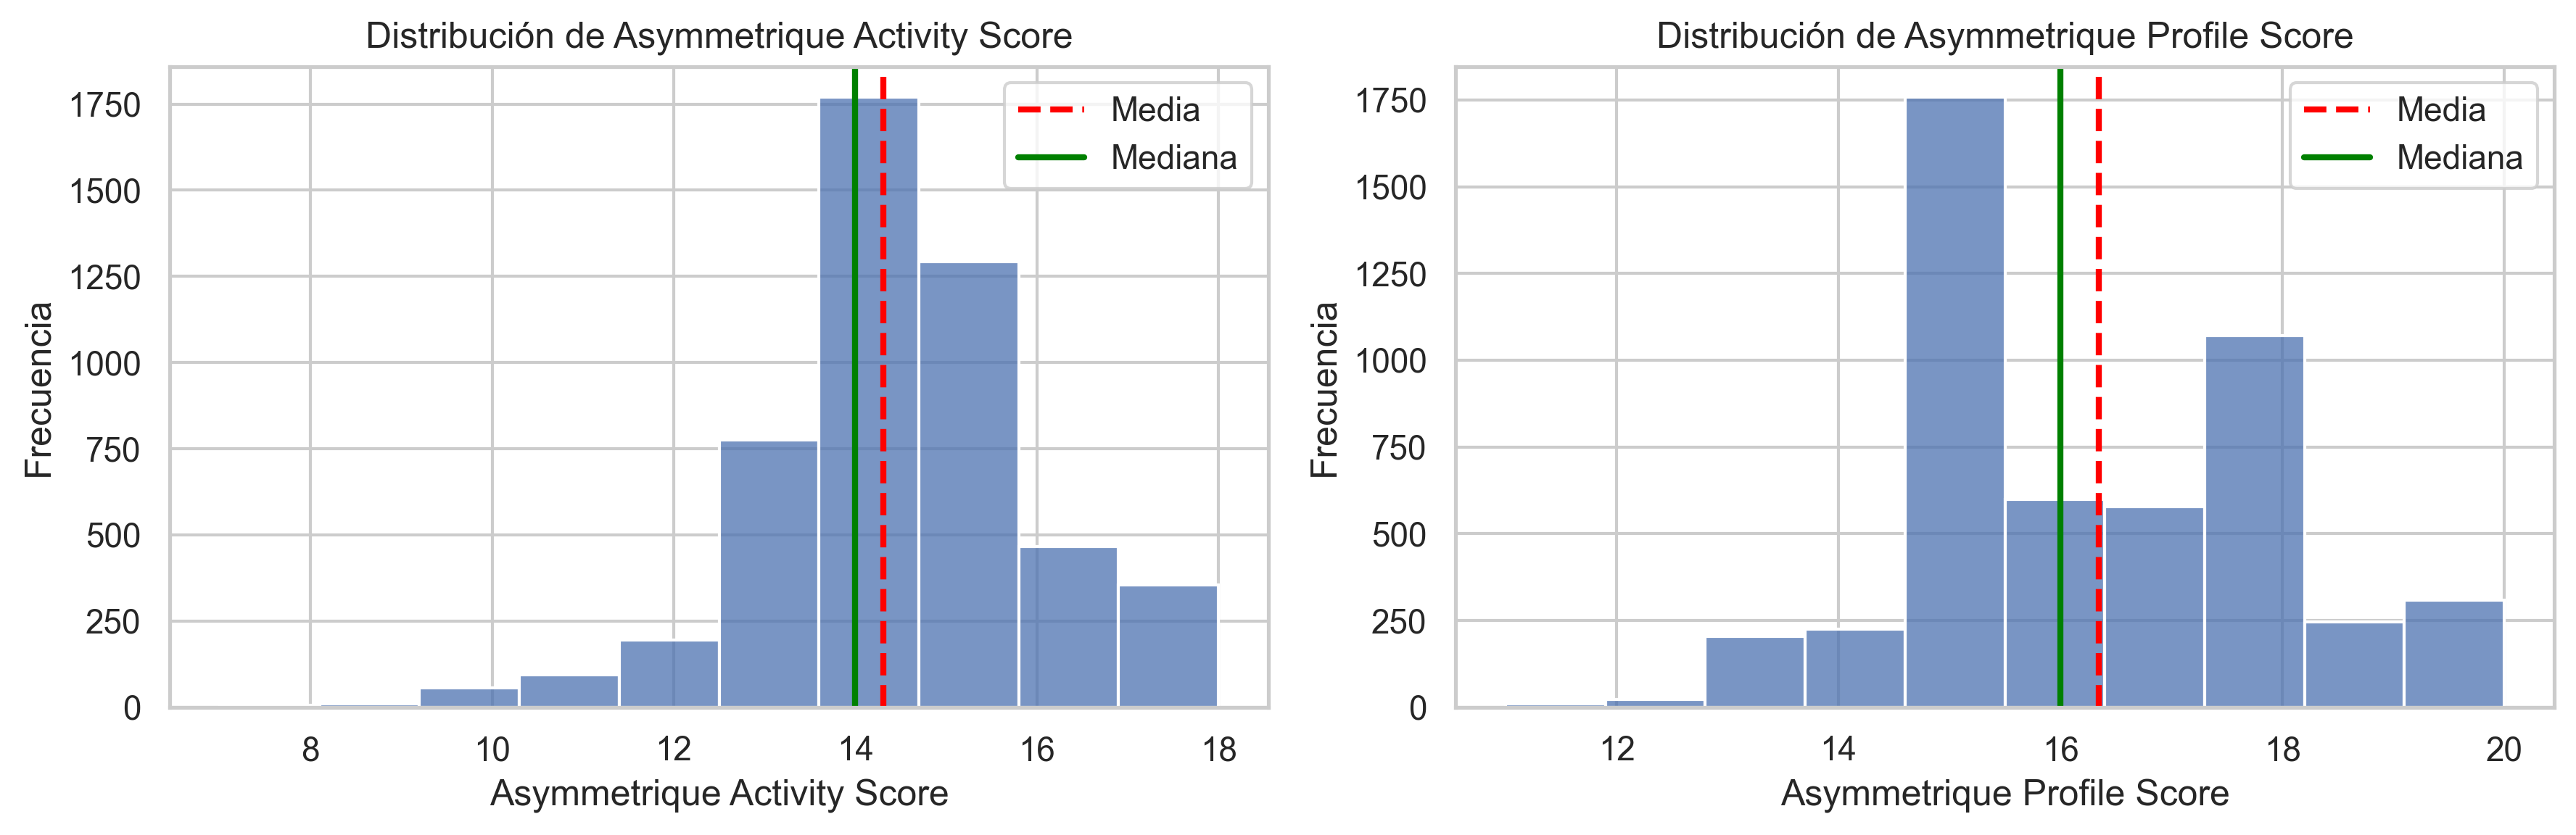

In [138]:
scores = ['Asymmetrique Activity Score', 'Asymmetrique Profile Score']

# Crear subgráficos
fig, ejes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=300)

# Generar histogramas con líneas de media y mediana
for i, score in enumerate(scores):
    sns.histplot(data=df, x=score, kde=False, ax=ejes[i], bins=10)  # Histograma sin KDE
    
    # Calcular la media y la mediana
    mean_value = df[score].mean()
    median_value = df[score].median()
    
    # Dibujar líneas verticales para la media y mediana
    ejes[i].axvline(mean_value, color='red', linestyle='dashed', linewidth=2, label='Media')
    ejes[i].axvline(median_value, color='green', linestyle='solid', linewidth=2, label='Mediana')
    
    # Etiquetas y título
    ejes[i].set_title(f"Distribución de {score}")
    ejes[i].set_xlabel(score)
    ejes[i].set_ylabel("Frecuencia")
    
    # Agregar leyenda
    ejes[i].legend()

plt.tight_layout()  # Ajustar espacio entre gráficos
plt.show()


## 📊 Interpretación de la Distribución: Sesgo Positivo

La **mediana** está a la izquierda de la **media** en ambos histogramas, lo que indica que la distribución está **sesgada a la derecha** (*right-skewed* o **sesgo positivo**). 

### 🔍 ¿Por qué ocurre esto?
Este comportamiento se da cuando hay **valores extremos altos** que elevan el **promedio**, mientras que la **mediana**, al ser más robusta frente a estos valores, permanece más baja.

📌 **Consecuencia del sesgo positivo**:
- La **media** es mayor que la **mediana**.
- La distribución tiene una **cola larga a la derecha**.
- La media puede ser un **mal indicador del centro de los datos**, ya que está influenciada por valores atípicos.

Para visualizar mejor este efecto, es útil trazar las líneas de **media y mediana** en los histogramas y analizar la forma de la distribución. 🚀


In [139]:
#print(ejes)

# Prueba de Skewness (Asimetría) en Datos

El **skewness** o coeficiente de asimetría mide si los datos están distribuidos de manera simétrica o presentan un sesgo hacia la derecha o la izquierda.

## Rango de Interpretación
- **Entre -0.5 y 0.5**: Aproximadamente simétrica.
- **Entre -1 y -0.5 o entre 0.5 y 1**: Moderadamente sesgada.
- **Menor a -1 o mayor a 1**: Altamente sesgada.

A continuación, se muestra un código en Python para calcular e interpretar el skewness:



In [140]:
from scipy.stats import skew

# Calcular skewness
skew_activity = skew(df['Asymmetrique Activity Score'], nan_policy='omit')
skew_profile = skew(df['Asymmetrique Profile Score'], nan_policy='omit')

# Imprimir resultados
print(f"Asymmetrique Activity Score skewness: {skew_activity}")
if -0.5 <= skew_activity <= 0.5:
    print("La distribución de 'Asymmetrique Activity Score' es aproximadamente simétrica.")
elif -1 <= skew_activity < -0.5 or 0.5 < skew_activity <= 1:
    print("La distribución de 'Asymmetrique Activity Score' está moderadamente sesgada.")
else:
    print("La distribución de 'Asymmetrique Activity Score' está altamente sesgada.")

print(f"Asymmetrique Profile Score skewness: {skew_profile}")
if -0.5 <= skew_profile <= 0.5:
    print("La distribución de 'Asymmetrique Profile Score' es aproximadamente simétrica.")
elif -1 <= skew_profile < -0.5 or 0.5 < skew_profile <= 1:
    print("La distribución de 'Asymmetrique Profile Score' está moderadamente sesgada.")
else:
    print("La distribución de 'Asymmetrique Profile Score' está altamente sesgada.")


Asymmetrique Activity Score skewness: -0.3832651789699476
La distribución de 'Asymmetrique Activity Score' es aproximadamente simétrica.
Asymmetrique Profile Score skewness: 0.2216724823998509
La distribución de 'Asymmetrique Profile Score' es aproximadamente simétrica.


| Estadístico | Cuándo usarlo ✅ | Cuándo evitarlo ❌ |
|-------------|------------------|--------------------|
| **Media**   | Cuando la distribución es simétrica, ya que representa bien el centro de los datos. | En distribuciones sesgadas, porque puede estar influenciada por valores atípicos y distorsionar la imputación. |
| **Mediana** | Cuando la distribución está sesgada (positiva o negativa), ya que es resistente a valores extremos y representa mejor el centro. | Cuando la distribución es perfectamente simétrica, ya que la media podría ser más representativa. |


In [141]:
# Imputar valores nulos con la mediana de cada columna
for s in scores:
    mediana = df[s].median()
    df[s] = df[s].fillna(mediana)  
    print(f"Mediana de {s}: {mediana}")

Mediana de Asymmetrique Activity Score: 14.0
Mediana de Asymmetrique Profile Score: 16.0


#### Ahora hagámos un histograma para los índices

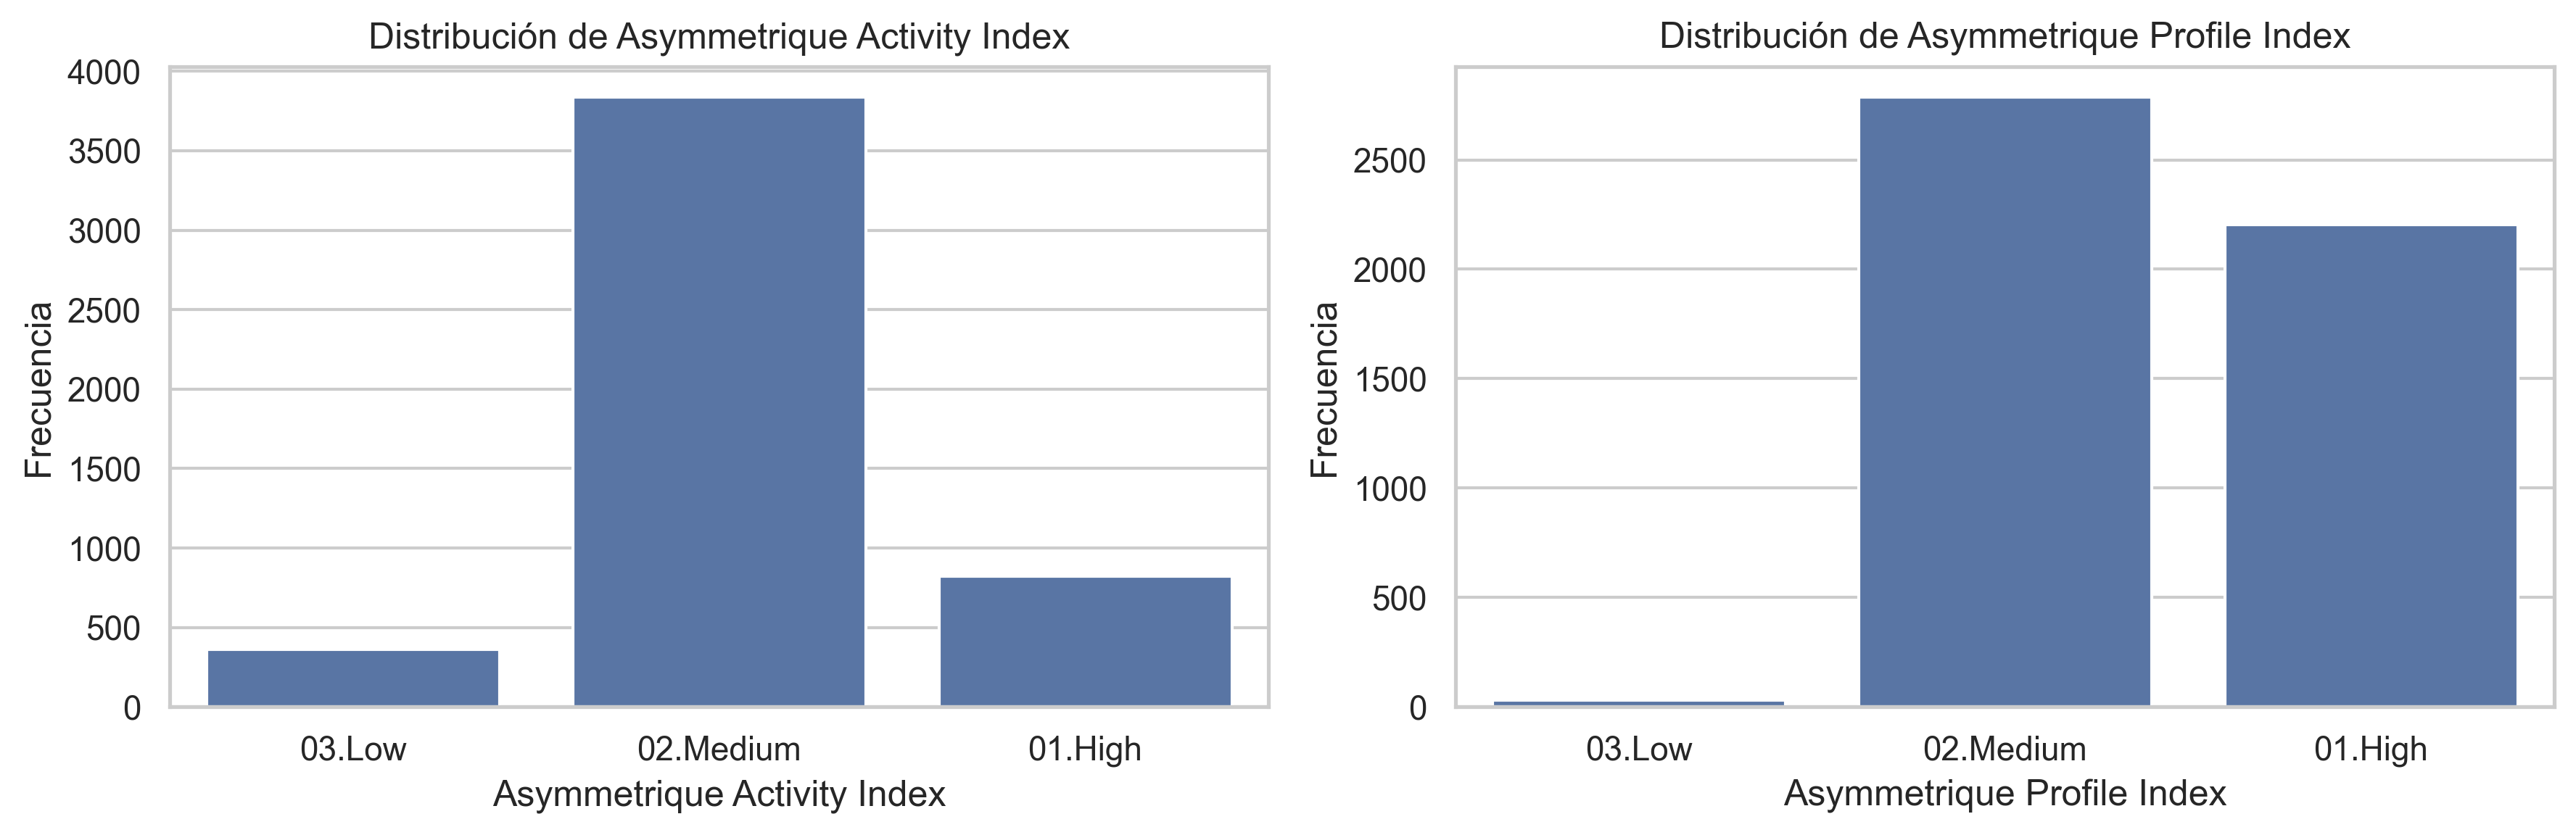

In [142]:
# Lista de índices categóricos
indices = ['Asymmetrique Activity Index', 'Asymmetrique Profile Index']

# Crear subgráficos
fig, ejes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4), dpi=300)

# Crear gráficos categóricos
for i, index in enumerate(indices):
    sns.countplot(
        x=index, 
        data=df, 
        ax=ejes[i], 
        order=['03.Low', '02.Medium', '01.High']  # Orden definido
    )
    ejes[i].set_title(f"Distribución de {index}")
    ejes[i].set_xlabel(index)
    ejes[i].set_ylabel("Frecuencia")

# Ajustar espacio entre gráficos
plt.tight_layout()
plt.show()

Parece que las características del índice podrían estar agrupadas de acuerdo con la **Puntuación Asimétrica**, lo que indicaría que ambas características del índice son redundantes. 
Para confirmar esta hipótesis, podemos analizar la **puntuación Asimétrica media** según el **Índice Asimétrico**.

### Agrupación por el Índice de Actividad Asimétrico

En este análisis, utilizaremos el método `agg` de Pandas para calcular la **media** de la columna `Asymmetrique Activity Score` agrupando por la columna `Asymmetrique Activity Index`.

#### ¿Qué hace el método `agg`?

El método `agg` se emplea para aplicar una o varias funciones de agregación a una serie de datos. En este caso, lo utilizaremos después de `groupby` para realizar el cálculo de la **media** de los valores correspondientes a cada grupo único en la columna `Asymmetrique Activity Index`.

Este análisis nos permitirá observar cómo varía la **Puntuación de Actividad Asimétrica** para cada grupo del **Índice de Actividad Asimétrico**.


In [143]:
agrupados_por_activity_index = df.groupby('Asymmetrique Activity Index', observed=False).agg({'Asymmetrique Activity Score': 'mean'})


## 📌 Uso de `observed=False` en `groupby()`

| **Escenario** | **¿Cuándo usar `observed=False`?** | **Efecto** |
|--------------|----------------------------------|----------|
| **Columna categórica con valores predefinidos** | ✅ Si quieres **conservar todas las categorías posibles**, incluso si no aparecen en los datos. | Se incluyen categorías sin datos en el resultado. |
| **Columna categórica con valores observados en los datos** | ❌ No es necesario, porque por defecto pandas muestra solo las categorías con datos. | No afecta el resultado. |
| **Columna no categórica (`object`, `int`, `float`)** | ❌ No tiene efecto, ya que `observed=False` solo aplica a columnas categóricas. | El resultado será el mismo con o sin `observed=False`. |

📌 **Ejemplo:** Si una columna categórica tiene categorías `A, B, C, D`, pero los datos solo contienen `A, B, C`:
- **Con `observed=False`**, `D` aparecerá en el resultado con valores `NaN`.
- **Con `observed=True` (por defecto)**, `D` no aparecerá en el resultado.


In [144]:
agrupados_por_activity_index

,Asymmetrique Activity Score
Asymmetrique Activity Index,
01.High,16.437272
02.Medium,14.134931
03.Low,11.290055


### Agrupemos por el Índice de Perfil Asimétrico

In [145]:
agrupados_por_profile_index = df.groupby('Asymmetrique Profile Index', observed=False).agg({'Asymmetrique Profile Score':'mean'})

In [146]:
agrupados_por_profile_index

,Asymmetrique Profile Score
Asymmetrique Profile Index,
01.High,18.128007
02.Medium,14.987446
03.Low,11.709677


### Análisis de las características del índice y puntuación asimétrica

#### Cálculos obtenidos:

1. **Asymmetrique Activity Index y Scores:**

| **Asymmetrique Activity Index** | **Asymmetrique Activity Score (Media)** |
|----------------------------------|-----------------------------------------|
| 01.High                         | 16.437272                               |
| 02.Medium                       | 14.134931                               |
| 03.Low                          | 11.290055                               |

2. **Asymmetrique Profile Index y Scores:**

| **Asymmetrique Profile Index**  | **Asymmetrique Profile Score (Media)**  |
|----------------------------------|-----------------------------------------|
| 01.High                         | 18.128007                               |
| 02.Medium                       | 14.987446                               |
| 03.Low                          | 11.709677                               |

#### Conclusión:

Como se observa en los cálculos, las columnas **Asymmetrique Activity Index** y **Asymmetrique Profile Index** parecen agrupar los valores de **Asymmetrique Activity Score** y **Asymmetrique Profile Score**, respectivamente. Esto sugiere que las características de los índices no aportan información adicional y son **redundantes**.

#### Recomendación:

- Las características `Asymmetrique Activity Index` y `Asymmetrique Profile Index` pueden ser eliminadas, ya que no añaden valor significativo al análisis y los valores de las puntuaciones ya contienen toda la información necesaria.


In [147]:
# Eliminar columnas redundantes
df = df.drop(columns=['Asymmetrique Activity Index', 'Asymmetrique Profile Index'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9240 entries, 660737 to 579533
Data columns (total 31 columns):
 #   Column                                         Non-Null Count  Dtype   
---  ------                                         --------------  -----   
 0   Lead Origin                                    9240 non-null   category
 1   Lead Source                                    9240 non-null   category
 2   Do Not Email                                   9240 non-null   bool    
 3   Do Not Call                                    9240 non-null   bool    
 4   Converted                                      9240 non-null   int64   
 5   TotalVisits                                    9240 non-null   float64 
 6   Total Time Spent on Website                    9240 non-null   int64   
 7   Page Views Per Visit                           9240 non-null   float64 
 8   Last Activity                                  9240 non-null   category
 9   Country                                

### Análisis Exploratorio de las Variables Categóricas

#### 📊 Creamos la función `conteo_de_convertidos`

Esta función generará un **gráfico de barras (countplot)** que comparará los **convertidos y no convertidos** en relación con la variable independiente respectiva. 

🔹 **¿Para qué sirve?**  
Será de mucha utilidad para visualizar la distribución de **variables categóricas** y su impacto en la conversión.

In [194]:
def conteo_de_convertidos(independiente, dependiente='Converted'):
    
    plt.figure(figsize=(9, 4), dpi=300)
    sns.countplot(
        y=independiente, 
        data=df,  
        hue=dependiente, 
        order=df[independiente].value_counts().index
    )
    plt.title(f"Distribución de {independiente} por {dependiente}", fontsize=14)
    plt.xlabel("Conteo", fontsize=12)
    plt.ylabel(independiente, fontsize=12)
    plt.legend(title="Convertidos", labels=["No Convertidos (0)", "Convertidos (1)"], fontsize=10)
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

#### Ahora calculemos la razón de conversión de leads en todo el conjunto de datos


In [195]:
tasa_de_conversion = round(df['Converted'].mean(), 2)

In [196]:
print(tasa_de_conversion)

0.39


### Análisis de la Tasa de Conversión

Una tasa de conversión de **0.39 (39%)** indica que, de cada 5 personas que interactúan con tu contenido, aproximadamente **2 terminan comprando tus cursos**.

| **Tasa de Conversión** | **Interpretación**                           | **Ejemplo**                                |
|-------------------------|---------------------------------------------|-------------------------------------------|
| 0.39 (39%)             | Porcentaje de personas que convierten.      | De cada 100 personas interesadas, **39 compran**. |
| 2/5                   | Aproximación de la tasa como fracción.       | De cada 5 personas, **2 compran**.         |

### Resumen
- La tasa de conversión del **39%** refleja un buen rendimiento en ventas.
- **Interpretación sencilla**: Por cada 5 personas interesadas, **2 compran**.
- Dicho de otra forma, por cada **100 personas interesadas, 39 compran**.


#### Análisis Exploratorio de una Variable: Lead Source

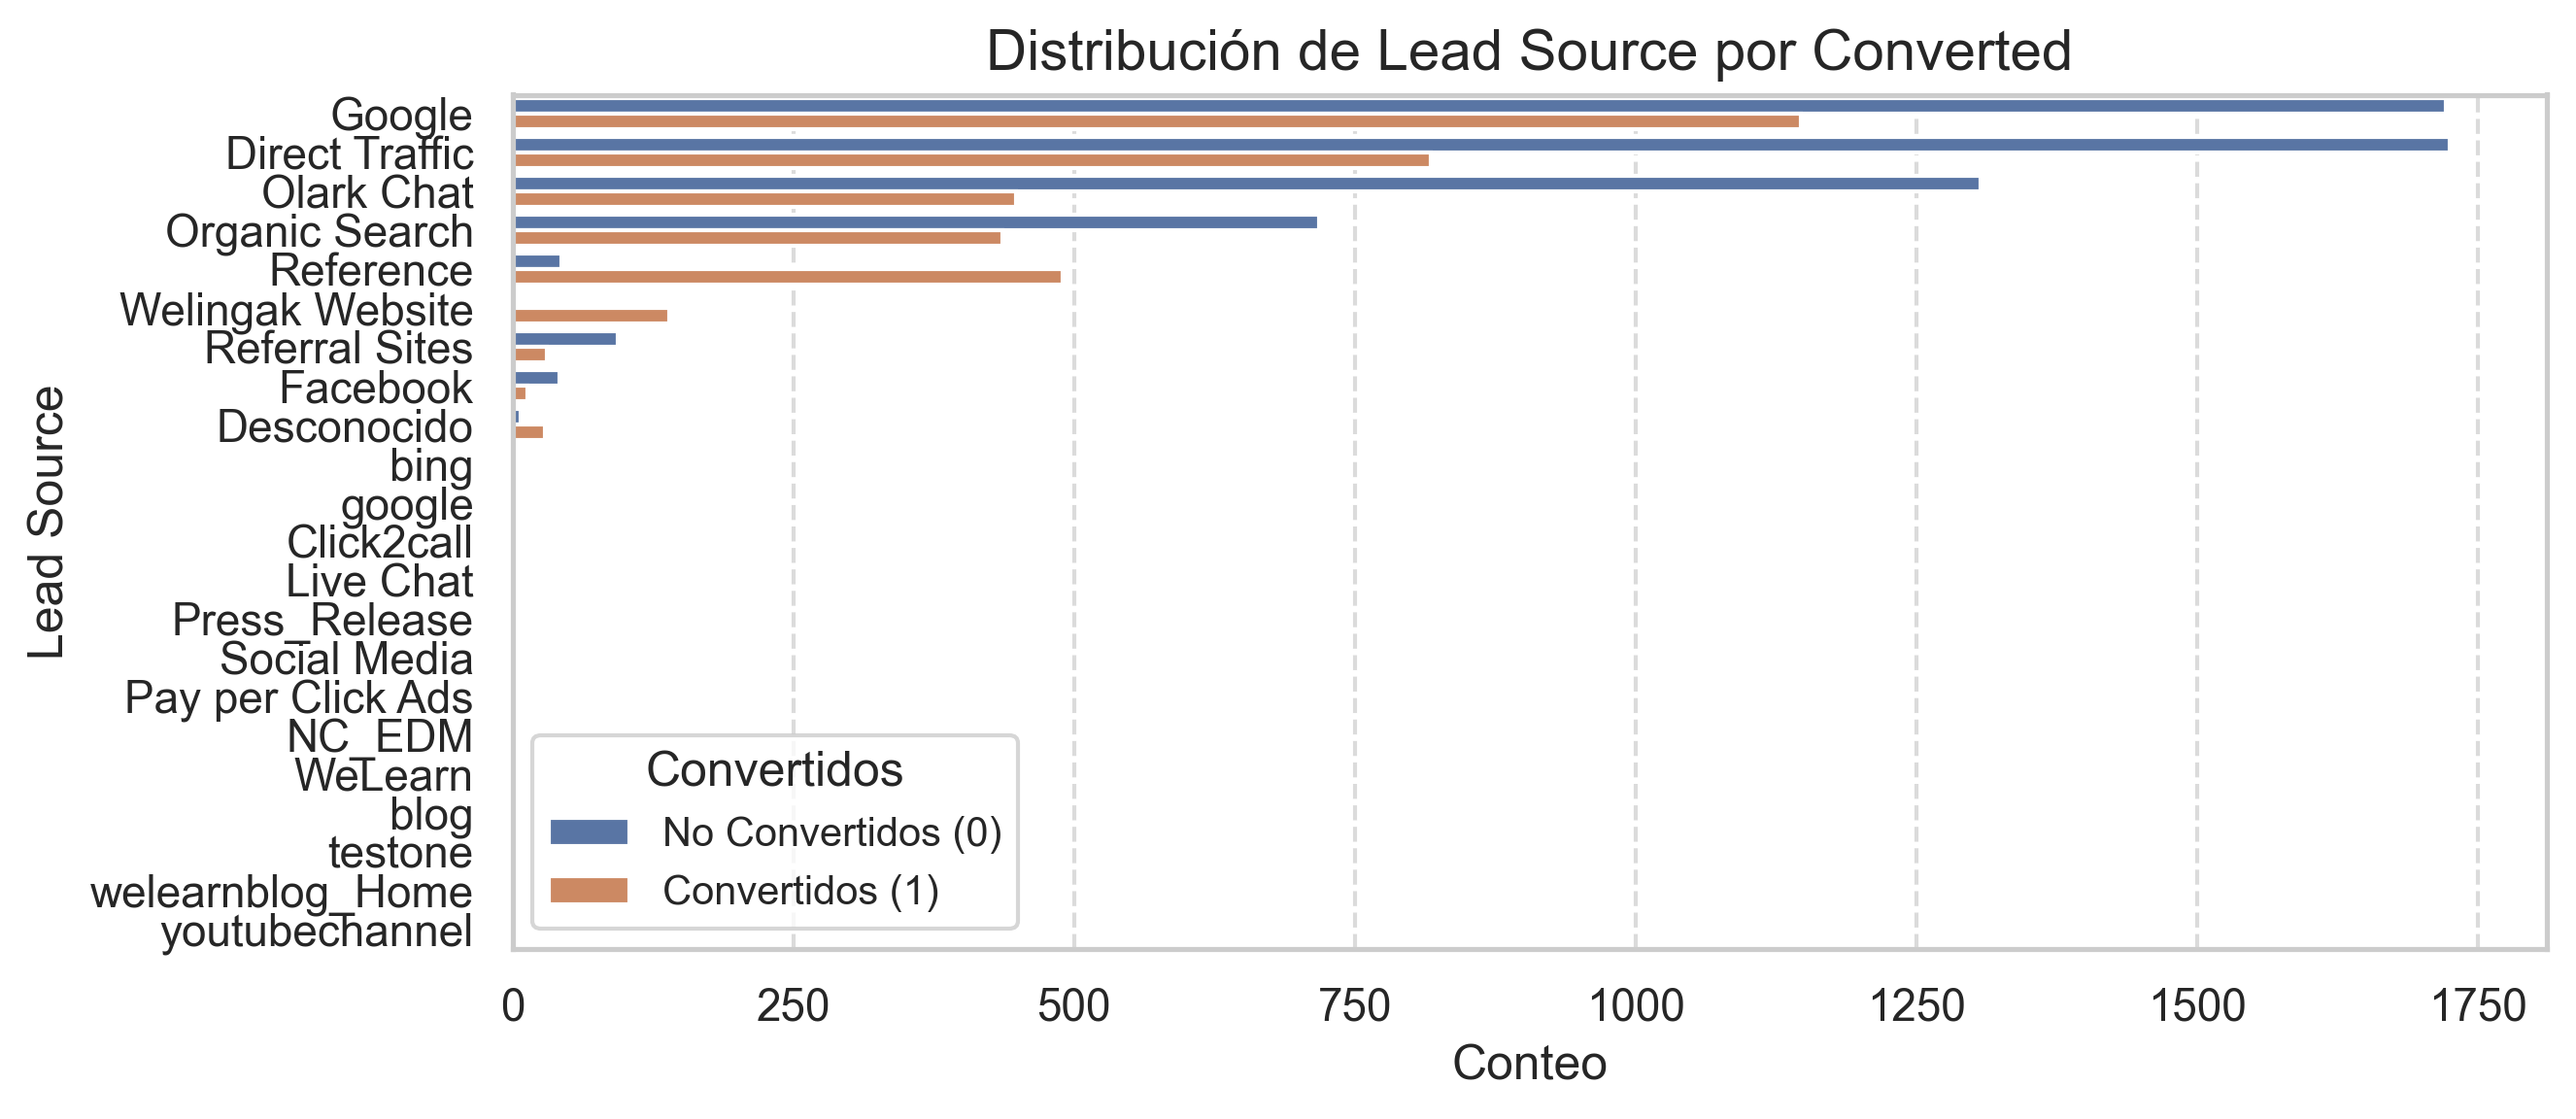

In [197]:
conteo_de_convertidos('Lead Source')

In [198]:
df[df['Lead Source'] == 'Welingak Website']['Converted'].value_counts()


Converted
1    140
0      2
Name: count, dtype: int64

In [207]:
# Contar la cantidad de convertidos y no convertidos por Lead Source
conversion_rates = df.groupby("Lead Source",observed=False)["Converted"].value_counts().unstack()

# Calcular tasa de conversión para cada fuente
conversion_rates["Conversion Rate"] = conversion_rates[1] / (conversion_rates[0] + conversion_rates[1])

# Ver resultados
print(conversion_rates.loc[["Organic Search", "Google"]])



Converted          0     1  Conversion Rate
Lead Source                                
Organic Search   718   436         0.377816
Google          1721  1147         0.399930


# Análisis de la gráfica: Distribución de Lead Source por Converted

## Observaciones principales

1. **Leads provenientes del sitio web de Welingak o referidos:**
   - **Welingak Website** y **Referral Sites** tienen un volumen menor de leads, pero sus tasas de conversión son altas.
   - Incrementar el número de leads provenientes de estas fuentes podría mejorar significativamente la tasa de conversión general.

2. **Google vs. Tráfico Directo:**
   - Aunque **Google** y **Direct Traffic** generan un volumen similar de leads, **Google** tiene una tasa de conversión más alta.
   - Es crucial seguir optimizando campañas y esfuerzos en Google para mantener y aumentar la conversión.

3. **Búsqueda Orgánica vs. Google:**
   - **Organic Search** genera menos leads que Google, pero su tasa de conversión es similar.
   - Esto sugiere que invertir en estrategias de optimización de motores de búsqueda (SEO) podría ser beneficioso.

4. **Prioridades estratégicas:**
   - Fuentes como **Welingak Website**, **Referral Sites**, y **Organic Search** son muy efectivas para convertir leads.
   - Fuentes de alto volumen, como **Google** y **Direct Traffic**, tienen espacio para optimización en su rendimiento de conversión.

## Tabla resumen

| **Fuente (Lead Source)**   | **Volumen de Leads** | **Tasa de Conversión**                  | **Recomendación**                                                                 |
|----------------------------|----------------------|------------------------------------------|-----------------------------------------------------------------------------------|
| Google                     | Alto                | Alta                                    | Continuar optimizando campañas y analizar detalles para aumentar la conversión.  |
| Direct Traffic             | Alto                | Menor que Google                        | Mejorar la experiencia de usuario y llamados a la acción en el sitio web.         |
| Welingak Website           | Bajo                | Alta                                    | Incrementar el tráfico mediante promociones o alianzas estratégicas.              |
| Referral Sites             | Bajo                | Alta                                    | Fomentar referencias para aumentar el volumen de leads.                          |
| Organic Search             | Moderado            | Similar a Google                        | Incrementar esfuerzos en SEO para aumentar el tráfico orgánico.                  |
| Fuentes menores (Facebook, Click2Call, etc.) | Muy Bajo            | Variable                               | Evaluar si vale la pena seguir invirtiendo en estas fuentes o redistribuir recursos.|

## Recomendaciones

1. **Expandir estrategias efectivas:**
   - Aumentar el volumen de leads provenientes de **Welingak Website** y **Referral Sites**, ya que son altamente efectivos en conversión.

2. **Optimizar canales principales:**
   - Continuar invirtiendo en **Google**, ya que es un canal clave con buenos resultados.
   - Mejorar la conversión de **Direct Traffic** mediante análisis del sitio web y experiencia de usuario.

3. **Invertir en SEO:**
   - **Organic Search** muestra un buen rendimiento en conversión, por lo que invertir en estrategias de SEO podría ser una opción sostenible y eficiente.

---


#### Análisis Exploratorio de una Variable: Last Activity

In [212]:
# Contar la cantidad de convertidos y no convertidos por Last Activity
conversion_rates = df.groupby("Last Activity", observed=False)["Converted"].value_counts().unstack()

# Asegurar que no haya valores NaN (por si alguna actividad solo tiene convertidos o no convertidos)
conversion_rates = conversion_rates.fillna(0)

# Calcular la tasa de conversión por actividad
conversion_rates["Conversion Rate"] = conversion_rates[1] / (conversion_rates[0] + conversion_rates[1])

# Ver la tasa de conversión de Olark Chat Conversation y compararla con otras actividades relevantes
print(conversion_rates.loc[["Olark Chat Conversation", "Email Opened", "SMS Sent", "Page Visited on Website"]])


Converted                   0     1  Conversion Rate
Last Activity                                       
Olark Chat Conversation   889    84         0.086331
Email Opened             2184  1253         0.364562
SMS Sent                 1018  1727         0.629144
Page Visited on Website   489   151         0.235937


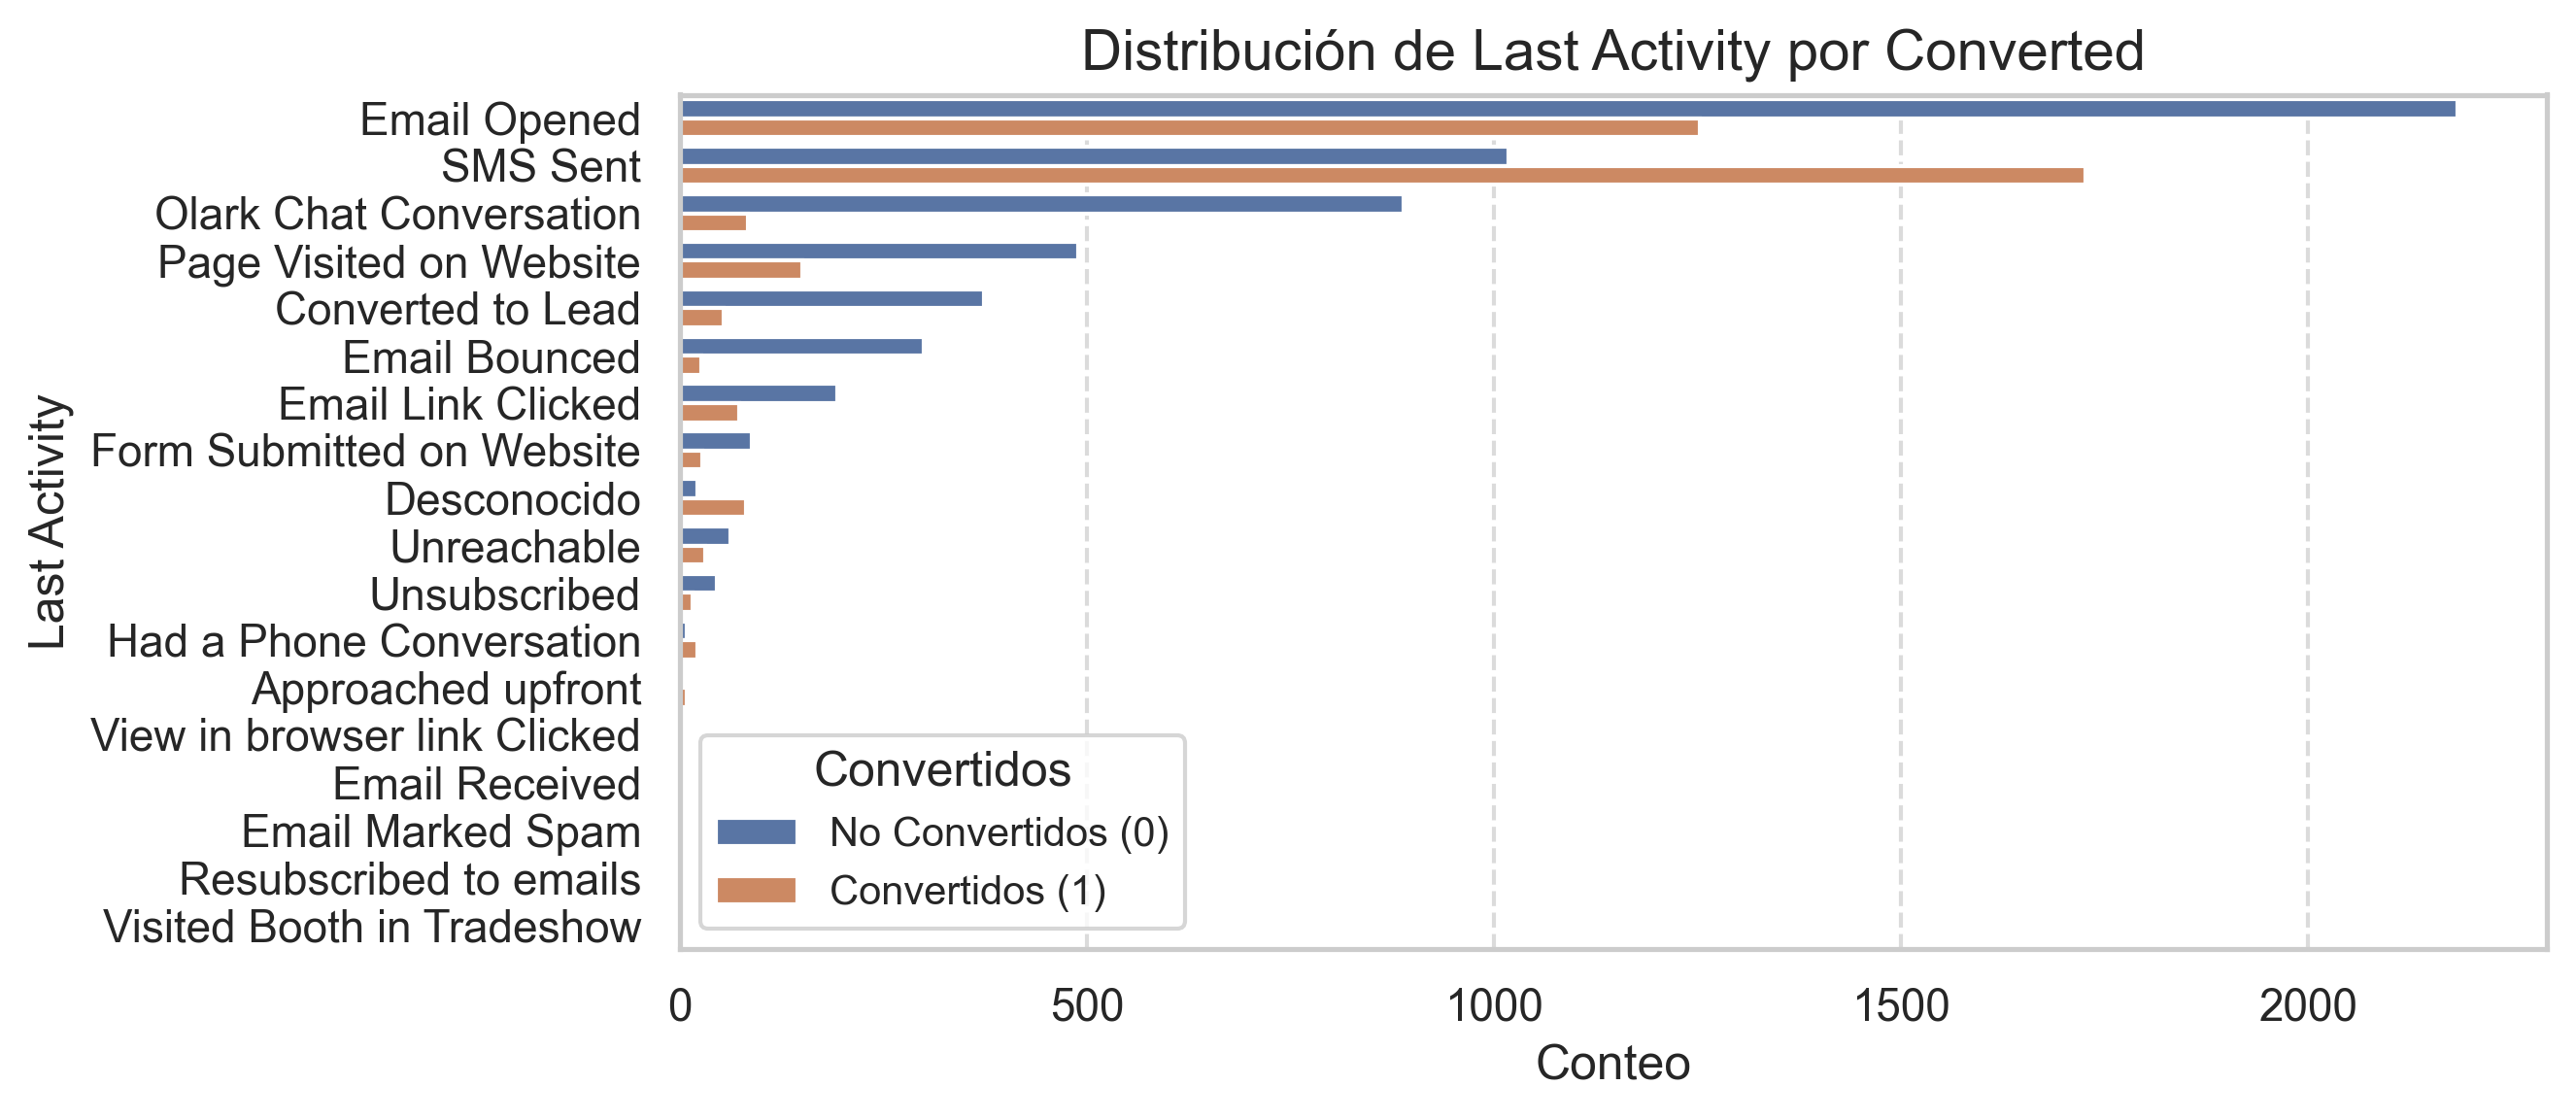

In [211]:
conteo_de_convertidos('Last Activity')

# 📊 Análisis de la Gráfica: Distribución de Last Activity por Converted

## 🔍 Observaciones principales

### **1️⃣ Email Opened tiene el mayor volumen de leads, pero su tasa de conversión es baja**
✔ Es la actividad más común, tanto para los convertidos como para los no convertidos.  
❌ Sin embargo, la **proporción de conversiones es baja** en comparación con el volumen total.

📌 **Conclusión**:  
Abrir un correo electrónico **no garantiza la conversión**. Esto indica la necesidad de mejorar **el contenido del correo, los llamados a la acción y el seguimiento posterior**.

---

### **2️⃣ SMS Sent es una actividad extremadamente efectiva en conversión**
✔ Aunque su volumen es menor en comparación con *Email Opened*, su **tasa de conversión es la más alta** (62.91%).  

📌 **Conclusión**:  
Los **SMS son el canal más efectivo para persuadir a los leads** y deben ser priorizados en estrategias de marketing.

---

### **3️⃣ Olark Chat Conversation tiene la tasa de conversión más baja**
❌ La tasa de conversión de **Olark Chat Conversation es solo 8.63%**, lo que la convierte en la **actividad menos efectiva** en conversión.  
❌ Esto contradice la afirmación inicial sobre su rendimiento.  

📌 **Conclusión**:  
Los chats en tiempo real **no están generando conversiones de manera efectiva y necesitan mejoras**.  
Para optimizar su rendimiento:
- Agregar **mejores respuestas automatizadas** en el chat.  
- Usar **scripts de ventas más efectivos** para persuadir a los usuarios.  
- Capturar **más datos del usuario antes de la conversación**.  

---

### **4️⃣ Page Visited on Website tiene un volumen significativo, pero conversión moderada**
✔ Muchos leads tienen esta actividad como la última antes de convertirse o no.  
❌ Sin embargo, la **proporción de conversiones es menor** que en *SMS Sent* o *Email Opened* (23.59%).  

📌 **Conclusión**:  
Se recomienda implementar **estrategias de retargeting** (por ejemplo, mensajes personalizados o campañas de remarketing) para maximizar la efectividad de estas visitas.

---

### **5️⃣ Actividades de bajo impacto (Email Bounced, Unreachable, etc.)**
❌ Estas actividades están asociadas **mayoritariamente con leads no convertidos**.  

📌 **Conclusión**:  
Los leads con estas actividades **requieren estrategias específicas de reactivación** o podrían ser descartados si los recursos son limitados.

---

## 📌 Recomendaciones

### ✅ **1. Optimizar el contenido y seguimiento de correos electrónicos**
- *Email Opened* domina el volumen, pero **su tasa de conversión es baja**.
- Es crucial mejorar:
  - **La calidad del contenido**.
  - **Los llamados a la acción**.
  - **El seguimiento a los leads que interactúan con correos**.

---

### ✅ **2. Priorizar el uso de SMS como canal de conversión**
- *SMS Sent* muestra una **tasa de conversión extremadamente alta (62.91%)**.
- Se recomienda fortalecer este canal para impactar más leads y maximizar resultados.

---

### ✅ **3. Mejorar la efectividad del chat en tiempo real**
- *Olark Chat Conversation* **no tiene una conversión sobresaliente** y debe optimizarse antes de escalarlo.
- Posibles mejoras:
  - **Automatizar respuestas** con chatbots inteligentes.
  - **Optimizar los scripts de ventas** para mejorar la interacción.
  - **Ofrecer soporte proactivo** basado en el comportamiento del usuario.

---

### ✅ **4. Implementar estrategias de remarketing para visitas al sitio web**
- *Page Visited on Website* tiene un volumen significativo, pero **requiere personalización** para aumentar conversiones.
- Estrategias recomendadas:
  - **Campañas de remarketing** para atraer nuevamente a estos usuarios.
  - **Pop-ups personalizados** con ofertas o formularios de contacto.
  - **Notificaciones automáticas** para recordarles completar una acción.

---

### ✅ **5. Reevaluar leads de bajo impacto**
- Leads con *Email Bounced, Unreachable*, o similares **tienen menor probabilidad de conversión**.
- Se recomienda:
  - **Estrategias de reactivación** (como campañas de re-engagement).
  - **Segmentación eficiente** para evitar perder recursos en leads poco prometedores.

---

## 📊 **Tabla Resumen**
| **Última Actividad (Last Activity)**     | **Volumen de Leads** | **Tasa de Conversión** | **Recomendación** |
|------------------------------------------|----------------------|----------------------|------------------------------|
| **Email Opened**                         | Muy Alto             | 36.45%               | Mejorar contenido, llamados a la acción y seguimiento. |
| **SMS Sent**                             | Alto                 | 62.91%               | Incrementar el uso de SMS como canal clave de conversión. |
| **Olark Chat Conversation**              | Moderado             | 8.63%                | Optimizar su uso antes de escalarlo. |
| **Page Visited on Website**              | Alto                 | 23.59%               | Implementar estrategias de retargeting y personalización. |
| **Email Bounced, Unreachable, etc.**     | Bajo                 | Muy Baja             | Reevaluar estos leads y priorizar los más prometedores. |

---

## 📌 **Reflexión Final**
✔ **Email Opened domina el volumen, pero necesita optimización para mejorar su tasa de conversión.**  
✔ **SMS Sent es el canal más efectivo hasta ahora y debe ser prioridad en estrategias de conversión.**  
✔ **El análisis sugiere priorizar estrategias que combinen volumen y efectividad, optimizando los canales con mejores conversiones.**  
✔ **Antes de fomentar el uso del chat en vivo (Olark Chat Conversation), es necesario mejorar su capacidad de conversión.**  

🚀 **Acción recomendada:**  
1️⃣ **Fortalecer SMS y remarketing web.**  
2️⃣ **Optimizar el email marketing.**  
3️⃣ **Mejorar la conversión en chat antes de expandir su uso.**  


#### Análisis Exploratorio de una Variable: Lead Origin

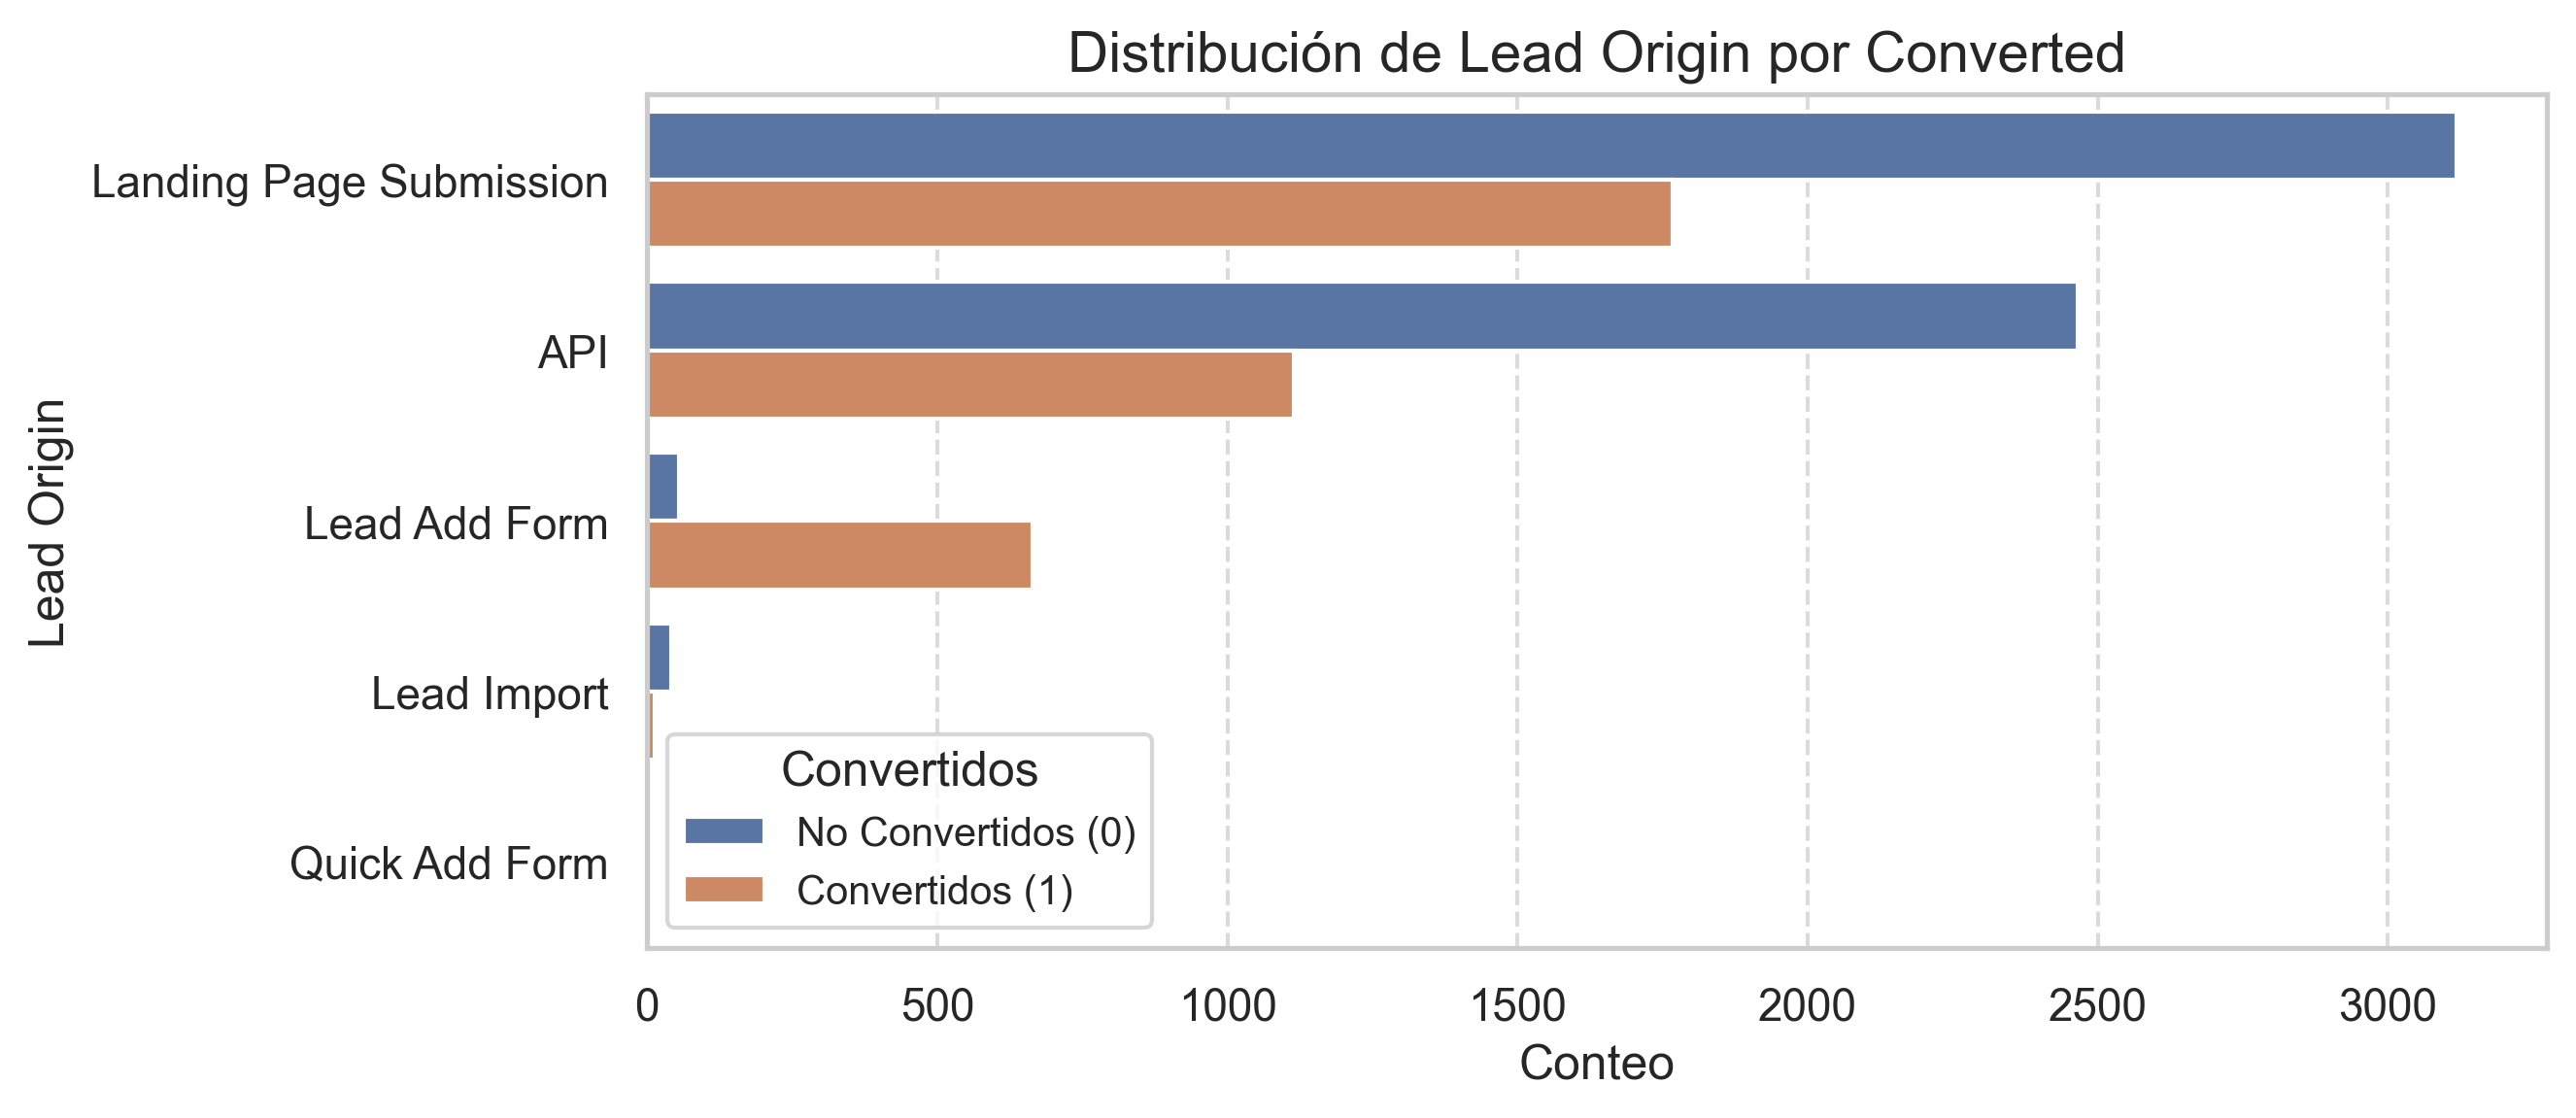

In [213]:
conteo_de_convertidos('Lead Origin')

In [214]:
# Contar la cantidad de convertidos y no convertidos por Lead Origin
conversion_rates = df.groupby("Lead Origin", observed=False)["Converted"].value_counts().unstack()

# Asegurar que no haya valores NaN (por si algún Lead Origin tiene solo convertidos o no convertidos)
conversion_rates = conversion_rates.fillna(0)

# Calcular la tasa de conversión
conversion_rates["Conversion Rate"] = conversion_rates[1] / (conversion_rates[0] + conversion_rates[1])

# Ver los resultados para todos los Lead Origin
print(conversion_rates)


Converted                   0     1  Conversion Rate
Lead Origin                                         
API                      2465  1115         0.311453
Landing Page Submission  3118  1768         0.361850
Lead Add Form              54   664         0.924791
Lead Import                42    13         0.236364
Quick Add Form              0     1         1.000000


# 📊 Análisis de la Gráfica: Distribución de Lead Origin por Converted

## 📌 **Tabla de Conversión por Origen de Lead**
| **Lead Origin**             | **No Convertidos (0)** | **Convertidos (1)** | **Tasa de Conversión** |
|-----------------------------|----------------------|----------------|----------------|
| **API**                     | 2465                | 1115          | **31.15%** |
| **Landing Page Submission**  | 3118                | 1768          | **36.19%** |
| **Lead Add Form**            | 54                  | 664           | **92.48%** 🚀 |
| **Lead Import**              | 42                  | 13            | **23.64%** |
| **Quick Add Form**           | 0                   | 1             | **100.00%** (irrelevante por bajo volumen) |

---

## 🔍 **Observaciones principales**

### **1️⃣ `Landing Page Submission` domina el volumen de leads, pero su tasa de conversión es moderada**
✔ Es la fuente principal de generación de leads, con **4886 en total**.  
❌ Aunque genera un gran volumen de leads, su tasa de conversión es **36.19%**, lo que indica que **podría mejorarse**.

📌 **Conclusión**:  
Las estrategias relacionadas con Landing Pages deben enfocarse en **mejorar la calidad de los leads generados** para aumentar la conversión.

---

### **2️⃣ `API` tiene un volumen significativo, pero conversión moderada**

## 📌 **Tabla Resumen: ¿Qué es una API y cómo se usa en generación de leads?**

| **Concepto**               | **Descripción** |
|----------------------------|------------------------------------------------------------------------------------------------|
| **API (Application Programming Interface)** | Una interfaz que permite que dos sistemas diferentes se comuniquen entre sí automáticamente. |
| **Función en generación de leads** | Captura y transfiere datos de leads desde plataformas externas (formularios, chatbots, redes sociales) a un CRM o base de datos. |
| **Ejemplo práctico**       | Un lead llena un formulario en **Facebook Ads** y la API envía automáticamente los datos al CRM (HubSpot, Salesforce, etc.). |
| **Ventajas**               | 🔹 Automatización 🔹 Integración en tiempo real 🔹 Reducción de errores 🔹 Mayor eficiencia en el seguimiento de leads |
| **Ejemplo de integración** | Un chatbot en **WhatsApp** recopila información del usuario y la API la transfiere automáticamente al sistema de ventas. |
| **Casos de uso**           | 📌 Integración con formularios de anuncios 📌 Conexión de chatbots 📌 Transferencia de datos entre herramientas de marketing |

✔ La API genera **3580 leads**, lo que la convierte en un canal fuerte.  
❌ Sin embargo, su tasa de conversión es **31.15%**, menor que la de Landing Pages y muy por debajo de Lead Add Form.

# 📌 ¿El canal API influye en la conversión?

❌ **No directamente.** La API solo transfiere datos, pero **sí puede influir** en la conversión dependiendo de **qué fuentes de leads se integran y cómo se gestionan en el CRM**.

---

## 🚀 **Cómo optimizar la API para mejorar la conversión**

### 1️⃣ Mejorar la calidad de los leads
✔ **Filtrar y validar leads** antes de ingresarlos al CRM para evitar datos falsos o incompletos.  
✔ **Priorizar fuentes confiables**, revisando qué plataformas generan los leads más efectivos.  

### 2️⃣ Reducir el tiempo de respuesta
✔ **Automatizar respuestas** vía email o SMS para contacto inmediato.  
✔ **Notificar al equipo de ventas** en tiempo real para agilizar el seguimiento.  

### 3️⃣ Integrar la API con el CRM
✔ **Segmentar automáticamente los leads** y asignarlos a campañas adecuadas.  
✔ **Hacer remarketing**, enviando recordatorios a leads inactivos.  

### 4️⃣ Medir y ajustar estrategias
✔ **Monitorear la conversión** de cada fuente y optimizar las más efectivas.  
✔ **Probar diferentes formularios** en las plataformas conectadas para mejorar la calidad del lead.  

---

## 🎯 **Conclusión**
✔ La API **no convierte leads**, pero **sí mejora su calidad y gestión** en el CRM.  
✔ **Optimizar su uso** implica filtrar datos, automatizar seguimientos y segmentar mejor los leads.  
✔ Si los leads ingresados por la API **no convierten bien, el problema está en la fuente o el seguimiento, no en la API.**  

🚀 **Acción recomendada:**  
1️⃣ Revisar qué plataformas envían leads a la API y optimizar esas fuentes.  
2️⃣ Automatizar respuestas inmediatas y alertas al equipo de ventas.  
3️⃣ Segmentar los leads en el CRM para asignarles la mejor estrategia.  
4️⃣ Ajustar estrategias de remarketing para mejorar conversiones.  


---

### **3️⃣ `Lead Add Form` tiene la tasa de conversión más alta (92.48%) 🚀**
✔ Aunque su volumen es menor (**718 leads** en total), su tasa de conversión es **extraordinariamente alta**.  
✔ Es el canal más efectivo en términos de conversión.

📌 **Conclusión**:  
Este canal debería **ser priorizado y expandido**, ya que **supera ampliamente a todos los demás en efectividad**.

---

### **4️⃣ `Lead Import` tiene un impacto limitado (23.64%)**
❌ Este canal genera muy pocos leads (**solo 55 en total**) y su conversión es la **más baja** (excluyendo Quick Add Form, que tiene solo 1 lead).  

📌 **Conclusión**:  
Es posible que este canal **no sea eficiente en términos de generación y conversión de leads**.  
Se recomienda **reevaluar su utilidad o mejorar su gestión**.

---

## 📌 **Recomendaciones**

### ✅ **1. Optimizar la estrategia de Landing Pages**
- Dado que este canal **domina el volumen**, mejorar su diseño, contenido y llamados a la acción puede aumentar la conversión.

### ✅ **2. Fortalecer la integración con la API**
- La API ya genera buenos resultados. Aumentar su uso y explorar integraciones adicionales podría ampliar su impacto.

### ✅ **3. Priorizar el uso de Lead Add Forms**
- Este canal **tiene la tasa de conversión más alta (92.48%)**.  
- Se recomienda **expandir su uso y visibilidad** para maximizar su impacto.

### ✅ **4. Reevaluar el uso de Lead Import**
- Su volumen es bajo y su conversión es la más baja.  
- Se recomienda **redistribuir recursos hacia canales más efectivos**.

---

## 📊 **Tabla resumen**
| **Origen del Lead (Lead Origin)** | **Volumen de Leads** | **Tasa de Conversión**                  | **Recomendación**                                                                 |
|-----------------------------------|----------------------|------------------------------------------|-----------------------------------------------------------------------------------|
| **Landing Page Submission**       | Muy Alto (4886)      | 36.19%                                  | Mejorar la calidad de los leads generados para incrementar su conversión.         |
| **API**                           | Alto (3580)         | 31.15%                                  | Ampliar su uso y explorar nuevas integraciones.                                   |
| **Lead Add Form**                 | Moderado (718)      | **92.48%** 🔥                           | **Incrementar su visibilidad y uso, ya que es el canal más efectivo.**             |
| **Lead Import**                   | Bajo (55)           | 23.64%                                  | **Reevaluar su utilidad o redistribuir recursos hacia canales más efectivos.**    |

---

## 📌 **Reflexión Final**
✔ **Landing Page Submission tiene el mayor volumen, pero su conversión debe mejorarse.**  
✔ **Lead Add Form es el canal más efectivo con 92.48% de conversión y debe ser priorizado.**  
✔ **API es un canal confiable, pero menos eficiente que Landing Pages y Lead Add Form.**  
✔ **Lead Import tiene baja conversión y debe ser reevaluado.**  

🚀 **Acción recomendada:**  
1️⃣ **Optimizar las Landing Pages para mejorar la conversión.**  
2️⃣ **Expandir el uso de Lead Add Forms, ya que es el canal más efectivo.**  
3️⃣ **Fortalecer la API para mejorar su conversión.**  
4️⃣ **Reevaluar Lead Import y considerar mover recursos a canales más eficientes.**  


### Análisis Exploratorio de las Variables Booleanas

### Uso de crosstab() para hace el análisis exploratorio de las variables Booleanas<br> 
#### 📌 **Diferencia entre Frecuencia Absoluta y Frecuencia Relativa en `pd.crosstab()`**
| **Tipo de Tabla**                           | **Valores Mostrados**                                               | **Útil Para...** |
|---------------------------------------------|-------------------------------------------------------------------|------------------|
| **Frecuencia Absoluta** (sin `normalize='index'`) | Cantidad de convertidos y no convertidos en cada categoría.       | Ver cuántos leads hay en total por categoría, pero no permite comparar tasas de conversión. |
| **Frecuencia Relativa** (con `normalize='index'`) | Porcentaje de convertidos y no convertidos dentro de cada categoría. | Comparar la efectividad de cada categoría en la conversión. |


In [154]:
import pandas as pd

def analizar_variable_booleana(df, columna):
    """
    Genera una tabla de frecuencias (crosstab) entre una variable booleana y 'Converted'.
    Renombra los valores de False y True si es necesario.
    """

    if columna not in df.columns or 'Converted' not in df.columns:
        print(f"Error: La columna '{columna}' o 'Converted' no está en el DataFrame.")
        return None

    # Generar la tabla de frecuencias con porcentajes
    crosstab_percent = pd.crosstab(df[columna], df['Converted'], normalize='index') * 100

    # Si la columna es booleana, cambiar los índices de False/True a etiquetas más claras
    if df[columna].dtype == 'bool':
        crosstab_percent.rename(index={False: 'No', True: 'Yes'}, inplace=True)

    # Renombrar el índice con el nombre de la columna analizada
    crosstab_percent.index.name = columna

    # Formatear los valores como porcentaje con 2 decimales
    crosstab_percent = crosstab_percent.map(lambda x: f"{x:.2f}%")

    return crosstab_percent




### Get updates on DM Content vs Converted

In [155]:
resultado = analizar_variable_booleana(df, 'Get updates on DM Content')
display(resultado)

Converted,0,1
Get updates on DM Content,,
No,61.46%,38.54%


# 📊 Análisis Exploratorio: Relación entre "Get updates on DM Content" y "Converted"

## 📌 Tabla de Frecuencias Relativas

El siguiente análisis se basa en la tabla generada con `crosstab()`, que muestra el porcentaje de conversión según la variable **"Get updates on DM Content"**:

| **Get updates on DM Content** | **No Convertidos (0)** | **Convertidos (1)** |
|-------------------------------|------------------------|----------------------|
| **No**                        | 61.46%                 | 38.54%               |

---

## 🔎 **Observaciones Principales**
1️⃣ **Todos los prospectos en los datos marcaron "No" en "Get updates on DM Content"**.  
   - Esto significa que no hay registros de prospectos que hayan seleccionado "Sí" en esta opción.  
   - Por lo tanto, no es posible comparar la tasa de conversión entre los que seleccionaron "Sí" y "No".  

2️⃣ **Los prospectos que seleccionaron "No" tienen una tasa de conversión del 38.54%**.  
   - Aunque este porcentaje nos da una idea de conversión en este grupo, no podemos determinar si activar "Sí" en esta opción influye en la conversión porque no hay datos disponibles para esa categoría.  

---

## 📌 **Interpretación del Resultado**
- La falta de datos en la categoría **"Sí"** sugiere que esta opción **puede no haber sido utilizada en el formulario** o que todos los prospectos **prefirieron no recibir actualizaciones**.  
- **No podemos sacar conclusiones sobre el impacto de esta variable en la conversión**, ya que no hay registros de prospectos que hayan optado por "Sí".  

---

## 🎯 **Recomendaciones Estratégicas**
✅ **Revisar la fuente de datos** para confirmar si "Get updates on DM Content" es una opción válida en el formulario o si simplemente **no fue utilizada por los prospectos**.  
✅ **Si esta variable es relevante**, se debe recolectar más información para evaluar si impacta en la conversión.  
✅ **Si todos los prospectos siempre marcan "No"**, esta variable puede **no ser útil** para el análisis de conversión y podría descartarse en modelos predictivos.  

📌 **Conclusión Final:**  
Dado que solo tenemos datos de prospectos que seleccionaron "No", **no podemos evaluar si esta v


In [156]:
resultado = analizar_variable_booleana(df, 'Do Not Email')
display(resultado)

Converted,0,1
Do Not Email,,
No,59.52%,40.48%
Yes,83.92%,16.08%


# 📊 Análisis Exploratorio: Relación entre "Do Not Email" y "Converted"

## 📌 Tabla de Frecuencias Relativas

El siguiente análisis se basa en la tabla generada con `crosstab()`, que muestra el porcentaje de conversión según la variable **"Do Not Email"**:

| **Do Not Email** | **No Convertidos (0)** | **Convertidos (1)** |
|-----------------|-------------------|-----------------|
| **False** (No seleccionó "Do Not Email") | 59.52% | 40.48% |
| **True** (Sí seleccionó "Do Not Email") | 83.92% | 16.08% |

---

## 🔎 **Observaciones Principales**
1️⃣ **Los prospectos que no activaron "Do Not Email" (False) tienen una tasa de conversión significativamente más alta (40.48%)**.  
   - Esto indica que aquellos que **están dispuestos a recibir correos electrónicos** convierten más.  

2️⃣ **Los prospectos que activaron "Do Not Email" (True) tienen una tasa de conversión baja (16.08%)**.  
   - Esto sugiere que los usuarios que **rechazan recibir correos electrónicos** son mucho menos propensos a convertirse.  
   - Además, este grupo representa **una porción menor de los prospectos totales**.

---

## 📌 **Interpretación del Resultado**
- El hecho de que un prospecto **permita o no recibir correos** parece estar correlacionado con su **probabilidad de conversión**.  
- **Recibir emails puede ser un factor relevante en el proceso de conversión**, ya que los prospectos que los permiten tienen una conversión más alta.  
- Por otro lado, los prospectos que **rechazan los correos electrónicos muestran menos interés** en convertirse.

---

## 🎯 **Recomendaciones Estratégicas**
✅ **Priorizar el contacto por correo electrónico** para los prospectos que **no activaron "Do Not Email"**, ya que tienen una alta tasa de conversión (40.48%).  
✅ **Desarrollar estrategias alternativas** para prospectos que activaron "Do Not Email" (16.08% de conversión), como:
   - Campañas en redes sociales.
   - Anuncios personalizados o retargeting.
   - Contacto mediante otros canales (llamadas o mensajes directos).  

📌 **Conclusión Final:**  
Los resultados indican que **el email marketing sigue siendo una herramienta efectiva**, y que los prospectos que permiten recibir correos tienen **más del doble de probabilidad de conversión** en comparación con los que no lo hacen. 🚀


In [157]:
resultado = analizar_variable_booleana(df, 'A free copy of Mastering The Interview')
display(resultado)

Converted,0,1
A free copy of Mastering The Interview,,
No,60.15%,39.85%
Yes,64.34%,35.66%


# 📊 Análisis Exploratorio: Relación entre "A free copy of Mastering The Interview" y "Converted"

## 📌 Tabla de Frecuencias Relativas

El siguiente análisis se basa en la tabla generada con `crosstab()`, que muestra el porcentaje de conversión según la variable **"A free copy of Mastering The Interview"**:

| **A free copy of Mastering The Interview** | **No Convertidos (0)** | **Convertidos (1)** |
|--------------------------------------------|------------------------|----------------------|
| **No**                                     | 60.15%                 | 39.85%               |
| **Yes**                                    | 64.34%                 | 35.66%               |

---

## 🔎 **Observaciones Principales**
1️⃣ **Los prospectos que NO solicitaron una copia del libro ("No") tienen una tasa de conversión del 39.85%**.  
   - Este grupo tiene una conversión **ligeramente mayor** que aquellos que sí lo solicitaron.  

2️⃣ **Los prospectos que solicitaron una copia del libro ("Yes") tienen una tasa de conversión del 35.66%**.  
   - La conversión en este grupo es **un poco más baja** en comparación con los que no solicitaron la copia.  
   - Esto indica que pedir el libro **no está directamente relacionado con una mayor conversión**.  

---

## 📌 **Interpretación del Resultado**
- Aunque podría pensarse que solicitar un recurso gratuito como "Mastering The Interview" indicaría mayor interés en la conversión, **los datos muestran lo contrario**:  
   - **Los prospectos que NO lo pidieron convirtieron más (39.85%) que los que sí lo pidieron (35.66%)**.  
- Esto podría significar que **los prospectos más interesados en el contenido gratuito no necesariamente tienen una intención real de conversión**.  
- También es posible que aquellos que no solicitan el libro **ya tengan información suficiente y estén más listos para convertir**.  
- **Posibles explicaciones adicionales:**
   - Es posible que los prospectos que solicitaron el libro gratuito lo hayan hecho simplemente por obtener el contenido sin compromiso real con los cursos.
   - Una vez que reciben la copia gratuita del libro, sienten que ya tienen suficiente información para resolver sus necesidades, reduciendo su interés en inscribirse.

---

## 🎯 **Recomendaciones Estratégicas**
✅ **Analizar el perfil de los prospectos que solicitan el libro** para entender si tienen una intención real de conversión o si solo buscan contenido gratuito.  
✅ **Evaluar si este recurso gratuito está atrayendo prospectos de baja calidad**, que no convierten a un ritmo alto.  
✅ **Optimizar la estrategia de segmentación**, asegurando que las personas que solicitan este libro sean también guiadas a través del embudo de ventas.  
✅ **Si el impacto sigue siendo negativo en más datos, considerar si ofrecer este recurso realmente ayuda en la conversión** o si debería reformularse la oferta.  
✅ **Explorar estrategias de seguimiento post-descarga**, como enviar correos con llamadas a la acción más claras para reforzar el interés en los cursos.  

📌 **Conclusión Final:**  
Aunque solicitar el libro podría parecer una señal de interés, los datos indican que los prospectos que no lo piden convierten más. Esto sugiere que **no todos los que buscan contenido gratuito están realmente interesados en convertirse**. **Podría ser útil optimizar la estrategia de seguimiento y segmentación para asegurarse de que este recurso genere conversiones efectivas.** 🚀


### Análisis Exploratorio de Variables Numéricas

# Estructura del Proyecto

/Course_Machine/  
&nbsp;&nbsp;&nbsp;├── 6.MachineMarketing/  
&nbsp;&nbsp;&nbsp;│&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── X_Education.ipynb    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;     # Tu notebook principal  
&nbsp;&nbsp;&nbsp;│  
&nbsp;&nbsp;&nbsp;├── outliers/  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── outlier_utils_colum.py  &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  # Archivo .py que contiene las funciones  



#### Gráfico de Caja de 'Total Time Spent on Website'

In [158]:
import sys
sys.path.append('../outliers')
from outlier_utils_colum import detect_and_plot_outliers, remove_outliers

Límite inferior: -1374.0, Límite superior: 2322.0


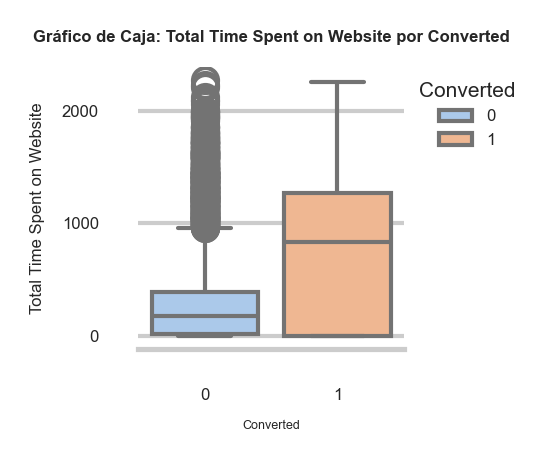

In [159]:
# Encontrar outliers 
detect_and_plot_outliers(df, 'Total Time Spent on Website', 'Converted')


In [217]:
estadisticas = calcular_estadisticas_conversion(df, "Total Time Spent on Website")


📊 Estadísticas para 'Total Time Spent on Website' - Converted = 0 (No Convertidos)
count    5679.000000
mean      330.404473
std       432.231915
min         0.000000
25%        16.000000
50%       179.000000
75%       393.000000
max      2272.000000
Name: Total Time Spent on Website, dtype: float64 

📊 Estadísticas para 'Total Time Spent on Website' - Converted = 1 (Convertidos)
count    3561.000000
mean      738.546757
std       615.656010
min         0.000000
25%         0.000000
50%       832.000000
75%      1268.000000
max      2253.000000
Name: Total Time Spent on Website, dtype: float64 



In [224]:
import numpy as np

# Encontrar el percentil más cercano a 500s
percentiles = np.arange(0.30, 0.60, 0.01)  # Rango de 30% a 60%
values = df[df['Converted'] == 1]['Total Time Spent on Website'].quantile(percentiles)

# Filtrar los percentiles más cercanos a 500s
values[values.between(450, 550)]


0.41    467.0
0.42    523.6
Name: Total Time Spent on Website, dtype: float64

## 📊 **Interpretación de los 500s en la Distribución**

📌 **500s es un valor cercano al percentil 41.5%** en la distribución de `Total Time Spent on Website` para los usuarios convertidos (`Converted = 1`).  

📌 **Es una buena referencia para describir la concentración de valores antes de la mediana (832s)**, ya que:  
- El **percentil 41% es 467s**.  
- El **percentil 42% es 523.6s**.  
- **500s se encuentra entre ambos valores**, lo que sugiere que es un punto de referencia útil antes de la mediana.  

🚀 **Conclusión**  
✔ 500s **no es un percentil exacto**, pero es **una buena aproximación del intervalo donde los valores empiezan a agruparse antes de la mediana**.  
  


## 📊 **Insights del Gráfico: Total Time Spent on Website por Converted**

| **Variable**                     | **Descripción**                                                                                  | **Observación del gráfico**                                                                                                           |
|----------------------------------|--------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------|
| **Variable dependiente (`Converted`)** | Representa si el usuario se convirtió (`1`) o no (`0`).                                           | Dos categorías: `0` (no convertido) y `1` (convertido).                                                                             |
| **Variable independiente (`Total Time Spent on Website`)** | Tiempo total que el usuario pasó en el sitio web.                                                 | Los usuarios convertidos (`1`) tienen tiempos significativamente más altos en comparación con los no convertidos (`0`).             |
| **Distribución para `Converted = 0`**   | Usuarios que no se convirtieron.                                                                | **Mediana: 179s**, con valores concentrados entre **16s y 393s**. Muchos outliers superan los **2000s**, indicando usuarios interesados que no convirtieron. |
| **Distribución para `Converted = 1`**   | Usuarios que se convirtieron.                                                                   | **Mediana: 832s**, con valores concentrados entre **500s y 1268s**. Hay menos outliers en este grupo, lo que sugiere mayor consistencia. |
| **Relación entre las variables**         | Cómo se relaciona el tiempo en el sitio web con la conversión.                                   | Los usuarios que pasan más tiempo en el sitio tienen mayor probabilidad de convertirse, pero también hay conversiones rápidas (0s en algunos casos). |

---

## 📌 **Insights Clave**
1️⃣ **Los usuarios convertidos (`Converted = 1`) tienen una mediana de tiempo en el sitio de 832s**, mucho más alta que los no convertidos (179s).  
2️⃣ **Existe un grupo de usuarios (`Converted = 0`) que pasaron más de 2000s en el sitio pero no convirtieron**, lo que indica una oportunidad para remarketing.  
3️⃣ **Algunos usuarios convertidos (`Converted = 1`) tienen `0s` de tiempo en el sitio**, lo que podría indicar conversiones inmediatas o errores en la medición.  

---

## 🚀 **Recomendaciones**
### ✅ **1. Mejorar la experiencia en el sitio para aumentar la conversión**
- Analizar **qué páginas tienen más tiempo promedio** y optimizarlas para facilitar la conversión.  
- Implementar **contenido interactivo** o **recomendaciones personalizadas** para retener a los usuarios.  

### ✅ **2. Segmentar y reimpactar leads interesados pero no convertidos**
- Identificar **usuarios con más de 1000s en el sitio que no convirtieron**.  
- Enviarles **mensajes personalizados** o **ofertas especiales** para incentivar la conversión.  

### ✅ **3. Evaluar conversiones con `0s` en tiempo**
- Investigar si las conversiones instantáneas son **errores en la medición** o **usuarios recurrentes** que ya conocían el sitio.  
- Ajustar el **tracking de tiempo en el sitio** para capturar datos más precisos.  

---

📌 **Conclusión:**  
✔ El tiempo en el sitio es un factor clave en la conversión, pero también hay conversiones rápidas que deben analizarse.  
✔ Los usuarios que pasan **mucho tiempo pero no convierten** representan una **gran oportunidad de remarketing**.  
✔ Mejorar la experiencia en el sitio puede **aumentar el tiempo promedio y la tasa de conversión**. 🚀  


## Gráfico de Caja de 'Page Views Per Visit'

Límite inferior: -2.0, Límite superior: 6.0


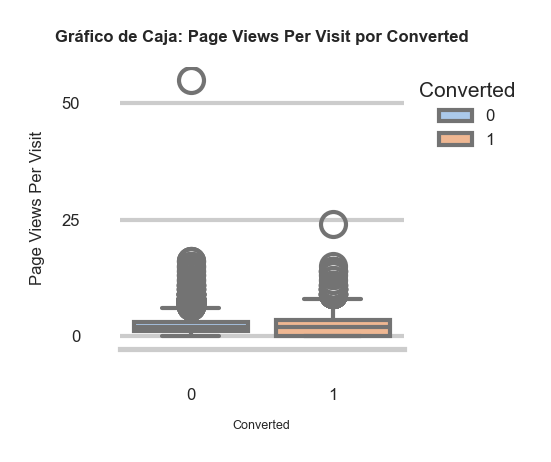

In [161]:
# Encontrar outliers 
detect_and_plot_outliers(df, 'Page Views Per Visit', 'Converted')

In [228]:
estadisticas = calcular_estadisticas_conversion(df, "Page Views Per Visit")

📊 Estadísticas para 'Page Views Per Visit' - Converted = 0 (No Convertidos)
count    5679.000000
mean        2.366052
std         2.168163
min         0.000000
25%         1.000000
50%         2.000000
75%         3.000000
max        55.000000
Name: Page Views Per Visit, dtype: float64 

📊 Estadísticas para 'Page Views Per Visit' - Converted = 1 (Convertidos)
count    3561.000000
mean        2.343707
std         2.109825
min         0.000000
25%         0.000000
50%         2.000000
75%         3.330000
max        24.000000
Name: Page Views Per Visit, dtype: float64 



## 📊 Insights del Gráfico: Page Views Per Visit por Converted

| **Aspecto Analizado**                      | **Descripción**                                                                                      | **Observación del gráfico**                                                                                                     |
|--------------------------------------------|------------------------------------------------------------------------------------------------------|------------------------------------------------------------------------------------------------------------------------------|
| **Promedio de vistas de página por visita** | En promedio, los usuarios convertidos y no convertidos ven un número similar de páginas por visita. | Las medianas para ambas categorías (`Converted = 0` y `Converted = 1`) son **exactamente 2.0**, lo que indica poca diferencia. |
| **Rango Intercuartílico (IQR) más amplio**  | `Converted = 1` tiene un IQR mayor, lo que sugiere mayor variabilidad en las vistas de página.      | Aunque `Converted = 1` tiene un rango más amplio, muchos usuarios tienen valores bajos (percentil 25% = 0).                    |
| **Outliers significativos**                 | El máximo valor registrado en `Converted = 0` es **55 páginas por visita**, lo que es un outlier claro. | Este outlier podría ser un competidor, un usuario explorando excesivamente, o una actividad atípica.                          |

---

## 📌 Insights detallados:

1️⃣ **El número de vistas de página no es un factor diferenciador fuerte para la conversión.**  
   - La **mediana es idéntica para ambos grupos (2.0)**.  
   - Esto sugiere que **ver más páginas no necesariamente aumenta la conversión**.

2️⃣ **Mayor dispersión para `Converted = 1`, pero con valores bajos.**  
   - `Converted = 1` tiene un **IQR más amplio porque el percentil 25% es 0**, lo que significa que **un grupo considerable de usuarios convirtió tras ver pocas páginas**.  
   - **Esto podría indicar que una buena experiencia de usuario facilita conversiones rápidas.**

3️⃣ **El outlier de 55 páginas es inusual y está en `Converted = 0`.**  
   - Este valor es **muy superior al percentil 75% (3.0 - 3.33)**.  
   - Podría representar un **usuario explorando mucho sin intención de compra, un competidor analizando el sitio, o un error en la medición.**  

---

## 🚀 Recomendaciones:

1️⃣ **Optimizar la navegación y experiencia de usuario.**  
   - Si algunos usuarios convierten viendo solo **1 o 2 páginas**, asegurar que la información clave sea accesible rápidamente.  

2️⃣ **Revisar las visitas con valores extremadamente altos en `Page Views Per Visit`.**  
   - Si estos valores no representan clientes reales, considerar filtrarlos en futuros análisis.  

3️⃣ **Evaluar la relación entre `Page Views Per Visit` y `Total Time Spent on Website`.**  
   - Un usuario puede ver **muchas páginas rápidamente sin interés real**, o pocas páginas pero con más tiempo de permanencia.  
   - **Combinar ambas métricas** podría ayudar a entender mejor la conversión.  

---

## 🔍 **Conclusión Final**
✔ **El número de páginas vistas por visita no es un factor clave de conversión, ya que la mediana es la misma para ambos grupos.**  
✔ **Convertir con pocas páginas vistas puede indicar una experiencia de usuario eficiente.**  
✔ **Los valores extremos en `Converted = 0` deben analizarse para descartar comportamientos atípicos o no relevantes.**  



## Gráfico de Caja de 'TotalVisits'

Límite inferior: -5.0, Límite superior: 11.0


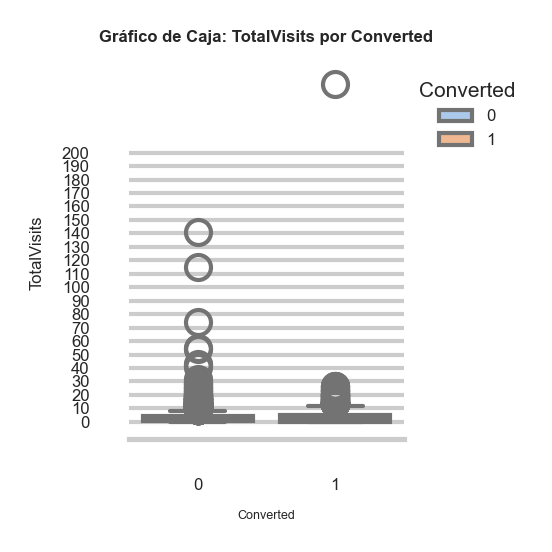

In [229]:
detect_and_plot_outliers(
    df, 
    col_independiente='TotalVisits', 
    col_dependiente='Converted', 
    rango_y=(0, 200, 10),  # Ajustar rango e intervalos del eje Y
    figsize=(2, 2)       # Incrementar el tamaño del gráfico
)


In [230]:
estadisticas = calcular_estadisticas_conversion(df, "TotalVisits")

📊 Estadísticas para 'TotalVisits' - Converted = 0 (No Convertidos)
count    5679.000000
mean        3.327522
std         4.345521
min         0.000000
25%         1.000000
50%         3.000000
75%         4.000000
max       141.000000
Name: TotalVisits, dtype: float64 

📊 Estadísticas para 'TotalVisits' - Converted = 1 (Convertidos)
count    3561.000000
mean        3.615838
std         5.486307
min         0.000000
25%         0.000000
50%         3.000000
75%         5.000000
max       251.000000
Name: TotalVisits, dtype: float64 



## 📊 Insights del Gráfico: TotalVisits por Converted

| **Aspecto Analizado**               | **Descripción**                                                                                     |
|-------------------------------------|-----------------------------------------------------------------------------------------------------|
| **Mediana de visitas similares**    | La mediana de `TotalVisits` es **3.0** tanto para `Converted = 0` como para `Converted = 1`.       |
| **Variabilidad en `Converted = 1`** | `Converted = 1` tiene un **IQR más amplio (5 vs 3 en `Converted = 0`)**, lo que indica más dispersión. |
| **Valores extremos presentes**      | Se observan outliers en ambos grupos, especialmente en `Converted = 1`, con un **máximo de 251 visitas**. |

---

## 📌 **Análisis detallado**
1️⃣ **Mediana idéntica en ambos grupos (3.0).**  
   - **El número total de visitas no parece ser un factor diferenciador fuerte para la conversión.**  
   - **Ambos grupos tienen la misma mediana**, lo que indica que **el número de visitas por sí solo no predice la conversión**.  

2️⃣ **Mayor dispersión en `Converted = 1`.**  
   - En `Converted = 1`, el **IQR es más amplio (5 - 0 = 5) que en `Converted = 0` (4 - 1 = 3)**.  
   - Esto sugiere que **algunos usuarios convierten con muy pocas visitas, mientras que otros requieren más interacciones**.  

3️⃣ **Presencia de valores extremos (outliers).**  
   - En `Converted = 1`, **hay usuarios con hasta 251 visitas**, lo que sugiere comportamientos atípicos.  
   - **Estos valores podrían corresponder a usuarios indecisos o casos especiales** (por ejemplo, tráfico no real o bots).  
   - **Filtrar valores superiores a 30 visitas ayuda a reducir el impacto de outliers en el análisis**.  

---

## 🚀 **Recomendaciones**
✔ **Investigar la relación entre `TotalVisits` y otras métricas como `Total Time Spent on Website`** para entender mejor los patrones de conversión.  
✔ **Analizar a los usuarios que convierten con pocas visitas** para determinar qué factores adicionales influyen en su decisión.  
✔ **Revisar los outliers extremos (más de 30 visitas) para descartar tráfico irrelevante, bots o usuarios indecisos.**  

---

## 🔍 **Conclusión Final**
✔ **El número total de visitas no es un predictor claro de conversión.**  
✔ **La mayor dispersión en `Converted = 1` sugiere que hay diferentes patrones de conversión: algunos usuarios convierten rápido, otros requieren más interacciones.**  
✔ **Los outliers deben revisarse para entender mejor los casos extremos.**  


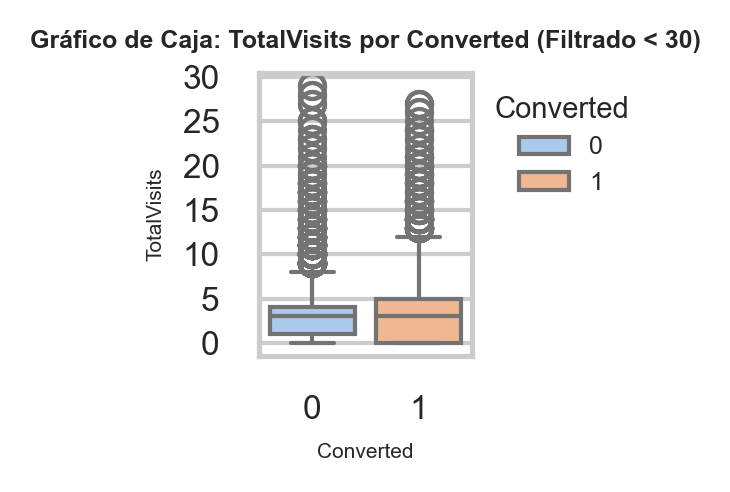

In [163]:
# Filtrar y graficar sin outliers mayores a 30
plt.figure(figsize=(2, 1.8), dpi=300)
ax = sns.boxplot(
    y='TotalVisits',
    data=df[df['TotalVisits'] < 30],
    x='Converted',
    hue='Converted',
    palette="pastel"
)

# Título y etiquetas
plt.title("Gráfico de Caja: TotalVisits por Converted (Filtrado < 30)", fontsize=6, fontweight='bold')
plt.xlabel("Converted", fontsize=5)
plt.ylabel("TotalVisits", fontsize=5)
plt.xticks(fontsize=8)

# Ajustar el rango del eje Y
rango_y = (0, 30, 5)  # Rango del eje Y: inicio, fin, intervalo
plt.yticks(ticks=range(rango_y[0], rango_y[1] + 1, rango_y[2]), fontsize=8)

# Ajustar la leyenda
ax.legend(
    title="Converted",
    fontsize=6,
    title_fontsize=7,
    loc="upper left",          # Posicionar en la esquina superior izquierda
    bbox_to_anchor=(1, 1),    # Ajustar posición ligeramente fuera del gráfico
    frameon=False              # Sin fondo opaco
)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


### **Insights del Gráfico: TotalVisits por Converted (Filtrado < 30)**

| **Aspecto Analizado**                  | **Descripción**                                                                                   | **Observación del gráfico**                                                                                             |
|----------------------------------------|---------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------------------|
| **Mediana de visitas por grupo**       | Los leads que convierten (`Converted = 1`) tienen una mediana ligeramente mayor que los que no convierten (`Converted = 0`). | Esto sugiere que los leads convertidos visitan el sitio más frecuentemente en comparación con los no convertidos.        |
| **Rango Intercuartílico (IQR)**        | Los leads convertidos tienen un IQR más amplio que los no convertidos.                           | Esto indica una mayor dispersión en las visitas totales para los leads que convierten, lo que puede reflejar distintos comportamientos. |
| **Outliers dentro del rango**          | Aunque el filtro eliminó outliers extremos (>30), todavía se observan algunos valores atípicos menores. | Estos valores podrían representar leads con comportamientos únicos que vale la pena analizar.                            |

---

### **Insights detallados:**
1. **Mayor frecuencia de visitas para convertidos:**
   - Los leads convertidos tienden a visitar el sitio más veces en promedio que los no convertidos, aunque la diferencia no es muy significativa.

2. **Mayor dispersión en visitas para convertidos:**
   - El rango intercuartílico más amplio para los leads convertidos sugiere que hay más variabilidad en la cantidad de visitas realizadas por este grupo.
   - Esto podría reflejar diferentes niveles de interés o comportamiento antes de tomar la decisión de compra.

3. **Persistencia de valores atípicos menores:**
   - Incluso con el filtro aplicado (<30), algunos valores atípicos permanecen en ambos grupos. 
   - Estos casos pueden representar leads con necesidades o intereses específicos que los hacen destacar.

---

### **Recomendaciones:**
1. **Segmentar por frecuencia de visitas:**
   - Analizar a los leads que visitan el sitio con más frecuencia dentro del rango permitido para identificar patrones que conduzcan a conversiones.

2. **Explorar la dispersión para convertidos:**
   - Investigar qué factores explican la variabilidad en el grupo de leads convertidos, como el contenido visitado o el tiempo en cada visita.

3. **Combinar métricas:**
   - Utilizar esta métrica junto con otras variables como `Total Time Spent on Website` para identificar combinaciones que predigan conversiones con mayor precisión.

---

### **Comentarios finales:**
- **El número total de visitas ajustado (<30) proporciona un análisis más claro de las diferencias entre los leads convertidos y no convertidos.**
- **El comportamiento de los outliers menores merece atención adicional para determinar su relevancia en el proceso de conversión.**


## 📌 **¿Cómo afectan los outliers a la Regresión Logística?**  

✔ La Regresión Logística es menos sensible a outliers que modelos lineales como la Regresión Lineal, pero aún pueden afectar el modelo en ciertos casos:  

### 🔍 **Impacto de los outliers en la Regresión Logística**  

| **Problema**                  | **Descripción** |
|--------------------------------|----------------------------------------------------------------------------------------------------------------------------------|
| **1️⃣ Coeficientes sesgados**  | Los outliers pueden afectar los pesos (`β`) asignados a cada variable, especialmente si tienen valores extremos. |
|                                | 📌 *Ejemplo:* Si `TotalVisits` tiene valores atípicos muy altos (251 visitas), la relación entre visitas y conversión podría distorsionarse. |
| **2️⃣ Problemas en la convergencia** | Si hay outliers con valores muy grandes, pueden afectar la optimización del modelo, haciendo que tarde más en converger o sea inestable. |
| **3️⃣ Escalamiento de variables**  | Aunque la Regresión Logística no depende de la escala, si una variable tiene valores extremos grandes, puede dominar el modelo. |
|                                | 🔹 *Solución:* **Estandarizar o normalizar** las variables antes de entrenar el modelo. |

---

## 🚀 **¿Qué hacer con los outliers en Regresión Logística?**  

| **Opción**        | **Descripción** |
|-------------------|------------------------------------------------------------------|
| **🔹 Opción 1: Mantenerlos** | Si los outliers representan datos reales (por ejemplo, usuarios con 251 visitas), se pueden conservar. |
|                             | 📌 *Solución:* Aplicar **transformación logarítmica** o **normalización** para evitar que dominen el modelo. |
| **🔹 Opción 2: Filtrar valores extremos** | Si los outliers parecen errores o datos poco representativos, eliminarlos mejora la estabilidad del modelo. |
|                             | 📌 *Métodos:* **Rango intercuartílico (IQR)** o percentiles (`df = df[df["TotalVisits"] < umbral]`). |
| **🔹 Opción 3: Comparar modelos** | Entrenar la Regresión Logística en **dos versiones**: |
|                             | ✅ Una con los outliers. |
|                             | ✅ Otra sin los outliers. |
|                             | 📊 Luego, comparar métricas como **accuracy, recall y precision** para decidir cuál modelo es mejor. |

---

## 📌 **Conclusión**  

✔ **La Regresión Logística puede verse afectada por outliers, pero no siempre es necesario eliminarlos.**  
✔ **Dependerá de si afectan la estabilidad del modelo o si representan datos válidos.**  
✔ **Estandarizar, filtrar o transformar los valores son estrategias clave a considerar.**  


# 📌 **Estrategias para Manejar Outliers en las Variables Analizadas**  

| **Variable**                      | **Cómo Detectar Outliers**                                                                                   | **Cómo Eliminar o Ajustar**                                                                                | **Posibles Ajustes** |
|-----------------------------------|-------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------------|----------------------|
| **Total Time Spent on Website**   | Usar `detect_and_plot_outliers(df, "Total Time Spent on Website", "Converted")` para visualizar los outliers. | Aplicar `remove_outliers(df, "Total Time Spent on Website")` si los valores extremos no representan casos reales. | Ajustar `1.5 * IQR` a `2.0 * IQR` si la variabilidad es natural. |
| **Page Views Per Visit**          | Usar `detect_and_plot_outliers(df, "Page Views Per Visit", "Converted")` para visualizar los outliers.       | Aplicar `remove_outliers(df, "Page Views Per Visit")` o probar `winsorization` (reemplazo de extremos).      | Considerar transformación logarítmica para suavizar los valores. |
| **TotalVisits**                   | Usar `detect_and_plot_outliers(df, "TotalVisits", "Converted")` para visualizar los outliers.                 | Usar `remove_outliers(df, "TotalVisits")` o filtrar manualmente valores superiores a `percentil 99`.         | Probar `1.5 * IQR` vs. `3.0 * IQR` para no perder datos relevantes. |

---

## 🛠 **Opciones de Ajuste en `remove_outliers`**

| **Método**                           | **Descripción**                                                                 | **Código** |
|--------------------------------------|---------------------------------------------------------------------------------|------------|
| **IQR (1.5 veces el rango intercuartílico)** | Método estándar para eliminar outliers fuera de 1.5 veces el IQR.               | ```python<br>lower_bound = q1 - 1.5 * iqr<br>upper_bound = q3 + 1.5 * iqr``` |
| **Ajuste si hay demasiados outliers eliminados** | Aumentar el umbral a 2.0 veces el IQR para reducir la eliminación excesiva.    | ```python<br>lower_bound = q1 - 2.0 * iqr<br>upper_bound = q3 + 2.0 * iqr``` |
| **Transformación logarítmica**       | Reduce el impacto de valores altos sin eliminarlos. `np.log1p(x)` es equivalente a `log(x + 1)`, lo que ayuda a manejar valores cercanos a 0 sin errores. | ```python<br>df[col] = np.log1p(df[col])  # log(col + 1) para evitar log(0)``` |
| **Winsorization**                    | Recorta valores extremos reemplazándolos por percentiles en lugar de eliminarlos. | ```from scipy.stats.mstats import winsorize<br>df[col] = winsorize(df[col], limits=[0.01, 0.01])  # Recorta el 1% de valores extremos``` |

---

## 🛠 **Orden recomendado para Transformación Logarítmica, Winsorization y Eliminación de Outliers**

| **Caso**                              | **Método aplicado**        | **Orden recomendado**                                      | **Motivo** |
|--------------------------------------|-------------------------|------------------------------------------------|------------|
| **Caso 1: Solo eliminación de outliers** | `remove_outliers()`      | 🔹 1️⃣ Aplicar `remove_outliers(df, col)`         | Se eliminan valores extremos antes de aplicar cualquier otra técnica. |
| **Caso 2: Eliminación de outliers + Transformación logarítmica** | `remove_outliers()` + `np.log1p()` | 🔹 1️⃣ Aplicar `remove_outliers(df, col)` <br> 🔹 2️⃣ Aplicar `df[col] = np.log1p(df[col])` | La transformación logarítmica suaviza los valores, pero no los elimina. Si se aplica antes, los outliers pueden seguir afectando. |
| **Caso 3: Winsorization + Eliminación de outliers** | `winsorize()` + `remove_outliers()` | 🔹 1️⃣ Aplicar `df[col] = winsorize(df[col], limits=[0.01, 0.01])` <br> 🔹 2️⃣ Aplicar `remove_outliers(df, col)` | Winsorization reemplaza valores extremos en lugar de eliminarlos, por lo que es mejor aplicarla antes de decidir eliminar datos. |
| **Caso 4: Winsorization + Transformación logarítmica + Eliminación de outliers** | `winsorize()` + `np.log1p()` + `remove_outliers()` | 🔹 1️⃣ Aplicar `df[col] = winsorize(df[col], limits=[0.01, 0.01])` <br> 🔹 2️⃣ Aplicar `remove_outliers(df, col)` <br> 🔹 3️⃣ Aplicar `df[col] = np.log1p(df[col])` | Se suavizan valores extremos con Winsorization, se eliminan valores aún problemáticos y luego se aplica la transformación logarítmica. |

---

## 🛠 **Ajustes de Winsorization (`limits=[a, b]`)**

| **Límite aplicado (`limits=[a, b]`)** | **¿Qué hace?** |
|--------------------------------|----------------------------------------------|
| `limits=[0.01, 0.01]` | Recorta el **1% en ambos extremos** (inferior y superior). |
| `limits=[0.05, 0.05]` | Recorta el **5% en ambos extremos**. Más agresivo. |
| `limits=[0, 0.02]` | **Solo recorta el 2% de los valores más altos**. |
| `limits=[0.03, 0]` | **Solo recorta el 3% de los valores más bajos**. |

---

## 🚀 **¿Cuándo cambiar los valores en `limits`?**
✔ **Si los valores extremos afectan mucho el análisis**, aumenta el porcentaje (`0.05, 0.05`).  
✔ **Si solo quieres ajustar valores altos o bajos, pon `0` en el lado que no quieres modificar.**  
✔ **Si los datos tienen muchos valores atípicos, prueba con `limits=[0.02, 0.02]` en lugar de `0.01, 0.01`.**  

---

## 📌 **Conclusión y Próximos Pasos**
✔ **Si solo necesitas limpiar datos extremos, usa `remove_outliers()` (Caso 1).**  
✔ **Si planeas usar `np.log1p()`, primero elimina outliers y luego aplica la transformación logarítmica (Caso 2).**  
✔ **Si prefieres suavizar valores en lugar de eliminarlos, usa Winsorization antes de eliminar outliers (Caso 3).**  
✔ **Si quieres combinar Winsorization, eliminación de outliers y logaritmo, sigue el orden del Caso 4.**  

📌 **Siguiente paso:**  
➡ **Prueba estos métodos en tu dataset y analiza cómo cambia la distribución de los datos.**  
➡ **Compara el impacto en el modelo antes y después de aplicar cada técnica.**  

🚀 **¡Ahora pueden probar estos ajustes en su dataset y decidir qué estrategia es la mejor!**


In [164]:
df

,Lead Origin,Lead Source,Do Not Email,Do Not Call,Converted,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Last Activity,Country,...,Receive More Updates About Our Courses,Update me on Supply Chain Content,Get updates on DM Content,Lead Profile,City,Asymmetrique Activity Score,Asymmetrique Profile Score,I agree to pay the amount through cheque,A free copy of Mastering The Interview,Last Notable Activity
Lead Number,,,,,,,,,,,,,,,,,,,,,
660737,API,Olark Chat,False,False,0,0.0,0,0.00,Page Visited on Website,Desconocido,...,False,False,False,Desconocido,Desconocido,15.0,15.0,False,False,Modified
660728,API,Organic Search,False,False,0,5.0,674,2.50,Email Opened,India,...,False,False,False,Desconocido,Desconocido,15.0,15.0,False,False,Email Opened
660727,Landing Page Submission,Direct Traffic,False,False,1,2.0,1532,2.00,Email Opened,India,...,False,False,False,Potential Lead,Mumbai,14.0,20.0,False,True,Email Opened
660719,Landing Page Submission,Direct Traffic,False,False,0,1.0,305,1.00,Unreachable,India,...,False,False,False,Desconocido,Mumbai,13.0,17.0,False,False,Modified
660681,Landing Page Submission,Google,False,False,1,2.0,1428,1.00,Converted to Lead,India,...,False,False,False,Desconocido,Mumbai,15.0,18.0,False,False,Modified
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
579564,Landing Page Submission,Direct Traffic,True,False,1,8.0,1845,2.67,Email Marked Spam,Saudi Arabia,...,False,False,False,Potential Lead,Mumbai,15.0,17.0,False,False,Email Marked Spam
579546,Landing Page Submission,Direct Traffic,False,False,0,2.0,238,2.00,SMS Sent,India,...,False,False,False,Potential Lead,Mumbai,14.0,19.0,False,True,SMS Sent
579545,Landing Page Submission,Direct Traffic,True,False,0,2.0,199,2.00,SMS Sent,India,...,False,False,False,Potential Lead,Mumbai,13.0,20.0,False,True,SMS Sent


## Desarrollo del Modelo de Regresión Logística

In [165]:
df.shape

(9240, 31)

In [166]:
# Generar variables predictoras (excluyendo 'Converted')
X = pd.get_dummies(df.drop(columns='Converted', axis=1), drop_first=True)

# Variable dependiente
y = df['Converted']

# Convertir columnas booleanas de X a enteros  dummies puede introducir columnas booleanas 
X = X.apply(lambda col: col.astype(int) if col.dtypes == 'bool' else col)

In [167]:
X.shape

(9240, 161)

### Guardo el archivo con los cambios (archivo preprocesado)

In [168]:
X_pred = X.copy()
X_pred['Converted'] = y

# Guardar la copia en un archivo CSV
X_pred.to_csv('../data/XOE_pre.csv', index=True)

In [170]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=99, 
    stratify=y)


### stratify

In [231]:
print("Distribución en y_train:")
print(y_train.value_counts(normalize=True))

print("\nDistribución en y_test:")
print(y_test.value_counts(normalize=True))


Distribución en y_train:
Converted
0    0.614583
1    0.385417
Name: proportion, dtype: float64

Distribución en y_test:
Converted
0    0.614719
1    0.385281
Name: proportion, dtype: float64


## 📌 Efecto de `stratify=y` en `train_test_split`

Cuando usamos el parámetro `stratify=y` en `train_test_split`, garantizamos que las proporciones de clases en los conjuntos de entrenamiento y evaluación se mantengan similares a las del conjunto original.

| **Proporción de Clases** | **Conjunto de Entrenamiento (`y_train`)** | **Conjunto de Evaluación (`y_test`)** |
|---------------------------|---------------------------------|---------------------------------|
| **Clase 0** (`Converted = 0`) | 61.46% | 61.47% |
| **Clase 1** (`Converted = 1`) | 38.54% | 38.53% |

---

### 🔍 **Explicación**
1️⃣ **Sin `stratify=y`**, la proporción de clases podría variar en los conjuntos de entrenamiento y evaluación, lo que afectaría la representatividad de los datos.  
2️⃣ **Con `stratify=y`**, las proporciones de clases se mantienen consistentes, asegurando que ambos conjuntos reflejen fielmente la distribución original de los datos.  

✅ **En este caso, `stratify=y` funcionó correctamente**, manteniendo la distribución de clases prácticamente **idéntica** entre `y_train` y `y_test`.  
🚀 **¡Ahora el conjunto de datos está listo para el modelado!**



### Escalado de variables utilizando MixMaxScaler

### Generamos la lista de variables escalar

In [171]:
var_escalar = ['TotalVisits', 'Total Time Spent on Website','Page Views Per Visit']

#### Creamos la instancia MinMaxScaler (0 a 1)  No asumimos una distribución Normal si tiene una distribución normal la estandarización Z es la mas adecuada

In [172]:
scaler = MinMaxScaler()

#### Transformamos las variables con MixMaxScaler del entrenamiento (aplicamos **fit**)


In [173]:
X_train[var_escalar] = scaler.fit_transform(X_train[var_escalar])

In [174]:
X_train.head(3)

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
Lead Number,,,,,,,,,,,,,,,,,,,,,
627877,0,0,0.015936,0.672975,0.072727,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
585642,0,0,0.015936,0.079225,0.036364,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
617566,0,0,0.023904,0.453345,0.054545,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


#### Transformamos las variables con **MixMaxScaler** del set de evaluacion (solo usamos **transform** para aplicar los mismos parámetros ya calculados, asegurando la coherencia y evitando el sesgo en nuestro modelo.

In [175]:
X_test[var_escalar] = scaler.transform(X_test[var_escalar])

In [176]:
X_test.head(3)

,Do Not Email,Do Not Call,TotalVisits,Total Time Spent on Website,Page Views Per Visit,Search,Magazine,Newspaper Article,X Education Forums,Newspaper,...,Last Notable Activity_Form Submitted on Website,Last Notable Activity_Had a Phone Conversation,Last Notable Activity_Modified,Last Notable Activity_Olark Chat Conversation,Last Notable Activity_Page Visited on Website,Last Notable Activity_Resubscribed to emails,Last Notable Activity_SMS Sent,Last Notable Activity_Unreachable,Last Notable Activity_Unsubscribed,Last Notable Activity_View in browser link Clicked
Lead Number,,,,,,,,,,,,,,,,,,,,,
591899,0,0,0.015936,0.173856,0.024182,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
604007,0,0,0.019920,0.412852,0.090909,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
653773,0,0,0.011952,0.111356,0.054545,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 📌 ¿Por qué escalar después de dividir los datos?

Escalar antes o después de dividir los datos afecta la validez del modelo. La diferencia clave es el **riesgo de fuga de datos (data leakage)** si se escala antes de la división.

| **Aspecto**                      | **Escalar Antes de Dividir** ❌ (Incorrecto)                              | **Escalar Después de Dividir** ✅ (Correcto)                           |
|----------------------------------|------------------------------------------------------------------------|------------------------------------------------------------------------|
| **Momento del escalado**         | Antes de dividir los datos.                                           | Después de dividir los datos.                                         |
| **Datos usados en el escalado**  | Usa **todos los datos** (entrenamiento + prueba) para calcular estadísticas globales. | Usa **solo los datos de entrenamiento** para calcular las estadísticas. |
| **Riesgo de fuga de datos**      | 🚨 **Sí.** El conjunto de prueba influye en el escalado del entrenamiento, introduciendo un sesgo. | ✅ **No.** El conjunto de prueba no afecta el escalado del entrenamiento. |
| **Validez del escalado**         | ❌ **Inválido.** Incluye información del conjunto de prueba.            | ✅ **Válido.** Se basa solo en los datos de entrenamiento.             |
| **Evaluación del modelo**        | ⚠️ **Optimista.** El modelo parece mejor de lo que realmente es.       | 📊 **Realista.** Simula datos no vistos en el mundo real.             |

---

### 🔍 **Resumen**
Escalar **antes** de dividir los datos genera **fuga de información**, porque el escalador aprende estadísticas globales (**mínimo, máximo, media, desviación estándar**) de todo el dataset, incluyendo el conjunto de prueba. Esto introduce un sesgo en el modelo y hace que su evaluación sea poco realista.

📌 **La mejor práctica es:**  
1️⃣ **Dividir los datos primero.**  
2️⃣ **Escalar solo con `X_train`.**  
3️⃣ **Usar el mismo escalador para transformar `X_test` sin volver a ajustarlo (`fit`).**  

🚀 **Siguiendo este orden, garantizamos que el modelo se entrene con información realista y generalice correctamente a datos nuevos.**


#### Crear el modelo de regresión logística

In [234]:
modelo_lr = LogisticRegression(random_state=99, max_iter=1000) 

#### Entrenar el modelo con los datos de entrenamiento

In [235]:
modelo_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=99)

#### Predecir las probabilidades en el conjunto de evaluación


| **Paso**                                    | **Explicación**                                                                                                          |
|---------------------------------------------|--------------------------------------------------------------------------------------------------------------------------|
| **`modelo_lr.predict_proba(X_evaluacion)`** | Genera una matriz de probabilidades para cada muestra en `X_evaluacion`. Cada fila contiene: `[P(clase=0), P(clase=1)]`. |
| **`[:, 1]`**                                | Selecciona la **segunda columna** (índice `1`), que representa las probabilidades de la **clase positiva (clase 1)**.     |
| **Resultado (`y_pred`)**                    | Un arreglo unidimensional con las probabilidades de que cada muestra pertenezca a la clase `1`.                          |

### Ejemplo

Supongamos que `modelo_lr.predict_proba(X_evaluacion)` genera la siguiente matriz para 3 muestras:

| **Muestra** | **P(clase=0)** | **P(clase=1)** |
|-------------|----------------|----------------|
| Muestra 1   | 0.2            | 0.8            |
| Muestra 2   | 0.6            | 0.4            |
| Muestra 3   | 0.1            | 0.9            |

Después de aplicar `[:, 1]`, el resultado de `y_pred` será:

| **Muestra** | **Probabilidad de clase 1 (y_pred)** |
|-------------|-------------------------------------|
| Muestra 1   | 0.8                                 |
| Muestra 2   | 0.4                                 |
| Muestra 3   | 0.9                                 |

### ¿Por qué es útil?

- **Curvas ROC/AUC**: Necesitas las probabilidades para evaluar el desempeño del modelo a diferentes umbrales.
- **Ajustar umbrales de decisión**: Si el umbral estándar (0.5) no es adecuado, puedes ajustarlo con base en estas probabilidades.
- **Análisis de confianza**: Permite saber cuán seguro está el modelo en sus predicciones.



In [236]:
y_pred = modelo_lr.predict_proba(X_test)[:, 1]

In [237]:
y_pred

array([0.34972057, 0.90408562, 0.0698706 , ..., 0.11867537, 0.98477074,
       0.05450577], shape=(1848,))

#### AUC y ROC

### Función `roc_curve` en Scikit-learn

La función `roc_curve` de la biblioteca `sklearn.metrics` calcula métricas clave para evaluar el rendimiento de un modelo de clasificación a través de diferentes puntos de corte (umbrales).

#### ¿Qué calcula `roc_curve`?

| **Elemento**                 | **Descripción**                                                                                       |
|-------------------------------|-------------------------------------------------------------------------------------------------------|
| **Tasa de Verdaderos Positivos (TPR)** | También conocida como sensibilidad o recall. Es la proporción de positivos reales correctamente identificados por el modelo. |
| **Tasa de Falsos Positivos (FPR)**    | Proporción de negativos reales que el modelo clasificó incorrectamente como positivos.           |
| **Puntos de corte (thresholds)**      | Diferentes valores de umbrales de decisión utilizados para clasificar una predicción como positiva o negativa. |

#### ¿Qué es la Curva ROC?

La **curva ROC** (Receiver Operating Characteristic) es una representación gráfica de la capacidad del modelo para discriminar entre clases positivas y negativas. 
- **Eje X**: Tasa de Falsos Positivos (FPR).
- **Eje Y**: Tasa de Verdaderos Positivos (TPR).

Cada punto en la curva ROC corresponde a un par de TPR y FPR para un umbral específico.

#### ¿Cómo funciona `roc_curve`?

- Toma como entrada las **etiquetas verdaderas** (clases reales) y las **probabilidades predichas** por el modelo.
- Devuelve tres arrays separados:
  - **`fpr`**: Valores de la Tasa de Falsos Positivos.
  - **`tpr`**: Valores de la Tasa de Verdaderos Positivos.
  - **`thresholds`**: Los puntos de corte utilizados para calcular TPR y FPR.

#### ¿Por qué es útil?

- Permite evaluar cómo el modelo se comporta en distintos niveles de decisión.
- Ayuda a identificar un umbral óptimo dependiendo del contexto (por ejemplo, en problemas donde los falsos positivos o falsos negativos tienen costos distintos).
- Es una herramienta clave para calcular el **AUC (Área Bajo la Curva)**, que mide la capacidad global del modelo para discriminar entre las clases.

### Resumen

La función `roc_curve` es una herramienta poderosa para analizar el rendimiento de un modelo de clasificación, proporcionando una visión integral de cómo se comporta el modelo en diferentes configuraciones de umbrales.


In [238]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

In [239]:
fpr

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 8.80281690e-04,
       8.80281690e-04, 8.80281690e-04, 8.80281690e-04, 1.76056338e-03,
       1.76056338e-03, 2.64084507e-03, 2.64084507e-03, 2.64084507e-03,
       2.64084507e-03, 2.64084507e-03, 2.64084507e-03, 2.64084507e-03,
       2.64084507e-03, 3.52112676e-03, 3.52112676e-03, 3.52112676e-03,
       3.52112676e-03, 3.52112676e-03, 3.52112676e-03, 4.40140845e-03,
       4.40140845e-03, 5.28169014e-03, 5.28169014e-03, 5.28169014e-03,
       5.28169014e-03, 5.28169014e-03, 6.16197183e-03, 6.16197183e-03,
       6.16197183e-03, 6.16197183e-03, 7.04225352e-03, 7.04225352e-03,
       7.92253521e-03, 7.92253521e-03, 8.80281690e-03, 8.80281690e-03,
       8.80281690e-03, 8.80281690e-03, 9.68309859e-03, 9.68309859e-03,
       1.05633803e-02, 1.05633803e-02, 1.40845070e-02, 1.40845070e-02,
      

In [240]:
tpr

array([0.        , 0.00140449, 0.01123596, 0.01404494, 0.01685393,
       0.01966292, 0.02106742, 0.0238764 , 0.0252809 , 0.02808989,
       0.06882022, 0.06882022, 0.0758427 , 0.08005618, 0.08848315,
       0.08848315, 0.09269663, 0.09269663, 0.12640449, 0.13904494,
       0.14044944, 0.14325843, 0.20224719, 0.20505618, 0.20926966,
       0.20926966, 0.21067416, 0.21629213, 0.24297753, 0.24578652,
       0.29353933, 0.29353933, 0.3244382 , 0.3244382 , 0.33146067,
       0.33707865, 0.34410112, 0.3497191 , 0.3497191 , 0.35252809,
       0.36376404, 0.36797753, 0.36797753, 0.37078652, 0.37078652,
       0.37359551, 0.37359551, 0.375     , 0.37780899, 0.38061798,
       0.38061798, 0.38202247, 0.38202247, 0.38764045, 0.39185393,
       0.40589888, 0.41011236, 0.42977528, 0.42977528, 0.43398876,
       0.43398876, 0.4508427 , 0.4508427 , 0.45224719, 0.45224719,
       0.46067416, 0.46067416, 0.47191011, 0.47191011, 0.4747191 ,
       0.4747191 , 0.48455056, 0.48455056, 0.48735955, 0.48735

In [184]:
thresholds

array([           inf, 9.98975351e-01, 9.98597681e-01, 9.98450587e-01,
       9.93856749e-01, 9.93817660e-01, 9.91469414e-01, 9.91254658e-01,
       9.89172647e-01, 9.88969071e-01, 9.88797212e-01, 9.86906965e-01,
       9.86748191e-01, 9.84807108e-01, 9.84702345e-01, 9.79730648e-01,
       9.79621271e-01, 9.73376790e-01, 9.72990402e-01, 9.66287801e-01,
       9.66015051e-01, 9.63495913e-01, 9.63407900e-01, 9.57096850e-01,
       9.55844361e-01, 9.52124631e-01, 9.51875899e-01, 9.45282528e-01,
       9.43951164e-01, 9.41732579e-01, 9.41696899e-01, 9.34106778e-01,
       9.33632313e-01, 9.28073703e-01, 9.27339839e-01, 9.20869844e-01,
       9.20441413e-01, 9.19204587e-01, 9.18403928e-01, 9.16258986e-01,
       9.15339520e-01, 9.13112745e-01, 9.12530263e-01, 9.12018249e-01,
       9.10562073e-01, 9.09673400e-01, 9.09039053e-01, 9.08824582e-01,
       9.08688068e-01, 9.08687815e-01, 9.08645748e-01, 9.08469966e-01,
       9.07522963e-01, 9.05364749e-01, 9.03787570e-01, 9.01646468e-01,
      

#### Calcular el área bajo la curva (AUC)

AUC (Área Bajo la Curva): Es el área bajo la curva ROC. Este valor cuantifica qué tan bueno es el modelo para distinguir entre las clases. Un AUC de 1 significa un modelo perfecto, mientras que un AUC de 0.5 significa un modelo no mejor que un lanzamiento de moneda al azar.

In [241]:
auc_lr = auc(fpr, tpr)

In [242]:
auc_lr

np.float64(0.9212438429735719)

#### Graficar la curva ROC

### ROC: Curva Característica de Operación del Receptor

La **Curva ROC (Receiver Operating Characteristic)** es un gráfico que muestra el rendimiento de un modelo de clasificación en diferentes umbrales de decisión. Este gráfico traza dos parámetros clave:

| **Parámetro**                   | **Descripción**                                                                                         |
|----------------------------------|---------------------------------------------------------------------------------------------------------|
| **Tasa de Verdaderos Positivos (TPR)** | También llamada **sensibilidad** o **recall**. Se calcula como: $TPR = \frac{TP}{TP + FN}$, donde:  |
|                                  | - $TP$: Verdaderos Positivos.                                                                          |
|                                  | - $FN$: Falsos Negativos.                                                                              |
| **Tasa de Falsos Positivos (FPR)**    | Equivalente a $FPR = 1 - \text{Especificidad}$ o $FPR = \frac{FP}{FP + TN}$, donde:                  |
|                                  | - $FP$: Falsos Positivos.                                                                              |
|                                  | - $TN$: Verdaderos Negativos.                                                                          |

---

### **Lógica de la Curva ROC**

- La curva ROC evalúa la capacidad de un modelo para distinguir entre clases a través de diferentes **umbrales de decisión**.
- Al modificar el umbral que decide si una muestra se clasifica como positiva o negativa:
  - **TPR** (captura de verdaderos positivos) varía.
  - **FPR** (falsos positivos) también varía.
- Esto genera distintos pares de $(FPR, TPR)$ que se representan gráficamente.

---

### **¿Por qué es útil?**

- **Visualiza el trade-off** entre sensibilidad ($TPR$) y especificidad ($1 - FPR$).
- Muestra cómo se comporta el modelo a través de diferentes configuraciones de umbrales.
- Permite comparar modelos de clasificación mediante el área bajo la curva (AUC).

---

### **AUC: Área Bajo la Curva**

- El **AUC (Área Bajo la Curva)** proporciona una medida agregada del rendimiento del modelo en todos los umbrales posibles.
- **Interpretación del AUC**:
  - Un $AUC \approx 1.0$ indica un modelo excelente (capaz de maximizar $TPR$ mientras minimiza $FPR$).
  - Un $AUC = 0.5$ indica un modelo que no es mejor que un clasificador aleatorio.
- Cuanto mayor sea el AUC, mejor será el modelo para distinguir entre las clases.

---

### **Resumen**

La curva ROC y el AUC son herramientas esenciales para evaluar el rendimiento de los modelos de clasificación:
1. **Curva ROC**: Representa cómo varían $TPR$ y $FPR$ en diferentes umbrales.
2. **AUC**: Resume la calidad global del modelo para clasificar correctamente.

**Un modelo ideal tiene una curva ROC que se aproxima al rincón superior izquierdo (alta $TPR$ y baja $FPR$) y un $AUC$ cercano a 1.**


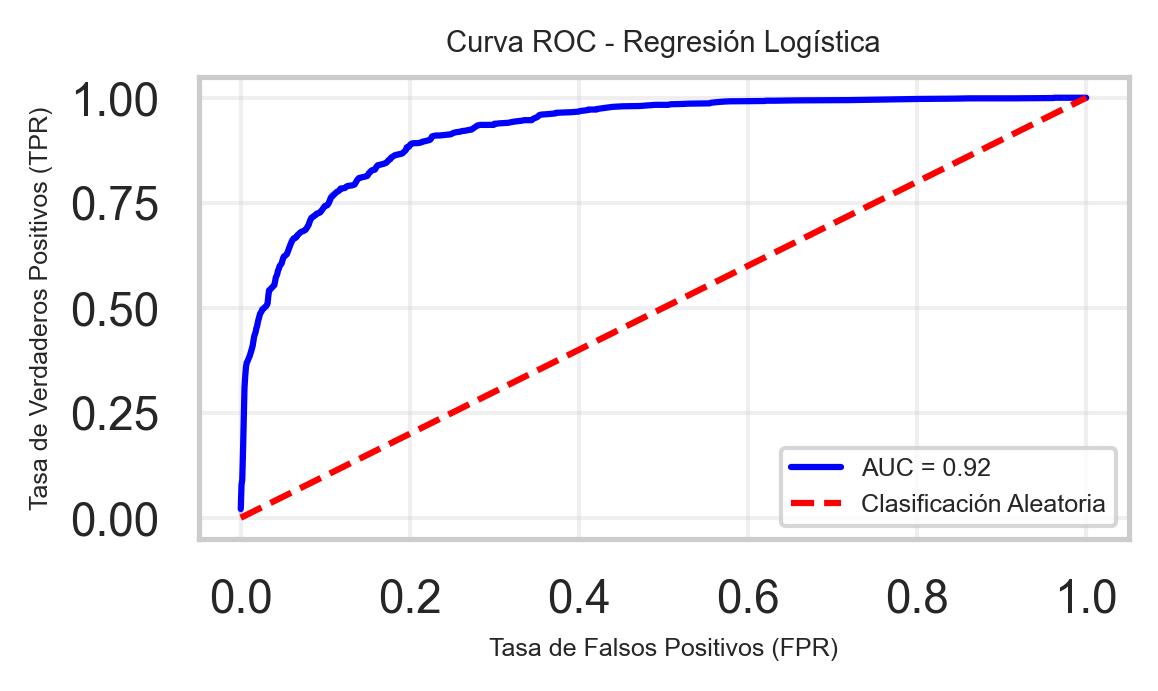

In [244]:
from sklearn.metrics import roc_curve, auc

# Calcular curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
auc_lr = auc(fpr, tpr)

# Crear figura
plt.figure(figsize=(4, 2), dpi=300)

# Gráfica de la curva ROC
sns.lineplot(x=fpr, y=tpr, label=f'AUC = {auc_lr:.2f}', color='blue')

# Línea diagonal (clasificador aleatorio)
sns.lineplot(x=[0, 1], y=[0, 1], color='red', linestyle='--', label="Clasificación Aleatoria")

# Etiquetas
plt.xlabel('Tasa de Falsos Positivos (FPR)', fontsize=6)  
plt.ylabel('Tasa de Verdaderos Positivos (TPR)', fontsize=6)  
plt.title('Curva ROC - Regresión Logística', fontsize=7)  

# Leyenda optimizada
plt.legend(loc='lower right', fontsize=6)  

# Grid para mejor visualización
plt.grid(alpha=0.3)

# Mostrar gráfica
plt.show()


## 📊 Evaluación del Modelo: Curva ROC y AUC

La Curva ROC (Receiver Operating Characteristic) evalúa el **rendimiento del modelo clasificando correctamente las clases** (`0` y `1`), comparando la **Tasa de Verdaderos Positivos (TPR)** contra la **Tasa de Falsos Positivos (FPR)** en distintos umbrales.

### 🔹 **Resultados del Modelo**
- **AUC = 0.92** → Indica que el modelo **tiene un excelente rendimiento** distinguiendo entre clases.
- **Una AUC cercana a 1** significa que el modelo separa bien los casos positivos y negativos.
- **Una AUC de 0.5** indicaría que el modelo es aleatorio y no tiene capacidad predictiva.

---

### 📈 **Interpretación de la Curva ROC**
| **Métrica**        | **Significado** |
|--------------------|----------------|
| **FPR (False Positive Rate)** | Falsos positivos sobre el total de negativos (`FP / (FP + TN)`). Queremos que sea **bajo**. |
| **TPR (True Positive Rate)**  | Verdaderos positivos sobre el total de positivos (`TP / (TP + FN)`). Queremos que sea **alto**. |
| **AUC (Área Bajo la Curva)**  | Mide la capacidad del modelo para diferenciar entre clases. **Cuanto mayor, mejor.** |

---

### 📌 **Conclusión**
✔ Con **AUC = 0.92**, el modelo tiene una **alta capacidad predictiva** y separa bien las clases.  
✔ El modelo supera ampliamente una clasificación aleatoria (`AUC = 0.5`).  
✔ **Próximo paso**: Analizar precisión, recall y F1-score para evaluar el balance entre falsos positivos y falsos negativos.




# **Estableciendo el Punto de Corte con la Ayuda de ChatGPT**

## **Determinación del Punto de Corte Óptimo en un Modelo de Regresión Logística**

Estás trabajando en un modelo de regresión logística para predecir si un lead se convertirá en un comprador de un curso. Ya he calculado las probabilidades de predicción (`Y_pred`) y cuentas con un array de puntos de corte (`thresholds`) generado por la función `roc_curve`.

El objetivo es determinar el **punto de corte óptimo** que maximice la utilidad, considerando:
- Un beneficio de **100 dólares** por cada verdadero positivo (TP).
- Un costo de **50 dólares** por cada falso positivo (FP).

## **Tareas a realizar:**
1. Definir los valores de costo por falso positivo y beneficio por verdadero positivo.
2. Calcular la **utilidad** para cada punto de corte en el array `thresholds`.
3. Identificar e imprimir el punto de corte óptimo y la utilidad máxima asociada.
4. Generar un gráfico que muestre la utilidad en función de los puntos de corte.

## **Datos disponibles:**
- `Y_true`: valores reales del conjunto de prueba.
- `Y_pred`: probabilidades predichas por el modelo.
- `thresholds`: array de puntos de corte generado por la función `roc_curve`.

## **Instrucciones adicionales:**
- Utiliza bibliotecas como **NumPy** y **Matplotlib** para tus cálculos y visualizaciones.
- Asegúrate de que tu código sea reproducible y fácil de entender.
- El gráfico debe incluir:
  - Una línea que muestre la utilidad en función de los puntos de corte.
  - Un marcador para el punto de corte óptimo.

## **Resultados esperados:**
1. El **punto de corte óptimo**.
2. La **utilidad máxima** asociada.
3. Un gráfico que muestre cómo varía la utilidad en función de los puntos de corte.



El punto de corte óptimo es 0.27272727272727276 con una utilidad máxima de 51950


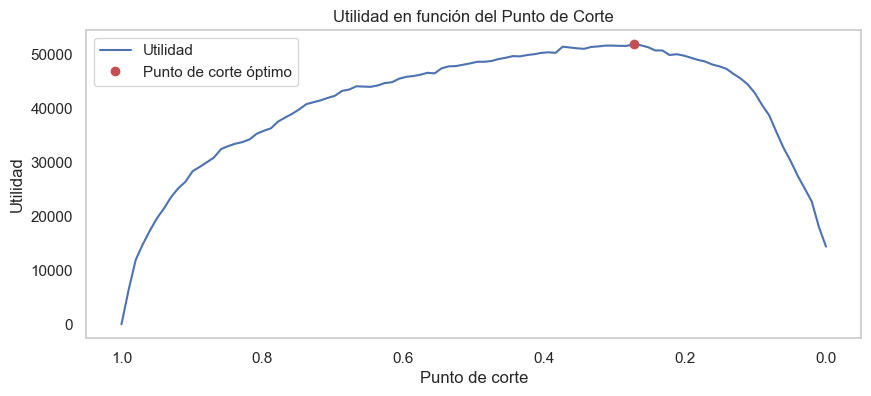

In [188]:
# Definimos los costos y beneficios
costo_por_fp = 50  # Costo por cada falso positivo
beneficio_por_vp = 100  # Beneficio por cada verdadero positivo

# Usa tus datos reales en lugar de datos aleatorios
Y_true = y_test  # Valores reales del conjunto de prueba
Y_pred = y_pred  # Probabilidades predichas por el modelo

# Generamos una lista de puntos de corte
puntos_de_corte = np.linspace(0, 1, 100)

# Calculamos la utilidad para cada punto de corte
utilidades = []
for punto_de_corte in puntos_de_corte:
    # Convertimos las probabilidades en clasificaciones binarias usando el punto de corte actual
    predicciones = (Y_pred >= punto_de_corte).astype(int)

    # Calculamos los verdaderos positivos y falsos positivos
    vp = np.sum((predicciones == 1) & (Y_true == 1))
    fp = np.sum((predicciones == 1) & (Y_true == 0))

    # Calculamos la utilidad
    utilidad = (vp * beneficio_por_vp) - (fp * costo_por_fp)
    utilidades.append(utilidad)

# Encontramos el índice del punto de corte con la máxima utilidad
indice_max_utilidad = np.argmax(utilidades)
punto_de_corte_optimo = puntos_de_corte[indice_max_utilidad]
utilidad_maxima = utilidades[indice_max_utilidad]

# Imprimimos los resultados
print(f"El punto de corte óptimo es {punto_de_corte_optimo} con una utilidad máxima de {utilidad_maxima}")

# Graficar la utilidad en función de los puntos de corte
plt.figure(figsize=(10, 4))
plt.plot(puntos_de_corte, utilidades, label='Utilidad')
plt.plot(punto_de_corte_optimo, utilidad_maxima, 'ro', label='Punto de corte óptimo')
plt.xlabel('Punto de corte')
plt.ylabel('Utilidad')
plt.title('Utilidad en función del Punto de Corte')
plt.legend()
plt.grid()
plt.gca().invert_xaxis()  # Invertimos el eje X para que los puntos de corte decrecientes vayan de izquierda a derecha
plt.show()


# **📌 Análisis del Punto de Corte Óptimo en la Regresión Logística**

En este análisis, se busca determinar el **punto de corte óptimo** que maximice la utilidad de un modelo de **regresión logística**, considerando los beneficios y costos asociados con las decisiones del modelo.

---

## **📊 Gráfica: Utilidad en función del Punto de Corte**

La gráfica muestra cómo varía la **utilidad** para diferentes valores del **punto de corte** (`threshold`). Este análisis permite identificar el punto donde la utilidad es máxima, optimizando la relación entre los **verdaderos positivos (VP)** y los **falsos positivos (FP)**.

### **📌 Elementos de la Gráfica**
1. **Eje X (Punto de Corte):**
   Representa los valores de probabilidad que sirven como umbral para clasificar las predicciones del modelo en categorías (`comprador` o `no comprador`).

2. **Eje Y (Utilidad):**
   Indica la utilidad calculada para cada punto de corte. La fórmula utilizada es:

   $$
   \text{Utilidad} = (\text{VP} \times \text{Beneficio por VP}) - (\text{FP} \times \text{Costo por FP})
   $$

   Donde:
   - $ \text{VP} $: Número de verdaderos positivos.
   - $ \text{FP} $: Número de falsos positivos.
   - $ \text{Beneficio por VP} $ y $ \text{Costo por FP} $ son valores predefinidos.

3. **Curva Azul:**
   Muestra cómo varía la utilidad con respecto al punto de corte.

4. **Punto Rojo:**
   Representa el **punto de corte óptimo**, donde la utilidad alcanza su valor máximo.

---

## **📌 Interpretación de la Gráfica**
- A medida que **disminuye** el punto de corte, el modelo clasifica más casos como positivos. Esto incrementa tanto los **verdaderos positivos (VP)** como los **falsos positivos (FP)**.
- El **punto de corte óptimo** representa el equilibrio donde el beneficio adicional generado por los VP **supera el costo generado por los FP**.
- Seleccionar este punto de corte asegura la **máxima utilidad económica** para la organización.

---

## **📌 Punto de Corte Óptimo y Utilidad Máxima**
| Punto de Corte Óptimo | Utilidad Máxima (\$) | Beneficio por VP (\$) | Costo por FP (\$) |
|----------------------|---------------------|----------------------|------------------|
| **0.272**           | **51950**           | **100**              | **50**           |

El modelo logra su **máxima utilidad con un punto de corte de 0.272**, lo que significa que cualquier usuario con una probabilidad **mayor o igual al 27.2%** será clasificado como convertido.

---

## **📌 Conclusión**
✔ Se utilizó `drop_first=True` al generar variables dummies, lo que redujo la dimensionalidad del modelo.  
✔ El **punto de corte óptimo** para maximizar la utilidad es **0.272**, con una utilidad esperada de **51,950 dólares**.  
✔ Este análisis permite ajustar la estrategia de clasificación para mejorar la toma de decisiones de negocio.  

---

## **📌 Recomendación**
Utilizar el **punto de corte óptimo** identificado para maximizar los beneficios en futuras clasificaciones. Además, asegurarse de evaluar este umbral en producción para verificar que se mantenga estable con nuevos datos.


### Guardar el modelo 

In [245]:
from joblib import dump

# Guardar el modelo de regresión logística
dump(modelo_lr, 'modelo_logistico.pkl')  # Guardar en un archivo .pkl
print("Modelo guardado exitosamente.")


Modelo guardado exitosamente.


In [246]:
from joblib import load
from sklearn.metrics import roc_curve, auc

# Cargar el modelo guardado
modelo_lr = load('modelo_logistico.pkl')
print("Modelo cargado exitosamente.")

# Generar predicciones de probabilidad con el modelo cargado
y_pred_cargado = modelo_lr.predict_proba(X_test)[:, 1]

# Calcular el AUC
fpr, tpr, _ = roc_curve(y_test, y_pred_cargado)
auc_valor = auc(fpr, tpr)

print(f"AUC del modelo cargado: {auc_valor:.4f}")


Modelo cargado exitosamente.
AUC del modelo cargado: 0.9212
